In [2]:
import os, os.path
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from collections import deque
import itertools
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from libs.utils import *
from libs.generate_boxes import *
from libs.dqn import *

In [3]:
tf.get_logger().setLevel('INFO')
tf.keras.backend.floatx()

'float32'

In [4]:
num_episode = 20000
global_step = 0
tr_l, h_fill, tr_r, avg_loss_l,history_eps,used_boxes_eps  = [],[],[],[],[],[]
N_MDD = 7
K = 4# 선택할 박스 수
n_candidates =4 # K보다 커야 함

In [6]:
boxes_multi1 = [np.array([[20, 20,  4],
         [20,  4,  4],
         [20,  4,  4],
         [20,  4,  4],
         [20,  4,  4],
         [20,  4,  4],
         [20, 20,  4],
         [20, 20,  4],
         [20, 20,  4]])]
gt_pos1 = [np.array([[ 0,  0,  0],
         [ 0,  0,  4],
         [ 0,  4,  4],
         [ 0,  8,  4],
         [ 0, 12,  4],
         [ 0, 16,  4],
         [ 0,  0,  8],
         [ 0,  0, 12],
         [ 0,  0, 16]])]

boxes_multi2 = [np.array([[20, 20,  5],
        [ 4, 20,  5],
        [ 4, 20,  5],
        [ 4, 20,  5],
        [ 4, 20,  5],
        [ 4, 20,  5],
        [10, 20,  5],
        [10, 20,  5],
        [20, 20,  5]])]

gt_pos2 = [np.array([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 4,  0,  5],
        [ 8,  0,  5],
        [12,  0,  5],
        [16,  0,  5],
        [ 0,  0, 10],
        [10,  0, 10],
        [ 0,  0, 15]])]

num_max_boxes = max(len(boxes_multi1[0]), len(boxes_multi2[0])) * 2
num_max_remain = num_max_boxes
print(num_max_boxes, num_max_remain)

18 18


In [40]:
#여러개의 대박스 생성
env_list = [Bpp3DEnv() for i in range(2)]
agent = DQNAgent(L=20, B=20, H=20, n_remains=num_max_remain, n_loading = K, lr=13-4, exp_steps=900,
                train_st = 500, memory_len=1000, update_target_rate = 50, net='DDQN')

distribution DDQN


In [41]:
#충진률 저장
box_avg = []

In [42]:
for e in range(1, num_episode):
    st = time.time()
    
    if num_episode > 1000 and agent.epsilon <= 0.01:
        agent.epsilon = 0
        
    if e%2 == 1: boxes_multi,gt_pos = boxes_multi1.copy(), gt_pos1.copy()
    else: boxes_multi,gt_pos = boxes_multi2.copy(), gt_pos2.copy()

    #중박스 복사
    boxes_copy = boxes_multi[0].copy()
    boxes_multi = [np.concatenate([boxes_multi[0], boxes_copy])]    
    
    #여러 대박스 초기화
    for env in env_list:
        env.reset()
    
    boxes_all = np.array(boxes_multi)[0].copy()
    r_boxes = boxes_all.copy()
    
    if agent.epsilon > agent.epsilon_end and len(agent.memory) >= agent.train_start:
        agent.epsilon -= agent.epsilon_decay_step
    
    done = False
    step = 0
    history, h_load, h_remain_size, h_load_size = [],[],[],[]
    t_history, t_load, t_remain_size, t_load_size = [],[],[],[]
    used_boxes, pred_pos = [],[]
    bbox_step = 0
    #대박스 별로 적재
    while not done:
        env = env_list[bbox_step]
        state = env.container_s.copy()
        state_h = env.container_h.copy()
        step += 1
        bbox_step += 1
        if bbox_step >= len(env_list): bbox_step = 0
        global_step += 1
        k = min(K, len(r_boxes))
        selected = cbn_select_boxes(r_boxes[:n_candidates], k)
        s_order = get_selected_order(selected, k)

        num_loaded_c, loading_size_c, loading_pos_c, next_state_c, next_h_c, loaded_mh_c = get_selected_location(s_order, state, state_h, env.height)
        in_state, in_r_boxes, in_loading = raw2input(state_h, len(num_loaded_c), r_boxes, num_max_remain, K, loading_size_c, env.height)

        if len(num_loaded_c) == 1:
            action_idx = 0
        else:
            action_idx = agent.get_action(in_state, np.array(loaded_mh_c), in_r_boxes, in_loading)

        env.step(next_state_c[action_idx], next_h_c[action_idx])
        num_loaded_box = num_loaded_c[action_idx]

        if num_loaded_box != 0:
            new_used_boxes = loading_size_c[action_idx]
            r_boxes = get_remain(new_used_boxes, r_boxes)
            used_boxes = used_boxes + loading_size_c[action_idx]
            pred_pos = pred_pos + loading_pos_c[action_idx]

        else:
            r_boxes = get_remain(s_order[action_idx], r_boxes)

        if len(r_boxes) == 0 or np.sum(env.container_h != env.height) == 0:
            done = True

        if len(num_loaded_c) != 1 or done:
            history.append(in_state[action_idx])
            h_load.append(loaded_mh_c[action_idx])
            h_remain_size.append(in_r_boxes[action_idx])
            h_load_size.append(in_loading[action_idx])

            t_state = next_state_c[action_idx].copy()
            t_state_h = next_h_c[action_idx].copy()

            if done:
                in_t_history = t_state_h.reshape((1, env.length, env.breadth, 1))
                loaded_mh_c = np.zeros((1, env.length, env.breadth, 2))
                in_t_remains = np.zeros((1, env.length, env.breadth, num_max_remain))
                in_t_loading = np.zeros((1, env.length, env.breadth, K))
            else:
                k = min(K, len(r_boxes))
                selected = cbn_select_boxes(r_boxes[:n_candidates], k)

                s_order = get_selected_order(selected, k)
                num_loaded_c, loading_size_c, loading_pos_c, next_state_c, next_h_c, loaded_mh_c = get_selected_location(s_order, t_state, t_state_h, env.height)
                in_t_history, in_t_remains, in_t_loading = raw2input(t_state_h, len(num_loaded_c), r_boxes, num_max_remain, K, loading_size_c, env.height)

            t_history.append(in_t_history)
            t_load.append(np.array(loaded_mh_c))
            t_remain_size.append(in_t_remains)
            t_load_size.append(in_t_loading)

        if done:
            #avg_r = 0 if len(tr_r) == 0 else np.mean(tr_r)
            #terminal_reward = (env.terminal_reward()) ** 3
            terminal_reward = 0
            for env in env_list:
                terminal_reward += env.terminal_reward()
            terminal_reward /= len(env_list)
            tr_l.append(terminal_reward)
            #h_fill.append(env.terminal_reward())
            h_fill.append(terminal_reward)
            #box_avg.append(terminal_reward)
            #if agent.epsilon >= 0.7: tr_r.append(env.terminal_reward())

            #a_repeate = 1
            is_last = False
            N = len(history)
            for i in range(N):
                if i == N-1: is_last = True
                reward = (0.99 ** (N-i-1)) * terminal_reward
                #for a in range(a_repeate):
                agent.append_sample(history[i], h_load[i], h_remain_size[i], h_load_size[i],
                                   reward, is_last, t_history[i], t_load[i], 
                                   t_remain_size[i], t_load_size[i])
            #if global_step > agent.train_start:
                #agent.draw_tensorboard(terminal_reward, env.terminal_reward(), step, e)

        if len(agent.memory) >= agent.train_start:
            agent.train_model()
            if global_step % agent.update_target_rate == 0:
                print('update', e)
                agent.update_target_model()
            avg_loss_l.append(agent.avg_loss / float(step))

    box_avg.append(h_fill[-1])
    log = "=====episode: {:5d} | ".format(e)
    log += "memory length: {:5d} | ".format(len(agent.memory))
    log += "epsilon: {:.3f} | ".format(agent.epsilon)
    log += "r_boxes: {:5d}  | ".format(len(r_boxes))
    log += "reward(): {:.3f}, {:.3f}, {:.3f}| ".format(env_list[0].terminal_reward(), env_list[1].terminal_reward(), h_fill[-1])
    #log += "t_reward: {:.3f} | ".format(t_reward)
    #log += "q avg : {:3.2f} | ".format(agent.avg_q_max / float(step))
    log += "avg loss : {:6f} ".format(agent.avg_loss / float(step))
    log += "time: {:.3f}".format(time.time()-st)
    print(log)
    agent.avg_q_max, agent.avg_loss = 0, 0

=====episode:     1 | memory length:     3 | epsilon: 1.000 | r_boxes:     8  | reward(): 0.720, 0.480, 0.600| avg loss : 0.000000 time: 0.047
=====episode:     2 | memory length:     6 | epsilon: 1.000 | r_boxes:     6  | reward(): 1.000, 0.350, 0.675| avg loss : 0.000000 time: 0.050
=====episode:     3 | memory length:    10 | epsilon: 1.000 | r_boxes:     3  | reward(): 0.600, 0.800, 0.700| avg loss : 0.000000 time: 0.056
=====episode:     4 | memory length:    13 | epsilon: 1.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 0.000000 time: 0.047
=====episode:     5 | memory length:    17 | epsilon: 1.000 | r_boxes:     4  | reward(): 0.800, 0.720, 0.760| avg loss : 0.000000 time: 0.058
=====episode:     6 | memory length:    20 | epsilon: 1.000 | r_boxes:     8  | reward(): 0.900, 0.350, 0.625| avg loss : 0.000000 time: 0.049
=====episode:     7 | memory length:    24 | epsilon: 1.000 | r_boxes:     6  | reward(): 0.600, 0.680, 0.640| avg loss : 0.000000 time: 0.050

=====episode:    63 | memory length:   218 | epsilon: 1.000 | r_boxes:     5  | reward(): 0.600, 0.720, 0.660| avg loss : 0.000000 time: 0.056
=====episode:    64 | memory length:   223 | epsilon: 1.000 | r_boxes:     0  | reward(): 0.875, 0.875, 0.875| avg loss : 0.000000 time: 0.070
=====episode:    65 | memory length:   226 | epsilon: 1.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 0.000000 time: 0.044
=====episode:    66 | memory length:   229 | epsilon: 1.000 | r_boxes:     9  | reward(): 0.650, 0.350, 0.500| avg loss : 0.000000 time: 0.043
=====episode:    67 | memory length:   232 | epsilon: 1.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 0.000000 time: 0.046
=====episode:    68 | memory length:   237 | epsilon: 1.000 | r_boxes:     0  | reward(): 0.875, 0.750, 0.812| avg loss : 0.000000 time: 0.070
=====episode:    69 | memory length:   241 | epsilon: 1.000 | r_boxes:     6  | reward(): 0.600, 0.680, 0.640| avg loss : 0.000000 time: 0.053

=====episode:   125 | memory length:   433 | epsilon: 1.000 | r_boxes:     5  | reward(): 0.600, 0.720, 0.660| avg loss : 0.000000 time: 0.059
=====episode:   126 | memory length:   436 | epsilon: 1.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 0.000000 time: 0.047
=====episode:   127 | memory length:   440 | epsilon: 1.000 | r_boxes:     3  | reward(): 0.600, 0.800, 0.700| avg loss : 0.000000 time: 0.058
=====episode:   128 | memory length:   443 | epsilon: 1.000 | r_boxes:     8  | reward(): 0.700, 0.350, 0.525| avg loss : 0.000000 time: 0.045
=====episode:   129 | memory length:   446 | epsilon: 1.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 0.000000 time: 0.048
=====episode:   130 | memory length:   451 | epsilon: 1.000 | r_boxes:     0  | reward(): 0.875, 0.750, 0.812| avg loss : 0.000000 time: 0.069
=====episode:   131 | memory length:   456 | epsilon: 1.000 | r_boxes:     0  | reward(): 0.600, 0.800, 0.700| avg loss : 0.000000 time: 0.064

=====episode:   182 | memory length:   633 | epsilon: 0.957 | r_boxes:     3  | reward(): 0.750, 0.750, 0.750| avg loss : 3.613916 time: 0.263
=====episode:   183 | memory length:   636 | epsilon: 0.956 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.385089 time: 0.197
=====episode:   184 | memory length:   639 | epsilon: 0.955 | r_boxes:     8  | reward(): 0.700, 0.350, 0.525| avg loss : 3.094481 time: 0.196
=====episode:   185 | memory length:   642 | epsilon: 0.954 | r_boxes:     7  | reward(): 0.760, 0.480, 0.620| avg loss : 2.936576 time: 0.193
=====episode:   186 | memory length:   645 | epsilon: 0.953 | r_boxes:     9  | reward(): 0.650, 0.350, 0.500| avg loss : 3.370524 time: 0.187
update 187
=====episode:   187 | memory length:   648 | epsilon: 0.952 | r_boxes:     7  | reward(): 0.760, 0.480, 0.620| avg loss : 3.271266 time: 0.205
=====episode:   188 | memory length:   651 | epsilon: 0.951 | r_boxes:     6  | reward(): 1.000, 0.350, 0.675| avg loss : 2.840475 

=====episode:   239 | memory length:   829 | epsilon: 0.894 | r_boxes:     3  | reward(): 0.600, 0.800, 0.700| avg loss : 2.955398 time: 0.336
=====episode:   240 | memory length:   832 | epsilon: 0.893 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.687708 time: 0.263
=====episode:   241 | memory length:   837 | epsilon: 0.892 | r_boxes:     0  | reward(): 0.800, 0.800, 0.800| avg loss : 3.018438 time: 0.437
=====episode:   242 | memory length:   840 | epsilon: 0.891 | r_boxes:     8  | reward(): 0.900, 0.350, 0.625| avg loss : 3.030324 time: 0.280
=====episode:   243 | memory length:   844 | epsilon: 0.890 | r_boxes:     3  | reward(): 0.800, 0.760, 0.780| avg loss : 2.901188 time: 0.273
update 244
=====episode:   244 | memory length:   847 | epsilon: 0.889 | r_boxes:     9  | reward(): 0.650, 0.350, 0.500| avg loss : 3.135022 time: 0.216
=====episode:   245 | memory length:   851 | epsilon: 0.888 | r_boxes:     2  | reward(): 0.800, 0.800, 0.800| avg loss : 3.080577 

=====episode:   296 | memory length:  1000 | epsilon: 0.832 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.646334 time: 0.211
=====episode:   297 | memory length:  1000 | epsilon: 0.831 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.482668 time: 0.227
=====episode:   298 | memory length:  1000 | epsilon: 0.830 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.873832 time: 0.215
=====episode:   299 | memory length:  1000 | epsilon: 0.828 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.453233 time: 0.307
=====episode:   300 | memory length:  1000 | epsilon: 0.827 | r_boxes:     0  | reward(): 0.875, 0.750, 0.812| avg loss : 3.242227 time: 0.437
=====episode:   301 | memory length:  1000 | epsilon: 0.826 | r_boxes:     7  | reward(): 0.760, 0.480, 0.620| avg loss : 3.540492 time: 0.210
update 302
=====episode:   302 | memory length:  1000 | epsilon: 0.825 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.065471 

=====episode:   353 | memory length:  1000 | epsilon: 0.769 | r_boxes:     5  | reward(): 0.800, 0.680, 0.740| avg loss : 3.871958 time: 0.294
=====episode:   354 | memory length:  1000 | epsilon: 0.768 | r_boxes:     8  | reward(): 0.900, 0.350, 0.625| avg loss : 3.348180 time: 0.254
=====episode:   355 | memory length:  1000 | epsilon: 0.767 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.220971 time: 0.244
=====episode:   356 | memory length:  1000 | epsilon: 0.766 | r_boxes:     9  | reward(): 0.650, 0.350, 0.500| avg loss : 3.035949 time: 0.205
=====episode:   357 | memory length:  1000 | epsilon: 0.765 | r_boxes:     7  | reward(): 0.760, 0.480, 0.620| avg loss : 2.864186 time: 0.234
=====episode:   358 | memory length:  1000 | epsilon: 0.764 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.563481 time: 0.245
=====episode:   359 | memory length:  1000 | epsilon: 0.762 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.097340 time: 0.333

=====episode:   410 | memory length:  1000 | epsilon: 0.706 | r_boxes:     8  | reward(): 0.900, 0.350, 0.625| avg loss : 2.870972 time: 0.278
=====episode:   411 | memory length:  1000 | epsilon: 0.705 | r_boxes:     7  | reward(): 0.760, 0.480, 0.620| avg loss : 2.674689 time: 0.175
=====episode:   412 | memory length:  1000 | epsilon: 0.704 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.671994 time: 0.235
=====episode:   413 | memory length:  1000 | epsilon: 0.703 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.621397 time: 0.289
=====episode:   414 | memory length:  1000 | epsilon: 0.702 | r_boxes:     9  | reward(): 0.650, 0.350, 0.500| avg loss : 2.828784 time: 0.185
=====episode:   415 | memory length:  1000 | epsilon: 0.701 | r_boxes:     0  | reward(): 0.600, 0.800, 0.700| avg loss : 2.864336 time: 0.306
=====episode:   416 | memory length:  1000 | epsilon: 0.700 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.319626 time: 0.182

=====episode:   467 | memory length:  1000 | epsilon: 0.644 | r_boxes:     5  | reward(): 0.800, 0.680, 0.740| avg loss : 2.588635 time: 0.257
=====episode:   468 | memory length:  1000 | epsilon: 0.643 | r_boxes:     8  | reward(): 0.700, 0.350, 0.525| avg loss : 3.683624 time: 0.245
=====episode:   469 | memory length:  1000 | epsilon: 0.641 | r_boxes:     3  | reward(): 0.600, 0.800, 0.700| avg loss : 2.682238 time: 0.376
=====episode:   470 | memory length:  1000 | epsilon: 0.640 | r_boxes:     8  | reward(): 0.700, 0.350, 0.525| avg loss : 2.650186 time: 0.188
=====episode:   471 | memory length:  1000 | epsilon: 0.639 | r_boxes:     4  | reward(): 0.800, 0.720, 0.760| avg loss : 2.584399 time: 0.346
=====episode:   472 | memory length:  1000 | epsilon: 0.638 | r_boxes:     3  | reward(): 0.750, 0.750, 0.750| avg loss : 2.688216 time: 0.257
=====episode:   473 | memory length:  1000 | epsilon: 0.637 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.743832 time: 0.245

=====episode:   524 | memory length:  1000 | epsilon: 0.581 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.819521 time: 0.295
=====episode:   525 | memory length:  1000 | epsilon: 0.580 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 4.526412 time: 0.303
=====episode:   526 | memory length:  1000 | epsilon: 0.579 | r_boxes:     9  | reward(): 0.650, 0.350, 0.500| avg loss : 2.999616 time: 0.192
=====episode:   527 | memory length:  1000 | epsilon: 0.578 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.331352 time: 0.200
=====episode:   528 | memory length:  1000 | epsilon: 0.577 | r_boxes:     8  | reward(): 0.700, 0.350, 0.525| avg loss : 4.546608 time: 0.223
=====episode:   529 | memory length:  1000 | epsilon: 0.575 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.708489 time: 0.298
=====episode:   530 | memory length:  1000 | epsilon: 0.574 | r_boxes:     6  | reward(): 1.000, 0.350, 0.675| avg loss : 5.233604 time: 0.252

=====episode:   581 | memory length:  1000 | epsilon: 0.518 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.331345 time: 0.255
=====episode:   582 | memory length:  1000 | epsilon: 0.517 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.451025 time: 0.234
=====episode:   583 | memory length:  1000 | epsilon: 0.516 | r_boxes:     7  | reward(): 0.760, 0.480, 0.620| avg loss : 3.163308 time: 0.277
=====episode:   584 | memory length:  1000 | epsilon: 0.515 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.081016 time: 0.298
=====episode:   585 | memory length:  1000 | epsilon: 0.514 | r_boxes:     0  | reward(): 0.800, 0.600, 0.700| avg loss : 2.840386 time: 0.331
=====episode:   586 | memory length:  1000 | epsilon: 0.513 | r_boxes:     0  | reward(): 0.875, 0.875, 0.875| avg loss : 2.746947 time: 0.493
=====episode:   587 | memory length:  1000 | epsilon: 0.512 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.933467 time: 0.227

=====episode:   639 | memory length:  1000 | epsilon: 0.454 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.906783 time: 0.466
update 640
=====episode:   640 | memory length:  1000 | epsilon: 0.453 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.537987 time: 0.327
=====episode:   641 | memory length:  1000 | epsilon: 0.452 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.965039 time: 0.202
=====episode:   642 | memory length:  1000 | epsilon: 0.451 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.710486 time: 0.246
=====episode:   643 | memory length:  1000 | epsilon: 0.450 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.825603 time: 0.238
=====episode:   644 | memory length:  1000 | epsilon: 0.449 | r_boxes:     6  | reward(): 1.000, 0.350, 0.675| avg loss : 2.743093 time: 0.295
=====episode:   645 | memory length:  1000 | epsilon: 0.448 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.726743 

=====episode:   696 | memory length:  1000 | epsilon: 0.392 | r_boxes:     3  | reward(): 0.750, 0.750, 0.750| avg loss : 2.957390 time: 0.392
=====episode:   697 | memory length:  1000 | epsilon: 0.391 | r_boxes:     3  | reward(): 0.600, 0.800, 0.700| avg loss : 2.987526 time: 0.361
=====episode:   698 | memory length:  1000 | epsilon: 0.390 | r_boxes:     3  | reward(): 0.750, 0.750, 0.750| avg loss : 2.857571 time: 0.347
=====episode:   699 | memory length:  1000 | epsilon: 0.388 | r_boxes:     0  | reward(): 0.600, 0.800, 0.700| avg loss : 2.808779 time: 0.355
=====episode:   700 | memory length:  1000 | epsilon: 0.387 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.915345 time: 0.297
=====episode:   701 | memory length:  1000 | epsilon: 0.386 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.083594 time: 0.241
update 702
=====episode:   702 | memory length:  1000 | epsilon: 0.385 | r_boxes:     6  | reward(): 1.000, 0.350, 0.675| avg loss : 3.123234 

=====episode:   753 | memory length:  1000 | epsilon: 0.329 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.612263 time: 0.229
=====episode:   754 | memory length:  1000 | epsilon: 0.328 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.029196 time: 0.329
=====episode:   755 | memory length:  1000 | epsilon: 0.327 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.854698 time: 0.277
=====episode:   756 | memory length:  1000 | epsilon: 0.326 | r_boxes:     3  | reward(): 0.750, 0.750, 0.750| avg loss : 3.427657 time: 0.388
=====episode:   757 | memory length:  1000 | epsilon: 0.325 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.183127 time: 0.351
=====episode:   758 | memory length:  1000 | epsilon: 0.324 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.080423 time: 0.373
=====episode:   759 | memory length:  1000 | epsilon: 0.322 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.064103 time: 0.290

=====episode:   811 | memory length:  1000 | epsilon: 0.265 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.620755 time: 0.353
=====episode:   812 | memory length:  1000 | epsilon: 0.264 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.619454 time: 0.300
=====episode:   813 | memory length:  1000 | epsilon: 0.263 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.194656 time: 0.335
update 814
=====episode:   814 | memory length:  1000 | epsilon: 0.262 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.665274 time: 0.300
=====episode:   815 | memory length:  1000 | epsilon: 0.261 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.743852 time: 0.388
=====episode:   816 | memory length:  1000 | epsilon: 0.260 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.723629 time: 0.345
=====episode:   817 | memory length:  1000 | epsilon: 0.259 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.667370 

=====episode:   868 | memory length:  1000 | epsilon: 0.203 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.085184 time: 0.285
=====episode:   869 | memory length:  1000 | epsilon: 0.201 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.148787 time: 0.346
=====episode:   870 | memory length:  1000 | epsilon: 0.200 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.579151 time: 0.334
=====episode:   871 | memory length:  1000 | epsilon: 0.199 | r_boxes:     7  | reward(): 0.760, 0.480, 0.620| avg loss : 2.931326 time: 0.301
=====episode:   872 | memory length:  1000 | epsilon: 0.198 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 4.050002 time: 0.301
=====episode:   873 | memory length:  1000 | epsilon: 0.197 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 5.200837 time: 0.297
=====episode:   874 | memory length:  1000 | epsilon: 0.196 | r_boxes:     3  | reward(): 0.750, 0.750, 0.750| avg loss : 4.830039 time: 0.384

=====episode:   925 | memory length:  1000 | epsilon: 0.140 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.450282 time: 0.347
=====episode:   926 | memory length:  1000 | epsilon: 0.139 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.580393 time: 0.330
=====episode:   927 | memory length:  1000 | epsilon: 0.138 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.842236 time: 0.298
=====episode:   928 | memory length:  1000 | epsilon: 0.137 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.404995 time: 0.301
=====episode:   929 | memory length:  1000 | epsilon: 0.135 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.744023 time: 0.254
=====episode:   930 | memory length:  1000 | epsilon: 0.134 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 4.113223 time: 0.317
=====episode:   931 | memory length:  1000 | epsilon: 0.133 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.595320 time: 0.332

=====episode:   983 | memory length:  1000 | epsilon: 0.076 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.746081 time: 0.349
=====episode:   984 | memory length:  1000 | epsilon: 0.075 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.777462 time: 0.335
=====episode:   985 | memory length:  1000 | epsilon: 0.074 | r_boxes:     7  | reward(): 0.760, 0.480, 0.620| avg loss : 2.609651 time: 0.286
=====episode:   986 | memory length:  1000 | epsilon: 0.073 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.619657 time: 0.292
=====episode:   987 | memory length:  1000 | epsilon: 0.072 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.738706 time: 0.333
=====episode:   988 | memory length:  1000 | epsilon: 0.071 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.335655 time: 0.333
=====episode:   989 | memory length:  1000 | epsilon: 0.069 | r_boxes:     3  | reward(): 0.600, 0.800, 0.700| avg loss : 2.387150 time: 0.347

=====episode:  1041 | memory length:  1000 | epsilon: 0.012 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.285227 time: 0.332
=====episode:  1042 | memory length:  1000 | epsilon: 0.011 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.351845 time: 0.320
=====episode:  1043 | memory length:  1000 | epsilon: 0.010 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.321096 time: 0.346
=====episode:  1044 | memory length:  1000 | epsilon: 0.009 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.037387 time: 0.332
=====episode:  1045 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.238155 time: 0.348
=====episode:  1046 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.253038 time: 0.338
=====episode:  1047 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.442520 time: 0.327

=====episode:  1099 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.717882 time: 0.342
=====episode:  1100 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.379755 time: 0.334
=====episode:  1101 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.635120 time: 0.330
=====episode:  1102 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.301354 time: 0.323
=====episode:  1103 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.366219 time: 0.329
=====episode:  1104 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.444356 time: 0.325
=====episode:  1105 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.500855 time: 0.322

=====episode:  1157 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.494569 time: 0.340
=====episode:  1158 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.694723 time: 0.460
=====episode:  1159 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.828559 time: 0.316
=====episode:  1160 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.815060 time: 0.318
=====episode:  1161 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.988377 time: 0.324
=====episode:  1162 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.479073 time: 0.329
=====episode:  1163 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.332908 time: 0.319

=====episode:  1215 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.703119 time: 0.322
=====episode:  1216 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.892468 time: 0.317
=====episode:  1217 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.128526 time: 0.330
=====episode:  1218 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.174773 time: 0.318
=====episode:  1219 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.185438 time: 0.335
=====episode:  1220 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.881758 time: 0.316
=====episode:  1221 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.694457 time: 0.453

update 1273
=====episode:  1273 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.705839 time: 0.353
=====episode:  1274 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.482032 time: 0.321
=====episode:  1275 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.725500 time: 0.334
=====episode:  1276 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.883088 time: 0.328
=====episode:  1277 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.556139 time: 0.315
=====episode:  1278 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.962667 time: 0.310
=====episode:  1279 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.133356

=====episode:  1330 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.668489 time: 0.330
=====episode:  1331 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.840984 time: 0.330
=====episode:  1332 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.945934 time: 0.334
=====episode:  1333 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.799495 time: 0.330
=====episode:  1334 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.790837 time: 0.330
=====episode:  1335 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.840128 time: 0.327
=====episode:  1336 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.764261 time: 0.330

=====episode:  1388 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.227636 time: 0.314
=====episode:  1389 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.137806 time: 0.326
update 1390
=====episode:  1390 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.039900 time: 0.346
=====episode:  1391 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.722293 time: 0.319
=====episode:  1392 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.947955 time: 0.317
=====episode:  1393 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.012451 time: 0.324
=====episode:  1394 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.557093

=====episode:  1445 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.431045 time: 0.319
=====episode:  1446 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.380047 time: 0.318
=====episode:  1447 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.364589 time: 0.329
=====episode:  1448 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.685024 time: 0.322
=====episode:  1449 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.752747 time: 0.325
=====episode:  1450 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.747190 time: 0.320
=====episode:  1451 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.523753 time: 0.323

=====episode:  1503 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.025829 time: 0.321
=====episode:  1504 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.059867 time: 0.329
=====episode:  1505 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.831041 time: 0.326
=====episode:  1506 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.833090 time: 0.331
update 1507
=====episode:  1507 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.456332 time: 0.337
=====episode:  1508 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.345961 time: 0.329
=====episode:  1509 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.801864

=====episode:  1560 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.880733 time: 0.347
=====episode:  1561 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.831238 time: 0.357
=====episode:  1562 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.917771 time: 0.333
=====episode:  1563 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.623379 time: 0.326
=====episode:  1564 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.172892 time: 0.355
=====episode:  1565 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.608984 time: 0.487
=====episode:  1566 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.624488 time: 0.340

=====episode:  1618 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.498900 time: 0.334
=====episode:  1619 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.918128 time: 0.326
=====episode:  1620 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.205602 time: 0.345
=====episode:  1621 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.194733 time: 0.317
=====episode:  1622 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.426955 time: 0.328
update 1623
=====episode:  1623 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.142281 time: 0.347
=====episode:  1624 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.728487

=====episode:  1675 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.742602 time: 0.334
=====episode:  1676 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.924404 time: 0.330
=====episode:  1677 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.843596 time: 0.342
=====episode:  1678 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.020251 time: 0.328
=====episode:  1679 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.921535 time: 0.336
=====episode:  1680 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.826347 time: 0.315
=====episode:  1681 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.826835 time: 0.333

=====episode:  1733 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.860401 time: 0.333
=====episode:  1734 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.644377 time: 0.330
=====episode:  1735 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.507483 time: 0.317
=====episode:  1736 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.538849 time: 0.320
=====episode:  1737 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.363836 time: 0.317
=====episode:  1738 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.631536 time: 0.338
=====episode:  1739 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.435142 time: 0.322

=====episode:  1791 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.963008 time: 0.339
=====episode:  1792 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.698127 time: 0.350
=====episode:  1793 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.975393 time: 0.327
=====episode:  1794 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.395193 time: 0.325
=====episode:  1795 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 6.247417 time: 0.331
=====episode:  1796 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.511503 time: 0.321
=====episode:  1797 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.986512 time: 0.315

=====episode:  1849 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.777174 time: 0.323
=====episode:  1850 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.573578 time: 0.321
=====episode:  1851 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.693674 time: 0.314
=====episode:  1852 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.186367 time: 0.314
=====episode:  1853 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.069240 time: 0.320
=====episode:  1854 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.848027 time: 0.330
=====episode:  1855 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.847023 time: 0.324

=====episode:  1907 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.831608 time: 0.344
=====episode:  1908 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.701842 time: 0.319
=====episode:  1909 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.952772 time: 0.439
=====episode:  1910 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.881832 time: 0.314
=====episode:  1911 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.925300 time: 0.332
=====episode:  1912 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.961850 time: 0.316
=====episode:  1913 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.965626 time: 0.314

=====episode:  1965 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.547461 time: 0.316
=====episode:  1966 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.839831 time: 0.315
=====episode:  1967 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.697559 time: 0.316
=====episode:  1968 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.744352 time: 0.329
=====episode:  1969 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.799979 time: 0.309
=====episode:  1970 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.706274 time: 0.317
=====episode:  1971 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.923639 time: 0.315

update 2023
=====episode:  2023 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.527158 time: 0.345
=====episode:  2024 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.883413 time: 0.321
=====episode:  2025 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.905597 time: 0.308
=====episode:  2026 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.687964 time: 0.330
=====episode:  2027 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.807290 time: 0.317
=====episode:  2028 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.167561 time: 0.334
=====episode:  2029 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.109444

=====episode:  2080 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.927652 time: 0.323
=====episode:  2081 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.198312 time: 0.334
=====episode:  2082 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.937466 time: 0.314
=====episode:  2083 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.859748 time: 0.328
=====episode:  2084 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.869017 time: 0.335
=====episode:  2085 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.722943 time: 0.324
=====episode:  2086 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.775980 time: 0.343

=====episode:  2138 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.681563 time: 0.313
=====episode:  2139 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.750660 time: 0.338
update 2140
=====episode:  2140 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.470739 time: 0.336
=====episode:  2141 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.509651 time: 0.319
=====episode:  2142 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.623219 time: 0.315
=====episode:  2143 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.575802 time: 0.332
=====episode:  2144 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.625518

=====episode:  2195 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.537942 time: 0.350
=====episode:  2196 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.583011 time: 0.334
=====episode:  2197 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.663511 time: 0.328
=====episode:  2198 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.619471 time: 0.347
=====episode:  2199 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.881768 time: 0.340
=====episode:  2200 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.340935 time: 0.332
=====episode:  2201 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.589276 time: 0.333

=====episode:  2253 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.612542 time: 0.318
=====episode:  2254 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.528059 time: 0.434
=====episode:  2255 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.509152 time: 0.316
=====episode:  2256 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.312954 time: 0.319
update 2257
=====episode:  2257 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.773296 time: 0.332
=====episode:  2258 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.553142 time: 0.323
=====episode:  2259 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.662029

=====episode:  2310 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.713748 time: 0.314
=====episode:  2311 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.856382 time: 0.330
=====episode:  2312 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.724676 time: 0.323
=====episode:  2313 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.682394 time: 0.339
=====episode:  2314 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.879829 time: 0.316
=====episode:  2315 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.870659 time: 0.329
=====episode:  2316 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.791076 time: 0.322

=====episode:  2368 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.992938 time: 0.326
=====episode:  2369 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.937492 time: 0.323
=====episode:  2370 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.157451 time: 0.329
=====episode:  2371 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.979362 time: 0.324
=====episode:  2372 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.974002 time: 0.317
update 2373
=====episode:  2373 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.102819 time: 0.351
=====episode:  2374 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.589608

=====episode:  2425 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.470672 time: 0.331
=====episode:  2426 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.107375 time: 0.323
=====episode:  2427 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.622929 time: 0.328
=====episode:  2428 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.652897 time: 0.330
=====episode:  2429 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.628305 time: 0.330
=====episode:  2430 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.280722 time: 0.333
=====episode:  2431 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.788195 time: 0.326

=====episode:  2483 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.714062 time: 0.320
=====episode:  2484 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.008292 time: 0.324
=====episode:  2485 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.784961 time: 0.330
=====episode:  2486 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.879248 time: 0.327
=====episode:  2487 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.748562 time: 0.330
=====episode:  2488 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.830676 time: 0.327
=====episode:  2489 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.503698 time: 0.319

=====episode:  2541 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.617873 time: 0.325
=====episode:  2542 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.726646 time: 0.317
=====episode:  2543 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.526147 time: 0.315
=====episode:  2544 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.855591 time: 0.326
=====episode:  2545 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.825598 time: 0.327
=====episode:  2546 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.741724 time: 0.329
=====episode:  2547 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.687398 time: 0.323

=====episode:  2599 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.893334 time: 0.514
=====episode:  2600 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.954988 time: 0.355
=====episode:  2601 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.680761 time: 0.317
=====episode:  2602 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.807102 time: 0.320
=====episode:  2603 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.370112 time: 0.318
=====episode:  2604 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.209147 time: 0.324
=====episode:  2605 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.706344 time: 0.330

=====episode:  2657 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.641552 time: 0.340
=====episode:  2658 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.882990 time: 0.317
=====episode:  2659 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.241420 time: 0.319
=====episode:  2660 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.898740 time: 0.321
=====episode:  2661 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.258272 time: 0.315
=====episode:  2662 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.213116 time: 0.432
=====episode:  2663 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.896435 time: 0.324

=====episode:  2715 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.559668 time: 0.319
=====episode:  2716 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.641003 time: 0.317
=====episode:  2717 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.352883 time: 0.321
=====episode:  2718 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.810207 time: 0.320
=====episode:  2719 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.437617 time: 0.321
=====episode:  2720 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.088533 time: 0.322
=====episode:  2721 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.557296 time: 0.321

update 2773
=====episode:  2773 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.936940 time: 0.340
=====episode:  2774 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.678997 time: 0.337
=====episode:  2775 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.767277 time: 0.320
=====episode:  2776 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.767442 time: 0.325
=====episode:  2777 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.660059 time: 0.325
=====episode:  2778 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.770424 time: 0.317
=====episode:  2779 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.935197

=====episode:  2830 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.652576 time: 0.321
=====episode:  2831 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.885252 time: 0.321
=====episode:  2832 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.694481 time: 0.323
=====episode:  2833 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.609371 time: 0.324
=====episode:  2834 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.613947 time: 0.322
=====episode:  2835 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.933451 time: 0.330
=====episode:  2836 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.103558 time: 0.324

=====episode:  2888 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.655036 time: 0.320
=====episode:  2889 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.002383 time: 0.338
update 2890
=====episode:  2890 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.692542 time: 0.334
=====episode:  2891 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.666600 time: 0.323
=====episode:  2892 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.614896 time: 0.315
=====episode:  2893 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.482459 time: 0.321
=====episode:  2894 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.748430

=====episode:  2945 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.824311 time: 0.306
=====episode:  2946 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.217624 time: 0.322
=====episode:  2947 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.162282 time: 0.325
=====episode:  2948 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.369376 time: 0.322
=====episode:  2949 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.793940 time: 0.321
=====episode:  2950 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.060193 time: 0.330
=====episode:  2951 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.289505 time: 0.328

=====episode:  3003 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.569546 time: 0.441
=====episode:  3004 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.009998 time: 0.327
=====episode:  3005 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.799004 time: 0.321
=====episode:  3006 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.152945 time: 0.320
update 3007
=====episode:  3007 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.805989 time: 0.345
=====episode:  3008 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.104018 time: 0.328
=====episode:  3009 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.314904

=====episode:  3060 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.312898 time: 0.319
=====episode:  3061 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.262462 time: 0.331
=====episode:  3062 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.365315 time: 0.330
=====episode:  3063 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.292418 time: 0.326
=====episode:  3064 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.173280 time: 0.312
=====episode:  3065 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.849151 time: 0.444
=====episode:  3066 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.797341 time: 0.320

=====episode:  3118 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.903181 time: 0.329
=====episode:  3119 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.570623 time: 0.316
=====episode:  3120 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.859844 time: 0.322
=====episode:  3121 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.778439 time: 0.324
=====episode:  3122 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.629573 time: 0.320
update 3123
=====episode:  3123 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.171047 time: 0.351
=====episode:  3124 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.409480

=====episode:  3175 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.176851 time: 0.313
=====episode:  3176 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.943579 time: 0.314
=====episode:  3177 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.283386 time: 0.327
=====episode:  3178 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.851971 time: 0.337
=====episode:  3179 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.284853 time: 0.322
=====episode:  3180 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.076584 time: 0.329
=====episode:  3181 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.526693 time: 0.323

=====episode:  3233 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.577624 time: 0.317
=====episode:  3234 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.672864 time: 0.309
=====episode:  3235 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.752023 time: 0.337
=====episode:  3236 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.748699 time: 0.323
=====episode:  3237 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.664752 time: 0.328
=====episode:  3238 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.480590 time: 0.329
=====episode:  3239 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.768035 time: 0.321

=====episode:  3291 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.332634 time: 0.325
=====episode:  3292 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.337978 time: 0.317
=====episode:  3293 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.039170 time: 0.338
=====episode:  3294 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.071400 time: 0.325
=====episode:  3295 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.283086 time: 0.326
=====episode:  3296 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.947504 time: 0.324
=====episode:  3297 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.736125 time: 0.311

=====episode:  3349 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.691847 time: 0.328
=====episode:  3350 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.894621 time: 0.318
=====episode:  3351 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.782329 time: 0.335
=====episode:  3352 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.582760 time: 0.323
=====episode:  3353 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.951524 time: 0.324
=====episode:  3354 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.843381 time: 0.320
=====episode:  3355 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.666013 time: 0.325

=====episode:  3407 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.456299 time: 0.338
=====episode:  3408 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.903094 time: 0.333
=====episode:  3409 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.533686 time: 0.449
=====episode:  3410 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.449173 time: 0.313
=====episode:  3411 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.544682 time: 0.312
=====episode:  3412 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.308704 time: 0.325
=====episode:  3413 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.396928 time: 0.325

=====episode:  3465 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 0.866977 time: 0.323
=====episode:  3466 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 0.937043 time: 0.324
=====episode:  3467 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.156452 time: 0.335
=====episode:  3468 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.487636 time: 0.317
=====episode:  3469 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.661334 time: 0.321
=====episode:  3470 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.659155 time: 0.317
=====episode:  3471 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.496687 time: 0.458

update 3523
=====episode:  3523 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.087423 time: 0.332
=====episode:  3524 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.641139 time: 0.332
=====episode:  3525 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.318536 time: 0.321
=====episode:  3526 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.737229 time: 0.319
=====episode:  3527 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.050956 time: 0.315
=====episode:  3528 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.251168 time: 0.313
=====episode:  3529 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.728041

=====episode:  3580 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.933747 time: 0.327
=====episode:  3581 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.710248 time: 0.334
=====episode:  3582 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.613350 time: 0.333
=====episode:  3583 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.661975 time: 0.331
=====episode:  3584 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.763291 time: 0.323
=====episode:  3585 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.809862 time: 0.323
=====episode:  3586 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.768062 time: 0.310

=====episode:  3638 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.761121 time: 0.345
=====episode:  3639 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.853623 time: 0.325
update 3640
=====episode:  3640 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.732631 time: 0.332
=====episode:  3641 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.638348 time: 0.313
=====episode:  3642 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.724426 time: 0.317
=====episode:  3643 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.675956 time: 0.320
=====episode:  3644 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.670326

=====episode:  3695 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.075924 time: 0.313
=====episode:  3696 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.470290 time: 0.323
=====episode:  3697 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.275102 time: 0.330
=====episode:  3698 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.218999 time: 0.324
=====episode:  3699 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.723912 time: 0.326
=====episode:  3700 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 0.966112 time: 0.325
=====episode:  3701 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.327985 time: 0.315

=====episode:  3753 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.885753 time: 0.329
=====episode:  3754 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.468566 time: 0.436
=====episode:  3755 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.851454 time: 0.320
=====episode:  3756 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.825153 time: 0.317
update 3757
=====episode:  3757 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.573236 time: 0.350
=====episode:  3758 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.227975 time: 0.319
=====episode:  3759 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.415847

=====episode:  3810 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.089145 time: 0.326
=====episode:  3811 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.345073 time: 0.319
=====episode:  3812 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.370936 time: 0.328
=====episode:  3813 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.973525 time: 0.330
=====episode:  3814 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.209133 time: 0.321
=====episode:  3815 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.996097 time: 0.328
=====episode:  3816 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.264584 time: 0.459

=====episode:  3868 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.790530 time: 0.321
=====episode:  3869 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.711338 time: 0.318
=====episode:  3870 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.751014 time: 0.322
=====episode:  3871 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.642494 time: 0.313
=====episode:  3872 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.721208 time: 0.327
update 3873
=====episode:  3873 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.672658 time: 0.327
=====episode:  3874 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.729424

=====episode:  3925 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.786294 time: 0.319
=====episode:  3926 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.760196 time: 0.330
=====episode:  3927 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.326045 time: 0.326
=====episode:  3928 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.481083 time: 0.322
=====episode:  3929 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.828418 time: 0.333
=====episode:  3930 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.960074 time: 0.323
=====episode:  3931 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.919830 time: 0.318

=====episode:  3983 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.263503 time: 0.317
=====episode:  3984 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.410501 time: 0.316
=====episode:  3985 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.460305 time: 0.331
=====episode:  3986 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.424304 time: 0.323
=====episode:  3987 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.958232 time: 0.323
=====episode:  3988 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.614481 time: 0.325
=====episode:  3989 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.781337 time: 0.325

=====episode:  4041 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.806107 time: 0.320
=====episode:  4042 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.667614 time: 0.322
=====episode:  4043 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.622552 time: 0.319
=====episode:  4044 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.815487 time: 0.317
=====episode:  4045 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.768253 time: 0.314
=====episode:  4046 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.114457 time: 0.323
=====episode:  4047 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.220562 time: 0.316

=====episode:  4099 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 0.998824 time: 0.431
=====episode:  4100 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.528706 time: 0.324
=====episode:  4101 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.523337 time: 0.314
=====episode:  4102 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 0.884134 time: 0.335
=====episode:  4103 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.504893 time: 0.322
=====episode:  4104 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.188585 time: 0.322
=====episode:  4105 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.209759 time: 0.313

=====episode:  4157 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.854066 time: 0.345
=====episode:  4158 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.849855 time: 0.325
=====episode:  4159 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.448129 time: 0.321
=====episode:  4160 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.975798 time: 0.314
=====episode:  4161 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.373235 time: 0.439
=====episode:  4162 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.566907 time: 0.310
=====episode:  4163 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.261988 time: 0.323

=====episode:  4215 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.798340 time: 0.321
=====episode:  4216 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.887728 time: 0.319
=====episode:  4217 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.690433 time: 0.317
=====episode:  4218 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.829521 time: 0.319
=====episode:  4219 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.951344 time: 0.322
=====episode:  4220 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.761883 time: 0.320
=====episode:  4221 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.932076 time: 0.330

update 4273
=====episode:  4273 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.474727 time: 0.334
=====episode:  4274 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.725093 time: 0.321
=====episode:  4275 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.654754 time: 0.332
=====episode:  4276 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.653070 time: 0.324
=====episode:  4277 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.765765 time: 0.326
=====episode:  4278 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.587555 time: 0.315
=====episode:  4279 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.824827

=====episode:  4330 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.882665 time: 0.328
=====episode:  4331 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.888546 time: 0.324
=====episode:  4332 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.899224 time: 0.322
=====episode:  4333 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.004026 time: 0.328
=====episode:  4334 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.873287 time: 0.331
=====episode:  4335 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.806160 time: 0.326
=====episode:  4336 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.836346 time: 0.327

=====episode:  4388 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.515446 time: 0.321
=====episode:  4389 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.796527 time: 0.322
update 4390
=====episode:  4390 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.666445 time: 0.337
=====episode:  4391 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.774646 time: 0.324
=====episode:  4392 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.681936 time: 0.328
=====episode:  4393 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.663017 time: 0.325
=====episode:  4394 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.790811

=====episode:  4445 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.662523 time: 0.323
=====episode:  4446 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.736057 time: 0.329
=====episode:  4447 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.729421 time: 0.315
=====episode:  4448 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.633797 time: 0.316
=====episode:  4449 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.787345 time: 0.321
=====episode:  4450 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.811999 time: 0.323
=====episode:  4451 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.872642 time: 0.328

=====episode:  4503 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.717113 time: 0.318
=====episode:  4504 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.928792 time: 0.313
=====episode:  4505 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.769132 time: 0.319
=====episode:  4506 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.782003 time: 0.324
update 4507
=====episode:  4507 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.967033 time: 0.340
=====episode:  4508 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.594437 time: 0.334
=====episode:  4509 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.335054

=====episode:  4560 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.967693 time: 0.324
=====episode:  4561 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.922646 time: 0.320
=====episode:  4562 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.291659 time: 0.334
=====episode:  4563 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.026369 time: 0.331
=====episode:  4564 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.559546 time: 0.447
=====episode:  4565 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.989474 time: 0.319
=====episode:  4566 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.772169 time: 0.325

=====episode:  4618 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.785263 time: 0.334
=====episode:  4619 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.897963 time: 0.315
=====episode:  4620 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 5.283531 time: 0.327
=====episode:  4621 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 4.810562 time: 0.335
=====episode:  4622 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.654347 time: 0.326
update 4623
=====episode:  4623 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.220938 time: 0.340
=====episode:  4624 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.077455

=====episode:  4675 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.722123 time: 0.324
=====episode:  4676 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.631695 time: 0.322
=====episode:  4677 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.940790 time: 0.318
=====episode:  4678 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.631334 time: 0.324
=====episode:  4679 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.789714 time: 0.332
=====episode:  4680 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.799513 time: 0.322
=====episode:  4681 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.797661 time: 0.330

=====episode:  4733 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.651677 time: 0.326
=====episode:  4734 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.829902 time: 0.324
=====episode:  4735 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.574689 time: 0.321
=====episode:  4736 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.813206 time: 0.324
=====episode:  4737 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.810288 time: 0.322
=====episode:  4738 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.976512 time: 0.320
=====episode:  4739 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.803831 time: 0.326

=====episode:  4791 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.597443 time: 0.331
=====episode:  4792 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.891140 time: 0.317
=====episode:  4793 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.788797 time: 0.327
=====episode:  4794 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.974819 time: 0.319
=====episode:  4795 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.770971 time: 0.333
=====episode:  4796 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.666628 time: 0.320
=====episode:  4797 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.796920 time: 0.330

=====episode:  4849 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.518712 time: 0.312
=====episode:  4850 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.111765 time: 0.339
=====episode:  4851 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.234595 time: 0.326
=====episode:  4852 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.776078 time: 0.319
=====episode:  4853 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.502748 time: 0.322
=====episode:  4854 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.037293 time: 0.323
=====episode:  4855 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.857331 time: 0.314

=====episode:  4907 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.564884 time: 0.340
=====episode:  4908 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.752008 time: 0.324
=====episode:  4909 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.842573 time: 0.449
=====episode:  4910 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.735576 time: 0.322
=====episode:  4911 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.926114 time: 0.328
=====episode:  4912 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.714971 time: 0.327
=====episode:  4913 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.729736 time: 0.324

=====episode:  4965 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.542284 time: 0.323
=====episode:  4966 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.903967 time: 0.330
=====episode:  4967 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.973813 time: 0.312
=====episode:  4968 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.683588 time: 0.310
=====episode:  4969 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.941408 time: 0.326
=====episode:  4970 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.413683 time: 0.315
=====episode:  4971 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.700505 time: 0.323

update 5023
=====episode:  5023 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.720989 time: 0.340
=====episode:  5024 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.387831 time: 0.329
=====episode:  5025 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.652821 time: 0.324
=====episode:  5026 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.745377 time: 0.323
=====episode:  5027 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.817625 time: 0.327
=====episode:  5028 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.668495 time: 0.313
=====episode:  5029 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.796051

=====episode:  5080 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.167209 time: 0.313
=====episode:  5081 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.363575 time: 0.325
=====episode:  5082 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.104165 time: 0.314
=====episode:  5083 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.561053 time: 0.329
=====episode:  5084 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.796586 time: 0.315
=====episode:  5085 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.060855 time: 0.328
=====episode:  5086 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.680219 time: 0.312

=====episode:  5138 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.515651 time: 0.333
=====episode:  5139 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.312869 time: 0.336
update 5140
=====episode:  5140 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.574921 time: 0.344
=====episode:  5141 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.638073 time: 0.314
=====episode:  5142 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.841778 time: 0.318
=====episode:  5143 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.790447 time: 0.317
=====episode:  5144 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.939105

=====episode:  5195 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.596951 time: 0.322
=====episode:  5196 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.682608 time: 0.323
=====episode:  5197 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.758258 time: 0.325
=====episode:  5198 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.848047 time: 0.328
=====episode:  5199 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.727265 time: 0.327
=====episode:  5200 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.584451 time: 0.309
=====episode:  5201 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.549602 time: 0.311

=====episode:  5253 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.835580 time: 0.321
=====episode:  5254 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.670404 time: 0.440
=====episode:  5255 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.644489 time: 0.331
=====episode:  5256 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.867232 time: 0.317
update 5257
=====episode:  5257 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.551264 time: 0.329
=====episode:  5258 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.793416 time: 0.321
=====episode:  5259 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.801369

=====episode:  5310 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.868498 time: 0.328
=====episode:  5311 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.851221 time: 0.342
=====episode:  5312 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.896564 time: 0.319
=====episode:  5313 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.865083 time: 0.325
=====episode:  5314 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.711331 time: 0.314
=====episode:  5315 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.674368 time: 0.455
=====episode:  5316 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.641886 time: 0.316

=====episode:  5368 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.280942 time: 0.317
=====episode:  5369 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.210290 time: 0.322
=====episode:  5370 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.166996 time: 0.327
=====episode:  5371 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.348720 time: 0.314
=====episode:  5372 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.200571 time: 0.338
update 5373
=====episode:  5373 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.471343 time: 0.352
=====episode:  5374 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.148046

=====episode:  5425 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.984034 time: 0.316
=====episode:  5426 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.945729 time: 0.323
=====episode:  5427 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.167646 time: 0.320
=====episode:  5428 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.810597 time: 0.319
=====episode:  5429 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.658615 time: 0.327
=====episode:  5430 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.548907 time: 0.322
=====episode:  5431 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.527462 time: 0.328

=====episode:  5483 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.765698 time: 0.324
=====episode:  5484 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.313764 time: 0.323
=====episode:  5485 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.286829 time: 0.315
=====episode:  5486 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.821187 time: 0.329
=====episode:  5487 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.816009 time: 0.318
=====episode:  5488 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.758991 time: 0.335
=====episode:  5489 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.857237 time: 0.336

=====episode:  5541 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.762049 time: 0.323
=====episode:  5542 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.643172 time: 0.313
=====episode:  5543 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.666734 time: 0.321
=====episode:  5544 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.030863 time: 0.329
=====episode:  5545 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.258308 time: 0.321
=====episode:  5546 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.609243 time: 0.323
=====episode:  5547 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.657849 time: 0.329

=====episode:  5599 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.940568 time: 0.329
=====episode:  5600 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.772330 time: 0.311
=====episode:  5601 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.822918 time: 0.325
=====episode:  5602 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.016629 time: 0.328
=====episode:  5603 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.741759 time: 0.321
=====episode:  5604 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.600876 time: 0.324
=====episode:  5605 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.295359 time: 0.325

=====episode:  5657 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.570246 time: 0.329
=====episode:  5658 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.843678 time: 0.306
=====episode:  5659 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.760920 time: 0.446
=====episode:  5660 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.542984 time: 0.310
=====episode:  5661 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.393980 time: 0.318
=====episode:  5662 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.450985 time: 0.326
=====episode:  5663 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.389932 time: 0.319

=====episode:  5715 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.616269 time: 0.325
=====episode:  5716 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.247530 time: 0.319
=====episode:  5717 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.268679 time: 0.317
=====episode:  5718 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.213894 time: 0.321
=====episode:  5719 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.720319 time: 0.325
=====episode:  5720 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.967146 time: 0.325
=====episode:  5721 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.667860 time: 0.323

update 5773
=====episode:  5773 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.540872 time: 0.333
=====episode:  5774 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.558069 time: 0.318
=====episode:  5775 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.454761 time: 0.323
=====episode:  5776 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.363962 time: 0.334
=====episode:  5777 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.638072 time: 0.330
=====episode:  5778 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.571987 time: 0.325
=====episode:  5779 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.783113

=====episode:  5830 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.174112 time: 0.314
=====episode:  5831 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.595863 time: 0.334
=====episode:  5832 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.141945 time: 0.318
=====episode:  5833 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.697236 time: 0.341
=====episode:  5834 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.177458 time: 0.328
=====episode:  5835 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.457648 time: 0.321
=====episode:  5836 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.006745 time: 0.318

=====episode:  5888 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.985489 time: 0.317
=====episode:  5889 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.877219 time: 0.324
update 5890
=====episode:  5890 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.689341 time: 0.343
=====episode:  5891 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.940946 time: 0.322
=====episode:  5892 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.079108 time: 0.325
=====episode:  5893 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.835841 time: 0.321
=====episode:  5894 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.201544

=====episode:  5945 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.803679 time: 0.327
=====episode:  5946 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.757346 time: 0.310
=====episode:  5947 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.734701 time: 0.334
=====episode:  5948 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.864434 time: 0.331
=====episode:  5949 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.817290 time: 0.327
=====episode:  5950 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.891167 time: 0.324
=====episode:  5951 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.923021 time: 0.322

=====episode:  6003 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.711226 time: 0.320
=====episode:  6004 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.661750 time: 0.431
=====episode:  6005 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.664804 time: 0.326
=====episode:  6006 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.504907 time: 0.315
update 6007
=====episode:  6007 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.795979 time: 0.338
=====episode:  6008 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.566525 time: 0.320
=====episode:  6009 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.428244

=====episode:  6060 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.189364 time: 0.317
=====episode:  6061 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.030306 time: 0.319
=====episode:  6062 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.710586 time: 0.337
=====episode:  6063 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.580991 time: 0.315
=====episode:  6064 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.757833 time: 0.316
=====episode:  6065 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.772765 time: 0.332
=====episode:  6066 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.548907 time: 0.440

=====episode:  6118 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.165316 time: 0.320
=====episode:  6119 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.789028 time: 0.322
=====episode:  6120 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.007469 time: 0.326
=====episode:  6121 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.876695 time: 0.317
=====episode:  6122 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.054783 time: 0.331
update 6123
=====episode:  6123 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.624664 time: 0.353
=====episode:  6124 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.590210

=====episode:  6175 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.311812 time: 0.316
=====episode:  6176 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.745648 time: 0.321
=====episode:  6177 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.355520 time: 0.326
=====episode:  6178 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.718206 time: 0.318
=====episode:  6179 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.242210 time: 0.318
=====episode:  6180 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.325692 time: 0.323
=====episode:  6181 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.653577 time: 0.321

=====episode:  6233 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.162254 time: 0.315
=====episode:  6234 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.172376 time: 0.339
=====episode:  6235 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.913058 time: 0.332
=====episode:  6236 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.998342 time: 0.320
=====episode:  6237 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.087381 time: 0.328
=====episode:  6238 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.615921 time: 0.335
=====episode:  6239 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.843484 time: 0.330

=====episode:  6291 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.817401 time: 0.331
=====episode:  6292 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.859120 time: 0.326
=====episode:  6293 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.599800 time: 0.320
=====episode:  6294 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.589878 time: 0.315
=====episode:  6295 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.648856 time: 0.323
=====episode:  6296 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.764171 time: 0.324
=====episode:  6297 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.743439 time: 0.325

=====episode:  6349 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.810781 time: 0.443
=====episode:  6350 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.860293 time: 0.327
=====episode:  6351 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.845657 time: 0.310
=====episode:  6352 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.800248 time: 0.315
=====episode:  6353 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.738582 time: 0.320
=====episode:  6354 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.650194 time: 0.314
=====episode:  6355 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.779871 time: 0.323

=====episode:  6407 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.686849 time: 0.340
=====episode:  6408 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.936245 time: 0.324
=====episode:  6409 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.998280 time: 0.319
=====episode:  6410 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.884706 time: 0.330
=====episode:  6411 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.784559 time: 0.461
=====episode:  6412 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.752394 time: 0.325
=====episode:  6413 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.887457 time: 0.328

=====episode:  6465 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.670126 time: 0.334
=====episode:  6466 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.577345 time: 0.310
=====episode:  6467 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.538883 time: 0.323
=====episode:  6468 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.778465 time: 0.322
=====episode:  6469 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.788900 time: 0.316
=====episode:  6470 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.890514 time: 0.316
=====episode:  6471 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.059674 time: 0.321

update 6523
=====episode:  6523 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.940299 time: 0.331
=====episode:  6524 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.343730 time: 0.315
=====episode:  6525 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.190520 time: 0.316
=====episode:  6526 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.635994 time: 0.330
=====episode:  6527 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.807198 time: 0.317
=====episode:  6528 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.709722 time: 0.323
=====episode:  6529 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.578967

=====episode:  6580 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.600269 time: 0.328
=====episode:  6581 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.701531 time: 0.321
=====episode:  6582 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.642642 time: 0.322
=====episode:  6583 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.602990 time: 0.323
=====episode:  6584 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.847367 time: 0.317
=====episode:  6585 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.062675 time: 0.330
=====episode:  6586 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.705588 time: 0.333

=====episode:  6638 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.941926 time: 0.315
=====episode:  6639 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.852035 time: 0.343
update 6640
=====episode:  6640 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.833871 time: 0.333
=====episode:  6641 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.944408 time: 0.316
=====episode:  6642 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.671963 time: 0.314
=====episode:  6643 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.614265 time: 0.325
=====episode:  6644 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.504171

=====episode:  6695 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.274108 time: 0.321
=====episode:  6696 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.158905 time: 0.314
=====episode:  6697 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.686556 time: 0.324
=====episode:  6698 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.431389 time: 0.322
=====episode:  6699 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.726405 time: 0.330
=====episode:  6700 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.010264 time: 0.318
=====episode:  6701 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.885952 time: 0.335

=====episode:  6753 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.523166 time: 0.314
=====episode:  6754 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.018450 time: 0.310
=====episode:  6755 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.211924 time: 0.446
=====episode:  6756 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.207185 time: 0.322
update 6757
=====episode:  6757 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.951408 time: 0.355
=====episode:  6758 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.026294 time: 0.337
=====episode:  6759 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.778032

=====episode:  6810 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.801135 time: 0.317
=====episode:  6811 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.791816 time: 0.320
=====episode:  6812 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.030318 time: 0.330
=====episode:  6813 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.827366 time: 0.324
=====episode:  6814 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.285871 time: 0.317
=====episode:  6815 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.638172 time: 0.332
=====episode:  6816 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.295484 time: 0.318

=====episode:  6868 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.798373 time: 0.321
=====episode:  6869 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.705701 time: 0.337
=====episode:  6870 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.251837 time: 0.330
=====episode:  6871 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.581720 time: 0.318
=====episode:  6872 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.758133 time: 0.321
update 6873
=====episode:  6873 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.646166 time: 0.331
=====episode:  6874 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.414548

=====episode:  6925 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.768392 time: 0.325
=====episode:  6926 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.663905 time: 0.317
=====episode:  6927 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.732893 time: 0.329
=====episode:  6928 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.806649 time: 0.329
=====episode:  6929 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.664452 time: 0.326
=====episode:  6930 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.757455 time: 0.343
=====episode:  6931 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.738962 time: 0.319

=====episode:  6983 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.780460 time: 0.337
=====episode:  6984 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.670134 time: 0.319
=====episode:  6985 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.601352 time: 0.318
=====episode:  6986 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.576075 time: 0.330
=====episode:  6987 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.624027 time: 0.341
=====episode:  6988 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.760525 time: 0.340
=====episode:  6989 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.757992 time: 0.344

=====episode:  7041 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.311635 time: 0.315
=====episode:  7042 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.682638 time: 0.322
=====episode:  7043 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.145333 time: 0.312
=====episode:  7044 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.524371 time: 0.331
=====episode:  7045 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.129731 time: 0.330
=====episode:  7046 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.358782 time: 0.324
=====episode:  7047 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.213019 time: 0.326

=====episode:  7099 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.718853 time: 0.449
=====episode:  7100 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.930202 time: 0.321
=====episode:  7101 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.873374 time: 0.340
=====episode:  7102 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.754580 time: 0.315
=====episode:  7103 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.628701 time: 0.327
=====episode:  7104 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.012027 time: 0.327
=====episode:  7105 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.659248 time: 0.323

=====episode:  7157 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.882342 time: 0.347
=====episode:  7158 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.356941 time: 0.326
=====episode:  7159 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.212014 time: 0.324
=====episode:  7160 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.011417 time: 0.314
=====episode:  7161 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.921777 time: 0.310
=====episode:  7162 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.803245 time: 0.452
=====episode:  7163 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.983720 time: 0.330

=====episode:  7215 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.725548 time: 0.335
=====episode:  7216 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.932678 time: 0.316
=====episode:  7217 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.916214 time: 0.324
=====episode:  7218 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.723107 time: 0.315
=====episode:  7219 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.114170 time: 0.321
=====episode:  7220 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.047900 time: 0.322
=====episode:  7221 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.082047 time: 0.335

update 7273
=====episode:  7273 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.160356 time: 0.340
=====episode:  7274 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.100754 time: 0.321
=====episode:  7275 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.790350 time: 0.314
=====episode:  7276 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.736116 time: 0.329
=====episode:  7277 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.955919 time: 0.324
=====episode:  7278 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.867868 time: 0.331
=====episode:  7279 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.710076

=====episode:  7330 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.340709 time: 0.317
=====episode:  7331 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.325132 time: 0.316
=====episode:  7332 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.427047 time: 0.331
=====episode:  7333 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.443741 time: 0.331
=====episode:  7334 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.532829 time: 0.326
=====episode:  7335 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.524264 time: 0.325
=====episode:  7336 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.379068 time: 0.321

=====episode:  7388 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.779312 time: 0.329
=====episode:  7389 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.159026 time: 0.328
update 7390
=====episode:  7390 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.376548 time: 0.350
=====episode:  7391 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.950571 time: 0.310
=====episode:  7392 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.533452 time: 0.319
=====episode:  7393 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 4.252532 time: 0.317
=====episode:  7394 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.904222

=====episode:  7445 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.857496 time: 0.316
=====episode:  7446 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.619993 time: 0.327
=====episode:  7447 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.915088 time: 0.317
=====episode:  7448 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.766350 time: 0.313
=====episode:  7449 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.154641 time: 0.326
=====episode:  7450 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.960308 time: 0.321
=====episode:  7451 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.020430 time: 0.322

=====episode:  7503 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.949074 time: 0.325
=====episode:  7504 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.442405 time: 0.324
=====episode:  7505 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.973229 time: 0.320
=====episode:  7506 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.018091 time: 0.449
update 7507
=====episode:  7507 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.027239 time: 0.334
=====episode:  7508 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.741458 time: 0.321
=====episode:  7509 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.836070

=====episode:  7560 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.653425 time: 0.320
=====episode:  7561 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.542069 time: 0.314
=====episode:  7562 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.813082 time: 0.324
=====episode:  7563 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.791905 time: 0.322
=====episode:  7564 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.820729 time: 0.316
=====episode:  7565 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.875496 time: 0.316
=====episode:  7566 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.864572 time: 0.321

=====episode:  7618 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.035738 time: 0.320
=====episode:  7619 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.857725 time: 0.318
=====episode:  7620 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.318518 time: 0.324
=====episode:  7621 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.075135 time: 0.320
=====episode:  7622 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.439466 time: 0.312
update 7623
=====episode:  7623 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.591766 time: 0.343
=====episode:  7624 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.408720

=====episode:  7675 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.572803 time: 0.328
=====episode:  7676 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.477296 time: 0.322
=====episode:  7677 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.572721 time: 0.339
=====episode:  7678 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.446079 time: 0.325
=====episode:  7679 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.688773 time: 0.324
=====episode:  7680 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.970315 time: 0.315
=====episode:  7681 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.711040 time: 0.327

=====episode:  7733 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.097219 time: 0.323
=====episode:  7734 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.049159 time: 0.325
=====episode:  7735 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.027910 time: 0.320
=====episode:  7736 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.152717 time: 0.327
=====episode:  7737 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.716918 time: 0.315
=====episode:  7738 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.839999 time: 0.335
=====episode:  7739 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.900107 time: 0.320

=====episode:  7791 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.808356 time: 0.337
=====episode:  7792 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.491361 time: 0.350
=====episode:  7793 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.515645 time: 0.338
=====episode:  7794 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.681475 time: 0.333
=====episode:  7795 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.550586 time: 0.344
=====episode:  7796 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.472916 time: 0.336
=====episode:  7797 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.598311 time: 0.336

=====episode:  7849 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.676474 time: 0.344
=====episode:  7850 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.646481 time: 0.477
=====episode:  7851 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.669152 time: 0.340
=====episode:  7852 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.588747 time: 0.334
=====episode:  7853 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.848857 time: 0.345
=====episode:  7854 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.780618 time: 0.335
=====episode:  7855 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.684902 time: 0.335

=====episode:  7907 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.819962 time: 0.328
=====episode:  7908 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.818035 time: 0.313
=====episode:  7909 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.963311 time: 0.333
=====episode:  7910 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.606335 time: 0.319
=====episode:  7911 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.183964 time: 0.322
=====episode:  7912 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.444524 time: 0.316
=====episode:  7913 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.518951 time: 0.440

=====episode:  7965 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.789022 time: 0.347
=====episode:  7966 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.455777 time: 0.318
=====episode:  7967 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.723216 time: 0.339
=====episode:  7968 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.687326 time: 0.309
=====episode:  7969 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.713827 time: 0.321
=====episode:  7970 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.762105 time: 0.329
=====episode:  7971 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.539155 time: 0.333

update 8023
=====episode:  8023 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.301950 time: 0.338
=====episode:  8024 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.749889 time: 0.324
=====episode:  8025 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.647560 time: 0.317
=====episode:  8026 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.683531 time: 0.328
=====episode:  8027 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.749854 time: 0.316
=====episode:  8028 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.566044 time: 0.327
=====episode:  8029 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.501203

=====episode:  8080 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.903675 time: 0.382
=====episode:  8081 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.263159 time: 0.329
=====episode:  8082 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.219917 time: 0.324
=====episode:  8083 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.701509 time: 0.329
=====episode:  8084 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.051270 time: 0.334
=====episode:  8085 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.243098 time: 0.339
=====episode:  8086 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.057143 time: 0.321

=====episode:  8138 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.742477 time: 0.321
=====episode:  8139 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.465702 time: 0.316
update 8140
=====episode:  8140 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.297931 time: 0.332
=====episode:  8141 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.583802 time: 0.323
=====episode:  8142 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.075625 time: 0.332
=====episode:  8143 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.539247 time: 0.314
=====episode:  8144 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.168361

=====episode:  8195 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.540683 time: 0.324
=====episode:  8196 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.732824 time: 0.333
=====episode:  8197 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.595289 time: 0.314
=====episode:  8198 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.192093 time: 0.327
=====episode:  8199 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.863041 time: 0.335
=====episode:  8200 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.767548 time: 0.319
=====episode:  8201 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.142864 time: 0.315

=====episode:  8253 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.820506 time: 0.319
=====episode:  8254 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.772257 time: 0.325
=====episode:  8255 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.056889 time: 0.450
=====episode:  8256 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.543218 time: 0.314
update 8257
=====episode:  8257 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.422647 time: 0.351
=====episode:  8258 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.795142 time: 0.326
=====episode:  8259 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.665682

=====episode:  8310 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.395167 time: 0.326
=====episode:  8311 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.087326 time: 0.319
=====episode:  8312 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.501903 time: 0.318
=====episode:  8313 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.544816 time: 0.321
=====episode:  8314 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.832952 time: 0.335
=====episode:  8315 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.838989 time: 0.323
=====episode:  8316 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.612157 time: 0.314

=====episode:  8368 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.394359 time: 0.320
=====episode:  8369 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.865392 time: 0.334
=====episode:  8370 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.555348 time: 0.323
=====episode:  8371 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.413869 time: 0.320
=====episode:  8372 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.539329 time: 0.322
update 8373
=====episode:  8373 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.717450 time: 0.328
=====episode:  8374 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.204158

=====episode:  8425 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.763690 time: 0.323
=====episode:  8426 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.767442 time: 0.332
=====episode:  8427 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.115507 time: 0.322
=====episode:  8428 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.922983 time: 0.333
=====episode:  8429 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.988114 time: 0.316
=====episode:  8430 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.987695 time: 0.331
=====episode:  8431 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.863556 time: 0.335

=====episode:  8483 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.803803 time: 0.321
=====episode:  8484 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.912140 time: 0.320
=====episode:  8485 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.862009 time: 0.341
=====episode:  8486 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.893339 time: 0.330
=====episode:  8487 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.744315 time: 0.327
=====episode:  8488 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.846775 time: 0.315
=====episode:  8489 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.773029 time: 0.319

=====episode:  8541 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.998367 time: 0.330
=====episode:  8542 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.888238 time: 0.334
=====episode:  8543 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.107513 time: 0.330
=====episode:  8544 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.844859 time: 0.333
=====episode:  8545 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.823702 time: 0.319
=====episode:  8546 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.701237 time: 0.323
=====episode:  8547 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.663233 time: 0.325

=====episode:  8599 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.240443 time: 0.323
=====episode:  8600 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.949740 time: 0.324
=====episode:  8601 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.057708 time: 0.309
=====episode:  8602 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.288569 time: 0.342
=====episode:  8603 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.281808 time: 0.330
=====episode:  8604 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.910639 time: 0.318
=====episode:  8605 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.909377 time: 0.331

=====episode:  8657 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.693364 time: 0.344
=====episode:  8658 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.409695 time: 0.453
=====episode:  8659 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.677574 time: 0.328
=====episode:  8660 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.366206 time: 0.315
=====episode:  8661 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.329188 time: 0.320
=====episode:  8662 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.350777 time: 0.321
=====episode:  8663 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.420584 time: 0.337

=====episode:  8715 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.996852 time: 0.323
=====episode:  8716 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.266896 time: 0.321
=====episode:  8717 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.005483 time: 0.326
=====episode:  8718 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.988878 time: 0.326
=====episode:  8719 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.850728 time: 0.329
=====episode:  8720 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.806166 time: 0.453
=====episode:  8721 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.748532 time: 0.322

update 8773
=====episode:  8773 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.554858 time: 0.334
=====episode:  8774 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.712975 time: 0.336
=====episode:  8775 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.983187 time: 0.323
=====episode:  8776 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.674831 time: 0.321
=====episode:  8777 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.768919 time: 0.320
=====episode:  8778 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.773055 time: 0.328
=====episode:  8779 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.515970

=====episode:  8830 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.780267 time: 0.320
=====episode:  8831 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.836622 time: 0.323
=====episode:  8832 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.273506 time: 0.331
=====episode:  8833 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.602582 time: 0.317
=====episode:  8834 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.948147 time: 0.319
=====episode:  8835 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.267403 time: 0.332
=====episode:  8836 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.973940 time: 0.325

=====episode:  8888 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.043774 time: 0.320
=====episode:  8889 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.156537 time: 0.323
update 8890
=====episode:  8890 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.972220 time: 0.348
=====episode:  8891 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.043861 time: 0.317
=====episode:  8892 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.186978 time: 0.318
=====episode:  8893 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.102745 time: 0.322
=====episode:  8894 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.970877

=====episode:  8945 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.229835 time: 0.341
=====episode:  8946 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.750751 time: 0.320
=====episode:  8947 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.419383 time: 0.324
=====episode:  8948 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.275317 time: 0.323
=====episode:  8949 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.251974 time: 0.325
=====episode:  8950 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.018513 time: 0.323
=====episode:  8951 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.785200 time: 0.314

=====episode:  9003 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.160746 time: 0.335
=====episode:  9004 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.916007 time: 0.318
=====episode:  9005 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.092710 time: 0.313
=====episode:  9006 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.752155 time: 0.322
update 9007
=====episode:  9007 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.940470 time: 0.355
=====episode:  9008 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.870870 time: 0.332
=====episode:  9009 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.753633

=====episode:  9060 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.710580 time: 0.320
=====episode:  9061 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.609727 time: 0.321
=====episode:  9062 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.554333 time: 0.308
=====episode:  9063 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.601709 time: 0.443
=====episode:  9064 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.399731 time: 0.316
=====episode:  9065 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.935500 time: 0.317
=====episode:  9066 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.969778 time: 0.330

=====episode:  9118 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.410519 time: 0.329
=====episode:  9119 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.382844 time: 0.317
=====episode:  9120 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.677317 time: 0.321
=====episode:  9121 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.076207 time: 0.322
=====episode:  9122 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.140298 time: 0.322
update 9123
=====episode:  9123 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.510040 time: 0.329
=====episode:  9124 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.199773

=====episode:  9175 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.707207 time: 0.314
=====episode:  9176 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.827546 time: 0.326
=====episode:  9177 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.758874 time: 0.334
=====episode:  9178 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.928269 time: 0.323
=====episode:  9179 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.852770 time: 0.314
=====episode:  9180 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.764048 time: 0.316
=====episode:  9181 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.669272 time: 0.316

=====episode:  9233 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.277746 time: 0.326
=====episode:  9234 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.484515 time: 0.329
=====episode:  9235 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.405025 time: 0.328
=====episode:  9236 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.533046 time: 0.321
=====episode:  9237 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.130796 time: 0.340
=====episode:  9238 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.280288 time: 0.319
=====episode:  9239 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.802999 time: 0.331

=====episode:  9291 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.910416 time: 0.322
=====episode:  9292 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.819172 time: 0.348
=====episode:  9293 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.190579 time: 0.330
=====episode:  9294 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.047802 time: 0.321
=====episode:  9295 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.843781 time: 0.322
=====episode:  9296 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.843538 time: 0.333
=====episode:  9297 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.911062 time: 0.326

=====episode:  9349 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.856108 time: 0.328
=====episode:  9350 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.819473 time: 0.316
=====episode:  9351 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.843599 time: 0.319
=====episode:  9352 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 5.103432 time: 0.320
=====episode:  9353 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 4.212443 time: 0.332
=====episode:  9354 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.665293 time: 0.319
=====episode:  9355 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.705791 time: 0.336

=====episode:  9407 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.614203 time: 0.346
=====episode:  9408 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.752449 time: 0.439
=====episode:  9409 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.310826 time: 0.318
=====episode:  9410 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.822646 time: 0.337
=====episode:  9411 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.330770 time: 0.335
=====episode:  9412 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.229449 time: 0.317
=====episode:  9413 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.904682 time: 0.323

=====episode:  9465 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.374184 time: 0.314
=====episode:  9466 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 4.127944 time: 0.324
=====episode:  9467 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.840698 time: 0.314
=====episode:  9468 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.820370 time: 0.329
=====episode:  9469 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.150408 time: 0.323
=====episode:  9470 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.948927 time: 0.328
=====episode:  9471 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.446185 time: 0.446

update 9523
=====episode:  9523 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.147215 time: 0.384
=====episode:  9524 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.775221 time: 0.340
=====episode:  9525 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.744706 time: 0.328
=====episode:  9526 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.833313 time: 0.324
=====episode:  9527 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.672897 time: 0.312
=====episode:  9528 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.871726 time: 0.329
=====episode:  9529 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.593541

=====episode:  9580 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.760938 time: 0.332
=====episode:  9581 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.777423 time: 0.322
=====episode:  9582 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.967030 time: 0.321
=====episode:  9583 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.005653 time: 0.326
=====episode:  9584 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.929603 time: 0.332
=====episode:  9585 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.849470 time: 0.318
=====episode:  9586 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.030969 time: 0.327

=====episode:  9638 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.805497 time: 0.326
=====episode:  9639 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.731272 time: 0.321
update 9640
=====episode:  9640 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.680467 time: 0.342
=====episode:  9641 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.034431 time: 0.330
=====episode:  9642 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.846846 time: 0.326
=====episode:  9643 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.775059 time: 0.324
=====episode:  9644 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.863739

=====episode:  9695 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.004811 time: 0.327
=====episode:  9696 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.714087 time: 0.312
=====episode:  9697 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.524068 time: 0.318
=====episode:  9698 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.421019 time: 0.344
=====episode:  9699 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.486357 time: 0.318
=====episode:  9700 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.563057 time: 0.314
=====episode:  9701 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.647600 time: 0.324

=====episode:  9753 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.770731 time: 0.334
=====episode:  9754 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.836457 time: 0.437
=====episode:  9755 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.742790 time: 0.318
=====episode:  9756 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.896390 time: 0.331
update 9757
=====episode:  9757 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.680441 time: 0.329
=====episode:  9758 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.956032 time: 0.324
=====episode:  9759 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.752943

=====episode:  9810 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.311410 time: 0.317
=====episode:  9811 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.570925 time: 0.317
=====episode:  9812 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.289152 time: 0.306
=====episode:  9813 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.386645 time: 0.334
=====episode:  9814 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.083563 time: 0.312
=====episode:  9815 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.688395 time: 0.324
=====episode:  9816 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.374810 time: 0.445

=====episode:  9868 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.371427 time: 0.315
=====episode:  9869 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.624875 time: 0.321
=====episode:  9870 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.565880 time: 0.315
=====episode:  9871 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.618806 time: 0.317
=====episode:  9872 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.460301 time: 0.323
update 9873
=====episode:  9873 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.370099 time: 0.343
=====episode:  9874 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.859396

=====episode:  9925 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.654122 time: 0.332
=====episode:  9926 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.419246 time: 0.334
=====episode:  9927 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.703823 time: 0.320
=====episode:  9928 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.665383 time: 0.340
=====episode:  9929 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.551777 time: 0.329
=====episode:  9930 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.398087 time: 0.325
=====episode:  9931 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.454571 time: 0.323

=====episode:  9983 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.761874 time: 0.326
=====episode:  9984 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.543971 time: 0.324
=====episode:  9985 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.586177 time: 0.318
=====episode:  9986 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.707461 time: 0.332
=====episode:  9987 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.627839 time: 0.323
=====episode:  9988 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.709195 time: 0.344
=====episode:  9989 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.763329 time: 0.336

=====episode: 10041 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.016569 time: 0.335
=====episode: 10042 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.927954 time: 0.321
=====episode: 10043 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.836495 time: 0.320
=====episode: 10044 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.601950 time: 0.323
=====episode: 10045 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.653049 time: 0.323
=====episode: 10046 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.600450 time: 0.327
=====episode: 10047 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.846148 time: 0.327

=====episode: 10099 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.412581 time: 0.334
=====episode: 10100 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.515329 time: 0.322
=====episode: 10101 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.466303 time: 0.315
=====episode: 10102 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.540163 time: 0.331
=====episode: 10103 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.686353 time: 0.327
=====episode: 10104 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.555253 time: 0.310
=====episode: 10105 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.319281 time: 0.323

=====episode: 10157 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.300936 time: 0.335
=====episode: 10158 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.460280 time: 0.317
=====episode: 10159 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.867564 time: 0.327
=====episode: 10160 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.752634 time: 0.322
=====episode: 10161 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.529266 time: 0.438
=====episode: 10162 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.701549 time: 0.315
=====episode: 10163 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.832130 time: 0.326

=====episode: 10215 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.250639 time: 0.325
=====episode: 10216 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.372740 time: 0.327
=====episode: 10217 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.515030 time: 0.327
=====episode: 10218 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.512593 time: 0.322
=====episode: 10219 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.580252 time: 0.320
=====episode: 10220 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.339657 time: 0.309
=====episode: 10221 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.767757 time: 0.318

update 10273
=====episode: 10273 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.032348 time: 0.345
=====episode: 10274 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.452340 time: 0.325
=====episode: 10275 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.754660 time: 0.332
=====episode: 10276 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.091142 time: 0.318
=====episode: 10277 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.917076 time: 0.336
=====episode: 10278 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.690685 time: 0.321
=====episode: 10279 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.28537

=====episode: 10330 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.990987 time: 0.321
=====episode: 10331 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.609540 time: 0.316
=====episode: 10332 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.683365 time: 0.320
=====episode: 10333 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.744756 time: 0.329
=====episode: 10334 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.492849 time: 0.306
=====episode: 10335 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.823102 time: 0.326
=====episode: 10336 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.702588 time: 0.326

=====episode: 10388 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.482245 time: 0.321
=====episode: 10389 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.219696 time: 0.333
update 10390
=====episode: 10390 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.548189 time: 0.354
=====episode: 10391 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.660653 time: 0.326
=====episode: 10392 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.680963 time: 0.314
=====episode: 10393 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.709195 time: 0.326
=====episode: 10394 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.01784

=====episode: 10445 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.570563 time: 0.316
=====episode: 10446 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.799065 time: 0.330
=====episode: 10447 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.621579 time: 0.330
=====episode: 10448 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.575497 time: 0.321
=====episode: 10449 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.482557 time: 0.325
=====episode: 10450 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.764243 time: 0.315
=====episode: 10451 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.618110 time: 0.329

=====episode: 10503 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.693342 time: 0.315
=====episode: 10504 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.507577 time: 0.333
=====episode: 10505 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.459284 time: 0.446
=====episode: 10506 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.879935 time: 0.320
update 10507
=====episode: 10507 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.640985 time: 0.336
=====episode: 10508 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.861205 time: 0.318
=====episode: 10509 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.66881

=====episode: 10560 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 5.019069 time: 0.332
=====episode: 10561 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.378220 time: 0.326
=====episode: 10562 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.240448 time: 0.328
=====episode: 10563 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.108549 time: 0.328
=====episode: 10564 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.548576 time: 0.316
=====episode: 10565 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.720894 time: 0.315
=====episode: 10566 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.797542 time: 0.330

=====episode: 10618 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.105960 time: 0.328
=====episode: 10619 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.051344 time: 0.334
=====episode: 10620 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.387761 time: 0.324
=====episode: 10621 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.302939 time: 0.319
=====episode: 10622 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.555887 time: 0.325
update 10623
=====episode: 10623 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.990816 time: 0.344
=====episode: 10624 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.03547

=====episode: 10675 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.632122 time: 0.335
=====episode: 10676 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.618551 time: 0.335
=====episode: 10677 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.519378 time: 0.321
=====episode: 10678 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.592082 time: 0.314
=====episode: 10679 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.626280 time: 0.321
=====episode: 10680 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.820760 time: 0.314
=====episode: 10681 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.789954 time: 0.329

=====episode: 10733 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.876682 time: 0.335
=====episode: 10734 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.871781 time: 0.325
=====episode: 10735 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.325176 time: 0.325
=====episode: 10736 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.668159 time: 0.319
=====episode: 10737 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.313228 time: 0.317
=====episode: 10738 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.918983 time: 0.317
=====episode: 10739 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.679527 time: 0.320

=====episode: 10791 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.876269 time: 0.313
=====episode: 10792 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.944225 time: 0.321
=====episode: 10793 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.849431 time: 0.328
=====episode: 10794 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.788018 time: 0.333
=====episode: 10795 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.690398 time: 0.317
=====episode: 10796 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.670311 time: 0.332
=====episode: 10797 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.895389 time: 0.335

=====episode: 10849 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.869109 time: 0.326
=====episode: 10850 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.420104 time: 0.328
=====episode: 10851 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.391247 time: 0.451
=====episode: 10852 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.085798 time: 0.312
=====episode: 10853 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.567094 time: 0.315
=====episode: 10854 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.425059 time: 0.315
=====episode: 10855 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.612813 time: 0.317

=====episode: 10907 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.509176 time: 0.327
=====episode: 10908 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.302018 time: 0.324
=====episode: 10909 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.445220 time: 0.327
=====episode: 10910 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.471958 time: 0.325
=====episode: 10911 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.451841 time: 0.320
=====episode: 10912 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.555727 time: 0.323
=====episode: 10913 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.769489 time: 0.333

=====episode: 10965 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 4.707323 time: 0.315
=====episode: 10966 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.366381 time: 0.319
=====episode: 10967 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.684486 time: 0.317
=====episode: 10968 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.719834 time: 0.328
=====episode: 10969 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.100918 time: 0.321
=====episode: 10970 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 4.122220 time: 0.339
=====episode: 10971 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.922852 time: 0.320

update 11023
=====episode: 11023 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.671846 time: 0.327
=====episode: 11024 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.770359 time: 0.325
=====episode: 11025 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.155649 time: 0.320
=====episode: 11026 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.580696 time: 0.327
=====episode: 11027 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.580819 time: 0.320
=====episode: 11028 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.217965 time: 0.322
=====episode: 11029 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.96237

=====episode: 11080 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.611208 time: 0.323
=====episode: 11081 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.656935 time: 0.324
=====episode: 11082 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.762366 time: 0.331
=====episode: 11083 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.696202 time: 0.325
=====episode: 11084 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.435039 time: 0.314
=====episode: 11085 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.679962 time: 0.323
=====episode: 11086 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.454174 time: 0.325

=====episode: 11138 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.678505 time: 0.323
=====episode: 11139 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.976451 time: 0.318
update 11140
=====episode: 11140 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.643051 time: 0.327
=====episode: 11141 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.043813 time: 0.326
=====episode: 11142 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.752759 time: 0.330
=====episode: 11143 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.551977 time: 0.327
=====episode: 11144 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.82073

=====episode: 11195 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.368222 time: 0.322
=====episode: 11196 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 5.906438 time: 0.327
=====episode: 11197 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.159788 time: 0.444
=====episode: 11198 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.123330 time: 0.319
=====episode: 11199 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.762506 time: 0.327
=====episode: 11200 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.241258 time: 0.320
=====episode: 11201 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.699222 time: 0.321

=====episode: 11253 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.231450 time: 0.321
=====episode: 11254 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.842813 time: 0.328
=====episode: 11255 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.663794 time: 0.338
=====episode: 11256 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.763212 time: 0.321
update 11257
=====episode: 11257 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.293005 time: 0.343
=====episode: 11258 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.732787 time: 0.332
=====episode: 11259 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.78640

=====episode: 11310 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.891831 time: 0.351
=====episode: 11311 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.909892 time: 0.348
=====episode: 11312 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.663718 time: 0.355
=====episode: 11313 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.900217 time: 0.340
=====episode: 11314 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.801613 time: 0.330
=====episode: 11315 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.971580 time: 0.343
=====episode: 11316 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.054060 time: 0.330

=====episode: 11368 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.800619 time: 0.329
=====episode: 11369 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.669524 time: 0.341
=====episode: 11370 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.752626 time: 0.325
=====episode: 11371 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.674092 time: 0.326
=====episode: 11372 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.623731 time: 0.316
update 11373
=====episode: 11373 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.683139 time: 0.333
=====episode: 11374 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.57052

=====episode: 11425 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.771195 time: 0.316
=====episode: 11426 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.196978 time: 0.331
=====episode: 11427 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.955616 time: 0.326
=====episode: 11428 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.694538 time: 0.319
=====episode: 11429 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.501444 time: 0.326
=====episode: 11430 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.647574 time: 0.327
=====episode: 11431 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.706443 time: 0.326

=====episode: 11483 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.267764 time: 0.332
=====episode: 11484 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.239097 time: 0.317
=====episode: 11485 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.775225 time: 0.326
=====episode: 11486 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.018178 time: 0.316
=====episode: 11487 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.714129 time: 0.345
=====episode: 11488 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.812992 time: 0.317
=====episode: 11489 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.454210 time: 0.319

=====episode: 11540 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.851389 time: 0.476
=====episode: 11541 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.928357 time: 0.338
=====episode: 11542 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.993476 time: 0.326
=====episode: 11543 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.060615 time: 0.324
=====episode: 11544 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.865834 time: 0.327
=====episode: 11545 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.921112 time: 0.312
=====episode: 11546 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.879801 time: 0.317

=====episode: 11598 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.039465 time: 0.322
=====episode: 11599 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.241871 time: 0.323
=====episode: 11600 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.048509 time: 0.326
=====episode: 11601 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.071035 time: 0.318
=====episode: 11602 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.120656 time: 0.309
=====episode: 11603 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.120621 time: 0.444
=====episode: 11604 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.919114 time: 0.319

=====episode: 11656 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.808682 time: 0.327
update 11657
=====episode: 11657 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.966042 time: 0.352
=====episode: 11658 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.369846 time: 0.337
=====episode: 11659 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.965727 time: 0.322
=====episode: 11660 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.746492 time: 0.318
=====episode: 11661 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.702267 time: 0.319
=====episode: 11662 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.63285

=====episode: 11713 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.976008 time: 0.323
=====episode: 11714 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.113520 time: 0.314
=====episode: 11715 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.834055 time: 0.316
=====episode: 11716 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.871772 time: 0.321
=====episode: 11717 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.441771 time: 0.316
=====episode: 11718 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.542340 time: 0.320
=====episode: 11719 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.510613 time: 0.338

=====episode: 11771 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.449556 time: 0.319
=====episode: 11772 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.907828 time: 0.327
update 11773
=====episode: 11773 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.855171 time: 0.343
=====episode: 11774 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.874367 time: 0.324
=====episode: 11775 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.504936 time: 0.314
=====episode: 11776 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.632649 time: 0.321
=====episode: 11777 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.43588

=====episode: 11828 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.842747 time: 0.316
=====episode: 11829 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.921768 time: 0.315
=====episode: 11830 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.782661 time: 0.317
=====episode: 11831 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.996754 time: 0.315
=====episode: 11832 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.065933 time: 0.316
=====episode: 11833 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.794133 time: 0.323
=====episode: 11834 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.733407 time: 0.334

=====episode: 11886 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.803127 time: 0.317
=====episode: 11887 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.744059 time: 0.321
=====episode: 11888 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.767555 time: 0.325
=====episode: 11889 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.780695 time: 0.327
update 11890
=====episode: 11890 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.588149 time: 0.328
=====episode: 11891 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.352792 time: 0.327
=====episode: 11892 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.59397

=====episode: 11943 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.458310 time: 0.323
=====episode: 11944 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.193069 time: 0.313
=====episode: 11945 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.650421 time: 0.311
=====episode: 11946 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.573141 time: 0.327
=====episode: 11947 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.478874 time: 0.432
=====episode: 11948 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.571006 time: 0.326
=====episode: 11949 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.605632 time: 0.327

=====episode: 12001 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.969952 time: 0.330
=====episode: 12002 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.845184 time: 0.321
=====episode: 12003 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.692670 time: 0.321
=====episode: 12004 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.668723 time: 0.316
=====episode: 12005 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.369726 time: 0.315
=====episode: 12006 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.365121 time: 0.324
update 12007
=====episode: 12007 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.79872

=====episode: 12058 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.631895 time: 0.316
=====episode: 12059 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.691873 time: 0.318
=====episode: 12060 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.022345 time: 0.328
=====episode: 12061 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.844524 time: 0.327
=====episode: 12062 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.816575 time: 0.317
=====episode: 12063 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.233774 time: 0.338
=====episode: 12064 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.926493 time: 0.330

=====episode: 12116 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.963436 time: 0.322
=====episode: 12117 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.047963 time: 0.333
=====episode: 12118 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.847799 time: 0.324
=====episode: 12119 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.868235 time: 0.318
=====episode: 12120 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.840761 time: 0.315
=====episode: 12121 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.770239 time: 0.324
=====episode: 12122 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.784905 time: 0.334

=====episode: 12174 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.185808 time: 0.350
=====episode: 12175 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.901245 time: 0.333
=====episode: 12176 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.611597 time: 0.363
=====episode: 12177 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.809927 time: 0.320
=====episode: 12178 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.753640 time: 0.332
=====episode: 12179 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.775752 time: 0.323
=====episode: 12180 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.723164 time: 0.330

=====episode: 12232 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.924608 time: 0.324
=====episode: 12233 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.862172 time: 0.331
=====episode: 12234 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.827795 time: 0.325
=====episode: 12235 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.623785 time: 0.312
=====episode: 12236 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.683085 time: 0.325
=====episode: 12237 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.736526 time: 0.323
=====episode: 12238 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.673409 time: 0.322

update 12290
=====episode: 12290 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.188801 time: 0.335
=====episode: 12291 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.482641 time: 0.321
=====episode: 12292 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.906596 time: 0.440
=====episode: 12293 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.587444 time: 0.315
=====episode: 12294 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.803361 time: 0.324
=====episode: 12295 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.475881 time: 0.307
=====episode: 12296 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.47358

=====episode: 12347 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.416987 time: 0.318
=====episode: 12348 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.854229 time: 0.318
=====episode: 12349 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.699682 time: 0.326
=====episode: 12350 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.643609 time: 0.328
=====episode: 12351 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.806792 time: 0.324
=====episode: 12352 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.577256 time: 0.331
=====episode: 12353 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.089188 time: 0.329

=====episode: 12405 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.884685 time: 0.329
=====episode: 12406 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.985965 time: 0.327
update 12407
=====episode: 12407 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.487896 time: 0.330
=====episode: 12408 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.572639 time: 0.327
=====episode: 12409 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.676905 time: 0.342
=====episode: 12410 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.041534 time: 0.329
=====episode: 12411 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.03176

=====episode: 12462 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.418556 time: 0.315
=====episode: 12463 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.629593 time: 0.331
=====episode: 12464 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.354800 time: 0.329
=====episode: 12465 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.645555 time: 0.322
=====episode: 12466 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.595252 time: 0.329
=====episode: 12467 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.565072 time: 0.317
=====episode: 12468 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.621301 time: 0.326

=====episode: 12520 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.598794 time: 0.324
=====episode: 12521 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.410442 time: 0.320
=====episode: 12522 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.510184 time: 0.320
update 12523
=====episode: 12523 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.480611 time: 0.337
=====episode: 12524 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.978046 time: 0.330
=====episode: 12525 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.665892 time: 0.323
=====episode: 12526 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.39463

=====episode: 12577 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.012215 time: 0.323
=====episode: 12578 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.650697 time: 0.336
=====episode: 12579 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.720416 time: 0.318
=====episode: 12580 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.627712 time: 0.337
=====episode: 12581 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.734420 time: 0.329
=====episode: 12582 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.044867 time: 0.356
=====episode: 12583 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.507081 time: 0.323

=====episode: 12635 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.699632 time: 0.324
=====episode: 12636 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.950921 time: 0.437
=====episode: 12637 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.972694 time: 0.333
=====episode: 12638 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.983836 time: 0.332
=====episode: 12639 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.686436 time: 0.328
update 12640
=====episode: 12640 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.863988 time: 0.342
=====episode: 12641 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.83206

=====episode: 12692 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.402315 time: 0.319
=====episode: 12693 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.591231 time: 0.314
=====episode: 12694 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.347176 time: 0.314
=====episode: 12695 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.821821 time: 0.327
=====episode: 12696 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.688895 time: 0.322
=====episode: 12697 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.544552 time: 0.437
=====episode: 12698 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.562964 time: 0.319

=====episode: 12750 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.791398 time: 0.341
=====episode: 12751 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.593580 time: 0.322
=====episode: 12752 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.659287 time: 0.340
=====episode: 12753 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.372439 time: 0.327
=====episode: 12754 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.734456 time: 0.319
=====episode: 12755 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.608058 time: 0.321
=====episode: 12756 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.332590 time: 0.318

=====episode: 12807 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.755249 time: 0.342
=====episode: 12808 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.773630 time: 0.312
=====episode: 12809 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.039183 time: 0.333
=====episode: 12810 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.799646 time: 0.320
=====episode: 12811 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.674932 time: 0.323
=====episode: 12812 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.737905 time: 0.313
=====episode: 12813 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.722699 time: 0.334

=====episode: 12865 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.524021 time: 0.316
=====episode: 12866 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.985264 time: 0.329
=====episode: 12867 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.855080 time: 0.328
=====episode: 12868 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.949656 time: 0.328
=====episode: 12869 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.970478 time: 0.316
=====episode: 12870 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.053644 time: 0.326
=====episode: 12871 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.751146 time: 0.320

update 12923
=====episode: 12923 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.600497 time: 0.334
=====episode: 12924 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.210698 time: 0.321
=====episode: 12925 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.279283 time: 0.327
=====episode: 12926 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.536570 time: 0.316
=====episode: 12927 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.025209 time: 0.328
=====episode: 12928 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.068924 time: 0.328
=====episode: 12929 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.88583

=====episode: 12980 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.901320 time: 0.317
=====episode: 12981 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.418815 time: 0.322
=====episode: 12982 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.819920 time: 0.319
=====episode: 12983 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.281940 time: 0.321
=====episode: 12984 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.349477 time: 0.322
=====episode: 12985 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.399140 time: 0.330
=====episode: 12986 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.534355 time: 0.315

=====episode: 13038 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.645271 time: 0.318
=====episode: 13039 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.508283 time: 0.327
update 13040
=====episode: 13040 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.011984 time: 0.330
=====episode: 13041 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.374077 time: 0.333
=====episode: 13042 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.591542 time: 0.449
=====episode: 13043 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.534035 time: 0.322
=====episode: 13044 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.99066

=====episode: 13095 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.725222 time: 0.333
=====episode: 13096 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.688543 time: 0.315
=====episode: 13097 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.601015 time: 0.317
=====episode: 13098 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.633610 time: 0.312
=====episode: 13099 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.752852 time: 0.321
=====episode: 13100 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.784553 time: 0.390
=====episode: 13101 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.952115 time: 0.327

=====episode: 13153 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.243191 time: 0.338
=====episode: 13154 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.058535 time: 0.332
=====episode: 13155 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.823618 time: 0.325
=====episode: 13156 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.587364 time: 0.325
update 13157
=====episode: 13157 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.416446 time: 0.346
=====episode: 13158 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.503830 time: 0.332
=====episode: 13159 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.67666

=====episode: 13210 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.079948 time: 0.327
=====episode: 13211 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.845964 time: 0.305
=====episode: 13212 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.494188 time: 0.326
=====episode: 13213 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.697048 time: 0.332
=====episode: 13214 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.169482 time: 0.333
=====episode: 13215 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.921561 time: 0.329
=====episode: 13216 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.688149 time: 0.331

=====episode: 13268 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.599670 time: 0.322
=====episode: 13269 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.648399 time: 0.336
=====episode: 13270 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.839193 time: 0.332
=====episode: 13271 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.828454 time: 0.334
=====episode: 13272 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.095037 time: 0.317
update 13273
=====episode: 13273 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.192284 time: 0.359
=====episode: 13274 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.67347

=====episode: 13325 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.595639 time: 0.318
=====episode: 13326 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.856225 time: 0.319
=====episode: 13327 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.768184 time: 0.321
=====episode: 13328 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.641564 time: 0.324
=====episode: 13329 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.527373 time: 0.324
=====episode: 13330 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.650870 time: 0.333
=====episode: 13331 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.525477 time: 0.334

=====episode: 13383 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.286863 time: 0.318
=====episode: 13384 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.083280 time: 0.312
=====episode: 13385 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.910343 time: 0.324
=====episode: 13386 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.955642 time: 0.438
=====episode: 13387 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.582619 time: 0.320
=====episode: 13388 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.959673 time: 0.320
=====episode: 13389 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.094759 time: 0.329

=====episode: 13441 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.456692 time: 0.312
=====episode: 13442 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.528105 time: 0.325
=====episode: 13443 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.536101 time: 0.315
=====episode: 13444 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.403138 time: 0.326
=====episode: 13445 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.627018 time: 0.315
=====episode: 13446 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.572164 time: 0.311
=====episode: 13447 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.757236 time: 0.316

=====episode: 13499 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.967935 time: 0.330
=====episode: 13500 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.935688 time: 0.330
=====episode: 13501 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.836308 time: 0.314
=====episode: 13502 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.051045 time: 0.323
=====episode: 13503 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.115918 time: 0.328
=====episode: 13504 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.328712 time: 0.319
=====episode: 13505 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.189869 time: 0.339

=====episode: 13557 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.847094 time: 0.392
=====episode: 13558 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.918035 time: 0.329
=====episode: 13559 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.805788 time: 0.317
=====episode: 13560 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.825806 time: 0.324
=====episode: 13561 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.687012 time: 0.322
=====episode: 13562 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.741457 time: 0.322
=====episode: 13563 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.694701 time: 0.319

=====episode: 13615 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.787284 time: 0.333
=====episode: 13616 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.183784 time: 0.315
=====episode: 13617 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.183043 time: 0.321
=====episode: 13618 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.989757 time: 0.326
=====episode: 13619 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.378335 time: 0.331
=====episode: 13620 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.804280 time: 0.319
=====episode: 13621 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.778675 time: 0.324

update 13673
=====episode: 13673 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.878366 time: 0.339
=====episode: 13674 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.421765 time: 0.321
=====episode: 13675 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.501521 time: 0.330
=====episode: 13676 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.593310 time: 0.361
=====episode: 13677 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.390063 time: 0.321
=====episode: 13678 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.772986 time: 0.328
=====episode: 13679 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.57505

=====episode: 13730 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.788720 time: 0.431
=====episode: 13731 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.972170 time: 0.317
=====episode: 13732 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.927961 time: 0.330
=====episode: 13733 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.548046 time: 0.327
=====episode: 13734 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.686793 time: 0.323
=====episode: 13735 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.670943 time: 0.334
=====episode: 13736 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.388203 time: 0.323

=====episode: 13788 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.776191 time: 0.339
=====episode: 13789 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.878836 time: 0.318
update 13790
=====episode: 13790 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.723732 time: 0.347
=====episode: 13791 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.729597 time: 0.330
=====episode: 13792 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.670433 time: 0.317
=====episode: 13793 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.588883 time: 0.451
=====episode: 13794 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.63681

=====episode: 13845 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.875664 time: 0.326
=====episode: 13846 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.762083 time: 0.316
=====episode: 13847 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.937469 time: 0.334
=====episode: 13848 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.964595 time: 0.333
=====episode: 13849 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.780378 time: 0.333
=====episode: 13850 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.649780 time: 0.328
=====episode: 13851 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.786487 time: 0.316

=====episode: 13903 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.559852 time: 0.324
=====episode: 13904 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.002993 time: 0.316
=====episode: 13905 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.765871 time: 0.334
=====episode: 13906 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.949395 time: 0.318
update 13907
=====episode: 13907 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.371499 time: 0.331
=====episode: 13908 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.650867 time: 0.325
=====episode: 13909 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.10627

=====episode: 13960 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.574326 time: 0.308
=====episode: 13961 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.353482 time: 0.318
=====episode: 13962 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.427080 time: 0.328
=====episode: 13963 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.443358 time: 0.334
=====episode: 13964 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.842535 time: 0.313
=====episode: 13965 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.747971 time: 0.326
=====episode: 13966 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.945471 time: 0.322

=====episode: 14018 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.836029 time: 0.319
=====episode: 14019 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.960813 time: 0.316
=====episode: 14020 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.074910 time: 0.318
=====episode: 14021 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.840972 time: 0.326
=====episode: 14022 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.918576 time: 0.314
update 14023
=====episode: 14023 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.575030 time: 0.336
=====episode: 14024 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.46148

=====episode: 14075 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.571511 time: 0.444
=====episode: 14076 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.628389 time: 0.303
=====episode: 14077 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.840099 time: 0.326
=====episode: 14078 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.662607 time: 0.316
=====episode: 14079 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.946885 time: 0.329
=====episode: 14080 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.976611 time: 0.317
=====episode: 14081 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.906096 time: 0.332

=====episode: 14133 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.455610 time: 0.321
=====episode: 14134 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.391489 time: 0.321
=====episode: 14135 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.652544 time: 0.315
=====episode: 14136 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.440455 time: 0.312
=====episode: 14137 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.529054 time: 0.443
=====episode: 14138 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.656005 time: 0.321
=====episode: 14139 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.600917 time: 0.333

=====episode: 14191 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.856125 time: 0.343
=====episode: 14192 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.690347 time: 0.319
=====episode: 14193 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.774793 time: 0.321
=====episode: 14194 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.771081 time: 0.320
=====episode: 14195 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.751803 time: 0.320
=====episode: 14196 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.474481 time: 0.313
=====episode: 14197 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.411052 time: 0.323

=====episode: 14249 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.966380 time: 0.332
=====episode: 14250 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.733244 time: 0.313
=====episode: 14251 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.079270 time: 0.326
=====episode: 14252 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.673286 time: 0.332
=====episode: 14253 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.568142 time: 0.320
=====episode: 14254 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.864807 time: 0.322
=====episode: 14255 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.870428 time: 0.335

=====episode: 14307 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.788943 time: 0.346
=====episode: 14308 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.820726 time: 0.330
=====episode: 14309 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.889125 time: 0.334
=====episode: 14310 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.288004 time: 0.342
=====episode: 14311 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.151301 time: 0.324
=====episode: 14312 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.241585 time: 0.325
=====episode: 14313 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.848440 time: 0.326

=====episode: 14365 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.190974 time: 0.316
=====episode: 14366 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.929136 time: 0.324
=====episode: 14367 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.843822 time: 0.327
=====episode: 14368 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.953140 time: 0.332
=====episode: 14369 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.886983 time: 0.330
=====episode: 14370 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.727159 time: 0.326
=====episode: 14371 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.135045 time: 0.327

update 14423
=====episode: 14423 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.215535 time: 0.337
=====episode: 14424 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.097845 time: 0.330
=====episode: 14425 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.499400 time: 0.322
=====episode: 14426 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.324373 time: 0.316
=====episode: 14427 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.520215 time: 0.328
=====episode: 14428 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.101525 time: 0.333
=====episode: 14429 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.99153

=====episode: 14480 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.173799 time: 0.442
=====episode: 14481 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.837984 time: 0.316
=====episode: 14482 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.155182 time: 0.318
=====episode: 14483 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.004074 time: 0.320
=====episode: 14484 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.130299 time: 0.315
=====episode: 14485 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.762188 time: 0.320
=====episode: 14486 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.245007 time: 0.330

=====episode: 14538 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.677421 time: 0.320
=====episode: 14539 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.768444 time: 0.316
update 14540
=====episode: 14540 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.702444 time: 0.342
=====episode: 14541 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.789702 time: 0.324
=====episode: 14542 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.797991 time: 0.443
=====episode: 14543 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.760077 time: 0.327
=====episode: 14544 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.00942

=====episode: 14595 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.855252 time: 0.319
=====episode: 14596 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.745975 time: 0.328
=====episode: 14597 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.621801 time: 0.328
=====episode: 14598 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.791771 time: 0.315
=====episode: 14599 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.814043 time: 0.320
=====episode: 14600 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.789759 time: 0.317
=====episode: 14601 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.662932 time: 0.325

=====episode: 14653 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.432387 time: 0.325
=====episode: 14654 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.724917 time: 0.313
=====episode: 14655 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.801080 time: 0.332
=====episode: 14656 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.040035 time: 0.328
update 14657
=====episode: 14657 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.789717 time: 0.342
=====episode: 14658 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.615320 time: 0.313
=====episode: 14659 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.05769

=====episode: 14710 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.107968 time: 0.330
=====episode: 14711 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.624854 time: 0.318
=====episode: 14712 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.936512 time: 0.323
=====episode: 14713 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.742998 time: 0.320
=====episode: 14714 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.952955 time: 0.329
=====episode: 14715 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.315245 time: 0.317
=====episode: 14716 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.428295 time: 0.331

=====episode: 14768 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.094969 time: 0.322
=====episode: 14769 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.782124 time: 0.316
=====episode: 14770 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.946136 time: 0.331
=====episode: 14771 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.694528 time: 0.343
=====episode: 14772 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.634415 time: 0.319
update 14773
=====episode: 14773 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.061848 time: 0.349
=====episode: 14774 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.72894

=====episode: 14825 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.515990 time: 0.447
=====episode: 14826 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.822582 time: 0.313
=====episode: 14827 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.273777 time: 0.330
=====episode: 14828 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.310395 time: 0.319
=====episode: 14829 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.266197 time: 0.329
=====episode: 14830 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.160111 time: 0.329
=====episode: 14831 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.214965 time: 0.325

=====episode: 14883 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.022177 time: 0.315
=====episode: 14884 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.433366 time: 0.317
=====episode: 14885 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.932615 time: 0.324
=====episode: 14886 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.481088 time: 0.312
=====episode: 14887 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.685924 time: 0.322
=====episode: 14888 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.877677 time: 0.464
=====episode: 14889 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.046956 time: 0.317

=====episode: 14941 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.764274 time: 0.321
=====episode: 14942 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.806035 time: 0.322
=====episode: 14943 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.736948 time: 0.323
=====episode: 14944 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.599976 time: 0.313
=====episode: 14945 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.550484 time: 0.324
=====episode: 14946 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.147147 time: 0.328
=====episode: 14947 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.462290 time: 0.323

=====episode: 14999 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.692054 time: 0.324
=====episode: 15000 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.992773 time: 0.330
=====episode: 15001 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.999603 time: 0.327
=====episode: 15002 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.976884 time: 0.334
=====episode: 15003 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.688083 time: 0.328
=====episode: 15004 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.759661 time: 0.324
=====episode: 15005 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.657412 time: 0.317

=====episode: 15057 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.851440 time: 0.343
=====episode: 15058 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.815149 time: 0.328
=====episode: 15059 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.706608 time: 0.320
=====episode: 15060 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.793087 time: 0.319
=====episode: 15061 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.876106 time: 0.325
=====episode: 15062 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.626802 time: 0.325
=====episode: 15063 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.838313 time: 0.326

=====episode: 15115 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.696625 time: 0.329
=====episode: 15116 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.729646 time: 0.317
=====episode: 15117 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.679750 time: 0.321
=====episode: 15118 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.618449 time: 0.322
=====episode: 15119 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.768125 time: 0.330
=====episode: 15120 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.625009 time: 0.322
=====episode: 15121 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.714129 time: 0.312

update 15173
=====episode: 15173 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.718180 time: 0.354
=====episode: 15174 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.755892 time: 0.328
=====episode: 15175 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.684106 time: 0.333
=====episode: 15176 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.874468 time: 0.325
=====episode: 15177 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.787759 time: 0.328
=====episode: 15178 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.901388 time: 0.329
=====episode: 15179 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.96597

=====episode: 15230 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.750305 time: 0.308
=====episode: 15231 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.619684 time: 0.461
=====episode: 15232 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.942765 time: 0.313
=====episode: 15233 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.850371 time: 0.314
=====episode: 15234 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.781686 time: 0.321
=====episode: 15235 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.708276 time: 0.322
=====episode: 15236 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.652527 time: 0.310

=====episode: 15288 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.695712 time: 0.320
=====episode: 15289 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.654749 time: 0.336
update 15290
=====episode: 15290 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.368236 time: 0.332
=====episode: 15291 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.567484 time: 0.320
=====episode: 15292 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.076898 time: 0.332
=====episode: 15293 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.747666 time: 0.321
=====episode: 15294 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.63879

=====episode: 15345 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.702233 time: 0.315
=====episode: 15346 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.105256 time: 0.346
=====episode: 15347 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.287008 time: 0.320
=====episode: 15348 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.086311 time: 0.324
=====episode: 15349 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.960740 time: 0.324
=====episode: 15350 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.621871 time: 0.310
=====episode: 15351 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.883391 time: 0.318

=====episode: 15403 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.743389 time: 0.329
=====episode: 15404 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.520566 time: 0.327
=====episode: 15405 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.855181 time: 0.325
=====episode: 15406 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.723909 time: 0.308
update 15407
=====episode: 15407 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.641403 time: 0.341
=====episode: 15408 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.007937 time: 0.340
=====episode: 15409 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.82693

=====episode: 15460 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.208925 time: 0.328
=====episode: 15461 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.514446 time: 0.325
=====episode: 15462 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.253624 time: 0.320
=====episode: 15463 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.148656 time: 0.329
=====episode: 15464 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.364489 time: 0.333
=====episode: 15465 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.538227 time: 0.323
=====episode: 15466 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.553679 time: 0.332

=====episode: 15518 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.239901 time: 0.329
=====episode: 15519 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.947280 time: 0.313
=====episode: 15520 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.788532 time: 0.317
=====episode: 15521 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.084074 time: 0.325
=====episode: 15522 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.676548 time: 0.316
update 15523
=====episode: 15523 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.718221 time: 0.331
=====episode: 15524 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.64324

=====episode: 15575 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.086501 time: 0.332
=====episode: 15576 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.931017 time: 0.317
=====episode: 15577 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.152710 time: 0.432
=====episode: 15578 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.266733 time: 0.317
=====episode: 15579 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.522188 time: 0.316
=====episode: 15580 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.268549 time: 0.323
=====episode: 15581 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.981752 time: 0.311

=====episode: 15633 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.543206 time: 0.330
=====episode: 15634 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.967945 time: 0.312
=====episode: 15635 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.773254 time: 0.318
=====episode: 15636 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.882681 time: 0.325
=====episode: 15637 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.071922 time: 0.331
=====episode: 15638 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.071346 time: 0.329
=====episode: 15639 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.533381 time: 0.319

=====episode: 15691 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.789925 time: 0.342
=====episode: 15692 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.727585 time: 0.317
=====episode: 15693 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.904753 time: 0.317
=====episode: 15694 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.875851 time: 0.324
=====episode: 15695 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.857083 time: 0.328
=====episode: 15696 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.941887 time: 0.310
=====episode: 15697 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.741707 time: 0.322

=====episode: 15749 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.779907 time: 0.332
=====episode: 15750 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.563506 time: 0.317
=====episode: 15751 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.857380 time: 0.315
=====episode: 15752 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.844475 time: 0.323
=====episode: 15753 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.603918 time: 0.327
=====episode: 15754 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.672569 time: 0.330
=====episode: 15755 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.811338 time: 0.323

=====episode: 15807 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.697833 time: 0.348
=====episode: 15808 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.650493 time: 0.323
=====episode: 15809 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.454564 time: 0.319
=====episode: 15810 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.530691 time: 0.328
=====episode: 15811 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.743637 time: 0.334
=====episode: 15812 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.526498 time: 0.317
=====episode: 15813 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.203628 time: 0.322

=====episode: 15865 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.475413 time: 0.320
=====episode: 15866 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.082710 time: 0.331
=====episode: 15867 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.216582 time: 0.342
=====episode: 15868 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.946726 time: 0.321
=====episode: 15869 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.802358 time: 0.333
=====episode: 15870 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.057004 time: 0.329
=====episode: 15871 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.970652 time: 0.338

update 15923
=====episode: 15923 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.620076 time: 0.342
=====episode: 15924 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.663864 time: 0.317
=====episode: 15925 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.743525 time: 0.320
=====episode: 15926 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.819964 time: 0.324
=====episode: 15927 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.726946 time: 0.326
=====episode: 15928 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.878741 time: 0.326
=====episode: 15929 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.62767

=====episode: 15980 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.014272 time: 0.342
=====episode: 15981 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.947581 time: 0.349
=====episode: 15982 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.767452 time: 0.341
=====episode: 15983 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.766050 time: 0.342
=====episode: 15984 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.799973 time: 0.473
=====episode: 15985 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.092665 time: 0.330
=====episode: 15986 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.361048 time: 0.344

=====episode: 16038 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.207936 time: 0.350
=====episode: 16039 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.087461 time: 0.340
update 16040
=====episode: 16040 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.738472 time: 0.341
=====episode: 16041 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.682587 time: 0.343
=====episode: 16042 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.142587 time: 0.328
=====episode: 16043 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.039647 time: 0.333
=====episode: 16044 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.10228

=====episode: 16095 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.526257 time: 0.333
=====episode: 16096 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.175162 time: 0.333
=====episode: 16097 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.837590 time: 0.333
=====episode: 16098 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.946437 time: 0.343
=====episode: 16099 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.741431 time: 0.331
=====episode: 16100 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.763498 time: 0.349
=====episode: 16101 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.692516 time: 0.335

=====episode: 16153 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.495477 time: 0.335
=====episode: 16154 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.689659 time: 0.330
=====episode: 16155 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.569909 time: 0.343
=====episode: 16156 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.694862 time: 0.344
update 16157
=====episode: 16157 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.518298 time: 0.346
=====episode: 16158 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.697680 time: 0.333
=====episode: 16159 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.60755

=====episode: 16210 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.804277 time: 0.331
=====episode: 16211 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.026102 time: 0.335
=====episode: 16212 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.834751 time: 0.339
=====episode: 16213 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.856317 time: 0.338
=====episode: 16214 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.758483 time: 0.339
=====episode: 16215 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.931316 time: 0.329
=====episode: 16216 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.780576 time: 0.334

=====episode: 16268 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.637789 time: 0.347
=====episode: 16269 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.803450 time: 0.331
=====episode: 16270 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.748732 time: 0.331
=====episode: 16271 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.674183 time: 0.342
=====episode: 16272 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.728051 time: 0.326
update 16273
=====episode: 16273 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.689634 time: 0.350
=====episode: 16274 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.71994

=====episode: 16325 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.728822 time: 0.334
=====episode: 16326 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.723861 time: 0.464
=====episode: 16327 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.892470 time: 0.340
=====episode: 16328 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.115960 time: 0.330
=====episode: 16329 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.033353 time: 0.327
=====episode: 16330 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.944638 time: 0.334
=====episode: 16331 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.901351 time: 0.358

=====episode: 16383 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.291201 time: 0.343
=====episode: 16384 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.614025 time: 0.344
=====episode: 16385 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.650397 time: 0.346
=====episode: 16386 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.467316 time: 0.331
=====episode: 16387 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.632241 time: 0.349
=====episode: 16388 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.412920 time: 0.470
=====episode: 16389 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.199245 time: 0.341

=====episode: 16441 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.440919 time: 0.344
=====episode: 16442 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.963931 time: 0.344
=====episode: 16443 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.467529 time: 0.340
=====episode: 16444 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.632094 time: 0.325
=====episode: 16445 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.773648 time: 0.333
=====episode: 16446 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 4.912072 time: 0.344
=====episode: 16447 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.488562 time: 0.349

=====episode: 16499 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.493929 time: 0.335
=====episode: 16500 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.803611 time: 0.340
=====episode: 16501 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.100570 time: 0.339
=====episode: 16502 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.925636 time: 0.339
=====episode: 16503 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.866891 time: 0.332
=====episode: 16504 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.161815 time: 0.341
=====episode: 16505 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.128164 time: 0.332

=====episode: 16557 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.422095 time: 0.348
=====episode: 16558 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.500551 time: 0.354
=====episode: 16559 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.475263 time: 0.343
=====episode: 16560 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.440485 time: 0.339
=====episode: 16561 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.229150 time: 0.331
=====episode: 16562 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.701166 time: 0.347
=====episode: 16563 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.658971 time: 0.327

=====episode: 16615 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.790385 time: 0.329
=====episode: 16616 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.834657 time: 0.336
=====episode: 16617 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.945114 time: 0.336
=====episode: 16618 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.644590 time: 0.337
=====episode: 16619 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.579413 time: 0.337
=====episode: 16620 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.562386 time: 0.336
=====episode: 16621 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.014971 time: 0.341

update 16673
=====episode: 16673 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.650446 time: 0.343
=====episode: 16674 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.943321 time: 0.335
=====episode: 16675 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.809248 time: 0.335
=====episode: 16676 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.395538 time: 0.335
=====episode: 16677 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.746286 time: 0.341
=====episode: 16678 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.855970 time: 0.330
=====episode: 16679 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.90559

=====episode: 16730 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.220937 time: 0.339
=====episode: 16731 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.003163 time: 0.342
=====episode: 16732 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.529047 time: 0.328
=====episode: 16733 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.735422 time: 0.328
=====episode: 16734 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.472337 time: 0.346
=====episode: 16735 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.499830 time: 0.342
=====episode: 16736 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.150134 time: 0.338

=====episode: 16788 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.671228 time: 0.334
=====episode: 16789 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.526079 time: 0.348
update 16790
=====episode: 16790 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.566072 time: 0.365
=====episode: 16791 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.855384 time: 0.469
=====episode: 16792 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.509855 time: 0.349
=====episode: 16793 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.556809 time: 0.343
=====episode: 16794 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.61712

=====episode: 16845 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.465546 time: 0.338
=====episode: 16846 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.778295 time: 0.355
=====episode: 16847 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.816310 time: 0.349
=====episode: 16848 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.267226 time: 0.346
=====episode: 16849 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.387932 time: 0.336
=====episode: 16850 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.274730 time: 0.340
=====episode: 16851 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.600313 time: 0.331

=====episode: 16903 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.358191 time: 0.338
=====episode: 16904 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.483886 time: 0.329
=====episode: 16905 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.386573 time: 0.320
=====episode: 16906 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.592965 time: 0.331
update 16907
=====episode: 16907 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.779494 time: 0.348
=====episode: 16908 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.318336 time: 0.350
=====episode: 16909 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.53664

=====episode: 16960 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.779218 time: 0.339
=====episode: 16961 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.851692 time: 0.335
=====episode: 16962 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.688009 time: 0.340
=====episode: 16963 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.895022 time: 0.347
=====episode: 16964 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.523277 time: 0.331
=====episode: 16965 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.940425 time: 0.338
=====episode: 16966 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.496380 time: 0.342

=====episode: 17018 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.086986 time: 0.334
=====episode: 17019 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.896162 time: 0.359
=====episode: 17020 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.376269 time: 0.336
=====episode: 17021 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.431602 time: 0.327
=====episode: 17022 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.807799 time: 0.335
update 17023
=====episode: 17023 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.911204 time: 0.343
=====episode: 17024 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.12685

=====episode: 17075 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.400228 time: 0.333
=====episode: 17076 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.614310 time: 0.338
=====episode: 17077 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.702152 time: 0.337
=====episode: 17078 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.621574 time: 0.337
=====episode: 17079 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.693847 time: 0.345
=====episode: 17080 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.738919 time: 0.339
=====episode: 17081 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.815225 time: 0.332

=====episode: 17133 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.732839 time: 0.325
=====episode: 17134 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.889683 time: 0.336
=====episode: 17135 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.910756 time: 0.333
=====episode: 17136 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.853738 time: 0.340
=====episode: 17137 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.135596 time: 0.323
=====episode: 17138 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.977336 time: 0.326
=====episode: 17139 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.637311 time: 0.341

=====episode: 17191 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.761283 time: 0.334
=====episode: 17192 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.642993 time: 0.350
=====episode: 17193 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.679785 time: 0.325
=====episode: 17194 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.740643 time: 0.477
=====episode: 17195 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.774533 time: 0.334
=====episode: 17196 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.893105 time: 0.337
=====episode: 17197 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.041603 time: 0.338

=====episode: 17249 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.448590 time: 0.352
=====episode: 17250 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.478278 time: 0.345
=====episode: 17251 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.393852 time: 0.321
=====episode: 17252 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.267364 time: 0.334
=====episode: 17253 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.116524 time: 0.343
=====episode: 17254 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.142597 time: 0.325
=====episode: 17255 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.731734 time: 0.330

=====episode: 17307 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.794220 time: 0.358
=====episode: 17308 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.485105 time: 0.341
=====episode: 17309 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.693045 time: 0.329
=====episode: 17310 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.761545 time: 0.338
=====episode: 17311 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.554348 time: 0.332
=====episode: 17312 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.665090 time: 0.336
=====episode: 17313 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.978711 time: 0.346

=====episode: 17365 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.760273 time: 0.350
=====episode: 17366 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.453887 time: 0.338
=====episode: 17367 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.952389 time: 0.334
=====episode: 17368 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.944328 time: 0.330
=====episode: 17369 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.957586 time: 0.330
=====episode: 17370 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.469108 time: 0.346
=====episode: 17371 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.275758 time: 0.343

update 17423
=====episode: 17423 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.519456 time: 0.355
=====episode: 17424 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.621722 time: 0.335
=====episode: 17425 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.550927 time: 0.338
=====episode: 17426 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.614894 time: 0.342
=====episode: 17427 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.573673 time: 0.335
=====episode: 17428 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.844202 time: 0.327
=====episode: 17429 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.52127

=====episode: 17480 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.660060 time: 0.335
=====episode: 17481 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.585194 time: 0.323
=====episode: 17482 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.957859 time: 0.354
=====episode: 17483 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.550267 time: 0.348
=====episode: 17484 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.965440 time: 0.341
=====episode: 17485 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.781387 time: 0.329
=====episode: 17486 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.202983 time: 0.339

=====episode: 17538 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.500229 time: 0.333
=====episode: 17539 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.271151 time: 0.330
update 17540
=====episode: 17540 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.448107 time: 0.345
=====episode: 17541 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.595380 time: 0.334
=====episode: 17542 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.381135 time: 0.335
=====episode: 17543 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.421152 time: 0.324
=====episode: 17544 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.46479

=====episode: 17595 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.714848 time: 0.330
=====episode: 17596 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.702175 time: 0.340
=====episode: 17597 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.776579 time: 0.348
=====episode: 17598 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.487532 time: 0.472
=====episode: 17599 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.682884 time: 0.337
=====episode: 17600 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.644010 time: 0.339
=====episode: 17601 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.117022 time: 0.340

=====episode: 17653 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.656761 time: 0.333
=====episode: 17654 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.828205 time: 0.341
=====episode: 17655 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.895657 time: 0.349
=====episode: 17656 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.887935 time: 0.340
update 17657
=====episode: 17657 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.748578 time: 0.353
=====episode: 17658 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.845018 time: 0.334
=====episode: 17659 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.68692

=====episode: 17710 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.893657 time: 0.336
=====episode: 17711 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.871955 time: 0.348
=====episode: 17712 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.821153 time: 0.342
=====episode: 17713 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.624079 time: 0.341
=====episode: 17714 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.925246 time: 0.339
=====episode: 17715 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.062348 time: 0.322
=====episode: 17716 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.013297 time: 0.345

=====episode: 17768 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.339447 time: 0.335
=====episode: 17769 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.626801 time: 0.328
=====episode: 17770 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.846074 time: 0.336
=====episode: 17771 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.252575 time: 0.330
=====episode: 17772 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.731549 time: 0.344
update 17773
=====episode: 17773 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.612058 time: 0.364
=====episode: 17774 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.93209

=====episode: 17825 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.582826 time: 0.322
=====episode: 17826 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.947587 time: 0.328
=====episode: 17827 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.554893 time: 0.341
=====episode: 17828 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.023312 time: 0.335
=====episode: 17829 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.924563 time: 0.329
=====episode: 17830 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.655507 time: 0.337
=====episode: 17831 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.802102 time: 0.334

=====episode: 17883 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.972040 time: 0.355
=====episode: 17884 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.575767 time: 0.333
=====episode: 17885 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.811805 time: 0.336
=====episode: 17886 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.566345 time: 0.334
=====episode: 17887 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.126209 time: 0.346
=====episode: 17888 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.336379 time: 0.338
=====episode: 17889 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.672363 time: 0.346

=====episode: 17941 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.878838 time: 0.336
=====episode: 17942 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.867318 time: 0.346
=====episode: 17943 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.849686 time: 0.329
=====episode: 17944 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.193572 time: 0.347
=====episode: 17945 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.142515 time: 0.320
=====episode: 17946 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.801261 time: 0.341
=====episode: 17947 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.924927 time: 0.342

=====episode: 17999 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.504024 time: 0.370
=====episode: 18000 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.698872 time: 0.332
=====episode: 18001 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.738001 time: 0.477
=====episode: 18002 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.703062 time: 0.344
=====episode: 18003 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.680827 time: 0.339
=====episode: 18004 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.701082 time: 0.342
=====episode: 18005 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.596981 time: 0.329

=====episode: 18057 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.049105 time: 0.361
=====episode: 18058 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.672275 time: 0.323
=====episode: 18059 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.867983 time: 0.333
=====episode: 18060 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.751267 time: 0.325
=====episode: 18061 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.764806 time: 0.347
=====episode: 18062 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.883563 time: 0.326
=====episode: 18063 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.668221 time: 0.467

=====episode: 18115 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.112316 time: 0.333
=====episode: 18116 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.140894 time: 0.334
=====episode: 18117 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.064772 time: 0.331
=====episode: 18118 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.181120 time: 0.334
=====episode: 18119 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.853526 time: 0.328
=====episode: 18120 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.017111 time: 0.331
=====episode: 18121 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.902802 time: 0.346

update 18173
=====episode: 18173 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.643501 time: 0.351
=====episode: 18174 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.273809 time: 0.339
=====episode: 18175 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.342990 time: 0.345
=====episode: 18176 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.746505 time: 0.358
=====episode: 18177 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.092408 time: 0.340
=====episode: 18178 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.563614 time: 0.333
=====episode: 18179 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.08314

=====episode: 18230 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.574281 time: 0.332
=====episode: 18231 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.456028 time: 0.345
=====episode: 18232 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.554824 time: 0.337
=====episode: 18233 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.699813 time: 0.345
=====episode: 18234 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.861242 time: 0.356
=====episode: 18235 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.481328 time: 0.344
=====episode: 18236 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.728709 time: 0.337

=====episode: 18288 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.050960 time: 0.319
=====episode: 18289 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.415923 time: 0.330
update 18290
=====episode: 18290 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.143579 time: 0.346
=====episode: 18291 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.591372 time: 0.336
=====episode: 18292 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.471347 time: 0.336
=====episode: 18293 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.579009 time: 0.328
=====episode: 18294 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.30351

=====episode: 18345 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.548562 time: 0.322
=====episode: 18346 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.462561 time: 0.337
=====episode: 18347 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.630153 time: 0.342
=====episode: 18348 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.247526 time: 0.342
=====episode: 18349 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.581955 time: 0.332
=====episode: 18350 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.605785 time: 0.348
=====episode: 18351 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.916972 time: 0.346

=====episode: 18403 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.503993 time: 0.330
=====episode: 18404 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.757194 time: 0.343
=====episode: 18405 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.404674 time: 0.470
=====episode: 18406 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.769986 time: 0.321
update 18407
=====episode: 18407 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.669453 time: 0.351
=====episode: 18408 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.743035 time: 0.347
=====episode: 18409 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.70821

=====episode: 18460 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.829220 time: 0.332
=====episode: 18461 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.712779 time: 0.332
=====episode: 18462 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.756712 time: 0.343
=====episode: 18463 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.841043 time: 0.337
=====episode: 18464 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.026747 time: 0.344
=====episode: 18465 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.782607 time: 0.339
=====episode: 18466 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.690730 time: 0.336

=====episode: 18518 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.482487 time: 0.334
=====episode: 18519 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.489431 time: 0.328
=====episode: 18520 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.458494 time: 0.336
=====episode: 18521 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.677263 time: 0.328
=====episode: 18522 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.661046 time: 0.334
update 18523
=====episode: 18523 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.713030 time: 0.356
=====episode: 18524 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.51765

=====episode: 18575 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.536534 time: 0.350
=====episode: 18576 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.670648 time: 0.343
=====episode: 18577 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.513210 time: 0.329
=====episode: 18578 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.691831 time: 0.338
=====episode: 18579 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.783324 time: 0.330
=====episode: 18580 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.689340 time: 0.359
=====episode: 18581 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.880196 time: 0.331

=====episode: 18633 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.805780 time: 0.325
=====episode: 18634 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.744740 time: 0.348
=====episode: 18635 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.803456 time: 0.345
=====episode: 18636 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.005322 time: 0.340
=====episode: 18637 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.898809 time: 0.332
=====episode: 18638 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.176810 time: 0.340
=====episode: 18639 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.025163 time: 0.339

=====episode: 18691 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.930839 time: 0.338
=====episode: 18692 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.440389 time: 0.327
=====episode: 18693 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.508342 time: 0.338
=====episode: 18694 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.948146 time: 0.345
=====episode: 18695 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.207253 time: 0.334
=====episode: 18696 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.831282 time: 0.335
=====episode: 18697 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.703804 time: 0.324

=====episode: 18749 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.468970 time: 0.327
=====episode: 18750 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.351439 time: 0.474
=====episode: 18751 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.610823 time: 0.323
=====episode: 18752 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.221122 time: 0.329
=====episode: 18753 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.710123 time: 0.330
=====episode: 18754 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.847640 time: 0.332
=====episode: 18755 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.612685 time: 0.332

=====episode: 18807 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.184896 time: 0.352
=====episode: 18808 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.894633 time: 0.332
=====episode: 18809 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.491693 time: 0.340
=====episode: 18810 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.109580 time: 0.338
=====episode: 18811 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.987191 time: 0.319
=====episode: 18812 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.803153 time: 0.338
=====episode: 18813 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.448241 time: 0.468

=====episode: 18865 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.029220 time: 0.332
=====episode: 18866 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.910858 time: 0.337
=====episode: 18867 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.059104 time: 0.344
=====episode: 18868 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.103297 time: 0.339
=====episode: 18869 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.748813 time: 0.349
=====episode: 18870 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.958097 time: 0.333
=====episode: 18871 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.651219 time: 0.336

update 18923
=====episode: 18923 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.443902 time: 0.360
=====episode: 18924 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.699217 time: 0.338
=====episode: 18925 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.551497 time: 0.331
=====episode: 18926 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.903385 time: 0.336
=====episode: 18927 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.804876 time: 0.355
=====episode: 18928 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.734759 time: 0.367
=====episode: 18929 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.61446

=====episode: 18980 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.491449 time: 0.356
=====episode: 18981 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.373221 time: 0.343
=====episode: 18982 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.587529 time: 0.350
=====episode: 18983 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.789473 time: 0.353
=====episode: 18984 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.803458 time: 0.342
=====episode: 18985 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.782868 time: 0.339
=====episode: 18986 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.608905 time: 0.342

=====episode: 19038 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.577594 time: 0.361
=====episode: 19039 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.649842 time: 0.354
update 19040
=====episode: 19040 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.632351 time: 0.353
=====episode: 19041 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.705312 time: 0.343
=====episode: 19042 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.725613 time: 0.349
=====episode: 19043 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.412620 time: 0.325
=====episode: 19044 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.26836

=====episode: 19095 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.140849 time: 0.331
=====episode: 19096 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.612089 time: 0.348
=====episode: 19097 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.167761 time: 0.354
=====episode: 19098 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.484533 time: 0.327
=====episode: 19099 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.800922 time: 0.331
=====episode: 19100 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.918576 time: 0.342
=====episode: 19101 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.349203 time: 0.340

=====episode: 19153 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.181111 time: 0.334
=====episode: 19154 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.809478 time: 0.323
=====episode: 19155 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.706249 time: 0.344
=====episode: 19156 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.590547 time: 0.350
update 19157
=====episode: 19157 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.621400 time: 0.485
=====episode: 19158 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.190842 time: 0.339
=====episode: 19159 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.01784

=====episode: 19210 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.478081 time: 0.322
=====episode: 19211 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.756791 time: 0.333
=====episode: 19212 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.660601 time: 0.338
=====episode: 19213 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.935422 time: 0.345
=====episode: 19214 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.798563 time: 0.353
=====episode: 19215 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.760519 time: 0.333
=====episode: 19216 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.686787 time: 0.347

=====episode: 19268 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.576289 time: 0.331
=====episode: 19269 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.718681 time: 0.333
=====episode: 19270 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.777731 time: 0.333
=====episode: 19271 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.608900 time: 0.332
=====episode: 19272 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.665316 time: 0.336
update 19273
=====episode: 19273 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.659168 time: 0.355
=====episode: 19274 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.48426

=====episode: 19325 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.272006 time: 0.333
=====episode: 19326 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.734389 time: 0.333
=====episode: 19327 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.580364 time: 0.332
=====episode: 19328 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.411567 time: 0.331
=====episode: 19329 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.031429 time: 0.347
=====episode: 19330 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.707851 time: 0.328
=====episode: 19331 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.700963 time: 0.340

=====episode: 19383 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.519826 time: 0.338
=====episode: 19384 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.585690 time: 0.343
=====episode: 19385 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.734290 time: 0.340
=====episode: 19386 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.464948 time: 0.345
=====episode: 19387 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.453141 time: 0.340
=====episode: 19388 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.734864 time: 0.339
=====episode: 19389 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.680233 time: 0.328

=====episode: 19441 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.687909 time: 0.343
=====episode: 19442 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.568426 time: 0.341
=====episode: 19443 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.810510 time: 0.329
=====episode: 19444 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.115421 time: 0.338
=====episode: 19445 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.999118 time: 0.334
=====episode: 19446 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.153445 time: 0.329
=====episode: 19447 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.547169 time: 0.338

=====episode: 19499 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.997410 time: 0.339
=====episode: 19500 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.584612 time: 0.330
=====episode: 19501 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.633379 time: 0.468
=====episode: 19502 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.857386 time: 0.336
=====episode: 19503 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.991012 time: 0.343
=====episode: 19504 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.677098 time: 0.330
=====episode: 19505 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.163309 time: 0.339

=====episode: 19557 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.592502 time: 0.351
=====episode: 19558 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.874369 time: 0.334
=====episode: 19559 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.754707 time: 0.342
=====episode: 19560 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.767391 time: 0.336
=====episode: 19561 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.099928 time: 0.328
=====episode: 19562 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.867717 time: 0.326
=====episode: 19563 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.876425 time: 0.475

=====episode: 19615 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.857021 time: 0.339
=====episode: 19616 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.991965 time: 0.343
=====episode: 19617 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.029227 time: 0.342
=====episode: 19618 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.913209 time: 0.339
=====episode: 19619 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.323938 time: 0.337
=====episode: 19620 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.905862 time: 0.332
=====episode: 19621 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.742001 time: 0.332

update 19673
=====episode: 19673 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 4.368009 time: 0.361
=====episode: 19674 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.088636 time: 0.336
=====episode: 19675 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.921028 time: 0.327
=====episode: 19676 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.113606 time: 0.333
=====episode: 19677 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.980034 time: 0.331
=====episode: 19678 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.751445 time: 0.330
=====episode: 19679 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.87042

=====episode: 19730 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.053117 time: 0.333
=====episode: 19731 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.201795 time: 0.348
=====episode: 19732 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.885266 time: 0.337
=====episode: 19733 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.321939 time: 0.344
=====episode: 19734 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.335463 time: 0.351
=====episode: 19735 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.864659 time: 0.346
=====episode: 19736 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.081287 time: 0.330

=====episode: 19788 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.859836 time: 0.335
=====episode: 19789 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.940566 time: 0.329
update 19790
=====episode: 19790 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.711095 time: 0.365
=====episode: 19791 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.675882 time: 0.328
=====episode: 19792 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.569117 time: 0.334
=====episode: 19793 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.651246 time: 0.347
=====episode: 19794 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.91456

=====episode: 19845 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.624105 time: 0.472
=====episode: 19846 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.613648 time: 0.331
=====episode: 19847 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.709044 time: 0.319
=====episode: 19848 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.697573 time: 0.333
=====episode: 19849 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.961233 time: 0.344
=====episode: 19850 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.991084 time: 0.343
=====episode: 19851 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.842465 time: 0.331

=====episode: 19903 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.735290 time: 0.343
=====episode: 19904 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.577487 time: 0.341
=====episode: 19905 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.558530 time: 0.334
=====episode: 19906 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.742706 time: 0.350
update 19907
=====episode: 19907 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.611162 time: 0.345
=====episode: 19908 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.569455 time: 0.461
=====episode: 19909 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.28504

=====episode: 19960 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.486715 time: 0.349
=====episode: 19961 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.546359 time: 0.342
=====episode: 19962 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.531043 time: 0.337
=====episode: 19963 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.600716 time: 0.339
=====episode: 19964 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.591708 time: 0.329
=====episode: 19965 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.520921 time: 0.344
=====episode: 19966 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.799239 time: 0.350

=====episode: 20018 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.487154 time: 0.331
=====episode: 20019 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.675314 time: 0.340
=====episode: 20020 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.457916 time: 0.342
=====episode: 20021 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.769497 time: 0.358
=====episode: 20022 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.776499 time: 0.343
update 20023
=====episode: 20023 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.824409 time: 0.350
=====episode: 20024 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.59259

=====episode: 20075 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.882947 time: 0.348
=====episode: 20076 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.093504 time: 0.336
=====episode: 20077 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.853393 time: 0.331
=====episode: 20078 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.220643 time: 0.343
=====episode: 20079 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.024882 time: 0.331
=====episode: 20080 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.788497 time: 0.333
=====episode: 20081 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.818913 time: 0.341

=====episode: 20133 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.250030 time: 0.338
=====episode: 20134 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.527107 time: 0.335
=====episode: 20135 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.954750 time: 0.340
=====episode: 20136 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.619874 time: 0.325
=====episode: 20137 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.451493 time: 0.334
=====episode: 20138 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.504820 time: 0.325
=====episode: 20139 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.052304 time: 0.338

=====episode: 20190 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.802933 time: 0.480
=====episode: 20191 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.519637 time: 0.337
=====episode: 20192 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.767084 time: 0.342
=====episode: 20193 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.678566 time: 0.335
=====episode: 20194 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.745173 time: 0.359
=====episode: 20195 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.471881 time: 0.341
=====episode: 20196 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.806104 time: 0.340

=====episode: 20248 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.799204 time: 0.341
=====episode: 20249 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.377026 time: 0.345
=====episode: 20250 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.844927 time: 0.357
=====episode: 20251 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.134430 time: 0.347
=====episode: 20252 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.530172 time: 0.351
=====episode: 20253 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.245595 time: 0.507
=====episode: 20254 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.547155 time: 0.350

=====episode: 20306 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.705349 time: 0.330
update 20307
=====episode: 20307 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.756953 time: 0.353
=====episode: 20308 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.717293 time: 0.347
=====episode: 20309 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.666767 time: 0.344
=====episode: 20310 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.657020 time: 0.354
=====episode: 20311 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.723260 time: 0.344
=====episode: 20312 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.59100

=====episode: 20363 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.381010 time: 0.345
=====episode: 20364 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.497734 time: 0.332
=====episode: 20365 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.344972 time: 0.337
=====episode: 20366 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.415392 time: 0.331
=====episode: 20367 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.196571 time: 0.346
=====episode: 20368 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.097985 time: 0.334
=====episode: 20369 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.911419 time: 0.334

=====episode: 20421 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.825299 time: 0.333
=====episode: 20422 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.828226 time: 0.346
update 20423
=====episode: 20423 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.724164 time: 0.360
=====episode: 20424 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.060274 time: 0.355
=====episode: 20425 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.922344 time: 0.340
=====episode: 20426 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.093184 time: 0.355
=====episode: 20427 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.70775

=====episode: 20478 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.562898 time: 0.321
=====episode: 20479 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.805170 time: 0.334
=====episode: 20480 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.184611 time: 0.345
=====episode: 20481 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.227889 time: 0.318
=====episode: 20482 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.403246 time: 0.324
=====episode: 20483 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.136546 time: 0.346
=====episode: 20484 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.064044 time: 0.329

=====episode: 20536 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.117787 time: 0.346
=====episode: 20537 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.640080 time: 0.337
=====episode: 20538 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.134882 time: 0.327
=====episode: 20539 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.231227 time: 0.338
update 20540
=====episode: 20540 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.846849 time: 0.358
=====episode: 20541 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.891668 time: 0.332
=====episode: 20542 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.47447

=====episode: 20593 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.767489 time: 0.334
=====episode: 20594 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.889026 time: 0.340
=====episode: 20595 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.890661 time: 0.340
=====episode: 20596 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.013297 time: 0.482
=====episode: 20597 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.757245 time: 0.339
=====episode: 20598 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.823185 time: 0.332
=====episode: 20599 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.951390 time: 0.334

=====episode: 20651 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.508554 time: 0.337
=====episode: 20652 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.311137 time: 0.341
=====episode: 20653 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.002779 time: 0.329
=====episode: 20654 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.996458 time: 0.329
=====episode: 20655 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.479860 time: 0.335
=====episode: 20656 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.780570 time: 0.335
update 20657
=====episode: 20657 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.74178

=====episode: 20708 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.487513 time: 0.352
=====episode: 20709 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.881084 time: 0.332
=====episode: 20710 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.534952 time: 0.348
=====episode: 20711 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.510563 time: 0.332
=====episode: 20712 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.683040 time: 0.341
=====episode: 20713 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.726553 time: 0.322
=====episode: 20714 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.023412 time: 0.344

=====episode: 20766 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.578886 time: 0.328
=====episode: 20767 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.003492 time: 0.357
=====episode: 20768 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.221893 time: 0.335
=====episode: 20769 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.099645 time: 0.338
=====episode: 20770 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.940429 time: 0.334
=====episode: 20771 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.091104 time: 0.333
=====episode: 20772 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.946066 time: 0.335

=====episode: 20824 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.104593 time: 0.337
=====episode: 20825 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.430277 time: 0.348
=====episode: 20826 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.907443 time: 0.346
=====episode: 20827 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.118412 time: 0.335
=====episode: 20828 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.391905 time: 0.327
=====episode: 20829 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.425119 time: 0.346
=====episode: 20830 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.881457 time: 0.331

=====episode: 20882 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.518962 time: 0.339
=====episode: 20883 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.149794 time: 0.331
=====episode: 20884 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.352822 time: 0.342
=====episode: 20885 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.094464 time: 0.344
=====episode: 20886 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.394117 time: 0.334
=====episode: 20887 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.057032 time: 0.339
=====episode: 20888 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.473223 time: 0.327

update 20940
=====episode: 20940 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.015388 time: 0.487
=====episode: 20941 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.929152 time: 0.339
=====episode: 20942 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.781395 time: 0.336
=====episode: 20943 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.885888 time: 0.333
=====episode: 20944 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.706259 time: 0.343
=====episode: 20945 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.649696 time: 0.320
=====episode: 20946 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.61928

=====episode: 20997 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.904170 time: 0.334
=====episode: 20998 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.847309 time: 0.335
=====episode: 20999 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.613123 time: 0.333
=====episode: 21000 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.840796 time: 0.342
=====episode: 21001 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.795028 time: 0.328
=====episode: 21002 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.663184 time: 0.342
=====episode: 21003 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.756723 time: 0.472

=====episode: 21055 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.914093 time: 0.358
=====episode: 21056 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.759251 time: 0.328
update 21057
=====episode: 21057 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.523096 time: 0.353
=====episode: 21058 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.474708 time: 0.339
=====episode: 21059 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.298251 time: 0.331
=====episode: 21060 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.602629 time: 0.341
=====episode: 21061 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.63228

=====episode: 21112 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.773007 time: 0.343
=====episode: 21113 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.602477 time: 0.342
=====episode: 21114 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.688225 time: 0.327
=====episode: 21115 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.568575 time: 0.350
=====episode: 21116 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.777814 time: 0.332
=====episode: 21117 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.648176 time: 0.327
=====episode: 21118 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.048482 time: 0.332

=====episode: 21170 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.795682 time: 0.339
=====episode: 21171 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.578615 time: 0.337
=====episode: 21172 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.975553 time: 0.342
update 21173
=====episode: 21173 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.827309 time: 0.348
=====episode: 21174 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.704697 time: 0.351
=====episode: 21175 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.584668 time: 0.330
=====episode: 21176 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.92356

=====episode: 21227 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.465345 time: 0.336
=====episode: 21228 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.778193 time: 0.346
=====episode: 21229 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.682782 time: 0.341
=====episode: 21230 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.713660 time: 0.348
=====episode: 21231 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.738479 time: 0.335
=====episode: 21232 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.563484 time: 0.330
=====episode: 21233 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.768823 time: 0.336

=====episode: 21285 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.558422 time: 0.331
=====episode: 21286 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.084482 time: 0.343
=====episode: 21287 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.994809 time: 0.330
=====episode: 21288 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.771138 time: 0.326
=====episode: 21289 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.063471 time: 0.332
update 21290
=====episode: 21290 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.881953 time: 0.349
=====episode: 21291 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.46663

=====episode: 21342 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.386728 time: 0.344
=====episode: 21343 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.104252 time: 0.335
=====episode: 21344 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.859665 time: 0.332
=====episode: 21345 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.808963 time: 0.334
=====episode: 21346 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.046220 time: 0.456
=====episode: 21347 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.958985 time: 0.336
=====episode: 21348 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.967444 time: 0.360

=====episode: 21400 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.250306 time: 0.329
=====episode: 21401 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.216142 time: 0.332
=====episode: 21402 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.230723 time: 0.328
=====episode: 21403 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.684529 time: 0.332
=====episode: 21404 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.129387 time: 0.330
=====episode: 21405 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.539851 time: 0.326
=====episode: 21406 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.966497 time: 0.337

=====episode: 21457 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.725526 time: 0.360
=====episode: 21458 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.737682 time: 0.341
=====episode: 21459 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.702715 time: 0.341
=====episode: 21460 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.887205 time: 0.334
=====episode: 21461 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.831583 time: 0.336
=====episode: 21462 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.701317 time: 0.324
=====episode: 21463 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.795338 time: 0.357

=====episode: 21515 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.819929 time: 0.328
=====episode: 21516 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.746930 time: 0.340
=====episode: 21517 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.747230 time: 0.334
=====episode: 21518 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.842712 time: 0.333
=====episode: 21519 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.741533 time: 0.340
=====episode: 21520 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.664800 time: 0.327
=====episode: 21521 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.614126 time: 0.330

update 21573
=====episode: 21573 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.449221 time: 0.344
=====episode: 21574 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.254555 time: 0.328
=====episode: 21575 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.774229 time: 0.334
=====episode: 21576 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.459696 time: 0.337
=====episode: 21577 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.314957 time: 0.326
=====episode: 21578 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.557325 time: 0.344
=====episode: 21579 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.38824

=====episode: 21630 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.240647 time: 0.329
=====episode: 21631 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.770852 time: 0.345
=====episode: 21632 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.297469 time: 0.331
=====episode: 21633 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.243018 time: 0.334
=====episode: 21634 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 4.225785 time: 0.348
=====episode: 21635 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.242917 time: 0.342
=====episode: 21636 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.941023 time: 0.336

=====episode: 21688 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.855816 time: 0.340
=====episode: 21689 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.498065 time: 0.342
update 21690
=====episode: 21690 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.880228 time: 0.484
=====episode: 21691 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.843703 time: 0.332
=====episode: 21692 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.663862 time: 0.334
=====episode: 21693 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.807667 time: 0.326
=====episode: 21694 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.02535

=====episode: 21745 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 4.827735 time: 0.336
=====episode: 21746 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.342813 time: 0.333
=====episode: 21747 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.211086 time: 0.336
=====episode: 21748 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.184487 time: 0.326
=====episode: 21749 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.430769 time: 0.338
=====episode: 21750 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.955247 time: 0.333
=====episode: 21751 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.092703 time: 0.335

=====episode: 21803 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.642087 time: 0.336
=====episode: 21804 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.721475 time: 0.345
=====episode: 21805 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.614036 time: 0.342
=====episode: 21806 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.984589 time: 0.332
update 21807
=====episode: 21807 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.858655 time: 0.350
=====episode: 21808 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.970578 time: 0.327
=====episode: 21809 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.90913

=====episode: 21860 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.942677 time: 0.343
=====episode: 21861 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.074225 time: 0.333
=====episode: 21862 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.517314 time: 0.327
=====episode: 21863 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.692764 time: 0.337
=====episode: 21864 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.676402 time: 0.325
=====episode: 21865 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.652854 time: 0.336
=====episode: 21866 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.373318 time: 0.343

=====episode: 21918 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.106630 time: 0.331
=====episode: 21919 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.866820 time: 0.329
=====episode: 21920 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.435776 time: 0.335
=====episode: 21921 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.789821 time: 0.336
=====episode: 21922 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.684487 time: 0.315
update 21923
=====episode: 21923 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.085066 time: 0.346
=====episode: 21924 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.37268

=====episode: 21975 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.573733 time: 0.334
=====episode: 21976 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.373498 time: 0.329
=====episode: 21977 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.434023 time: 0.335
=====episode: 21978 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.538310 time: 0.346
=====episode: 21979 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.616171 time: 0.326
=====episode: 21980 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.527496 time: 0.335
=====episode: 21981 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.628666 time: 0.331

=====episode: 22033 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.527657 time: 0.325
=====episode: 22034 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.839864 time: 0.337
=====episode: 22035 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.808133 time: 0.326
=====episode: 22036 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.809105 time: 0.469
=====episode: 22037 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.987914 time: 0.324
=====episode: 22038 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.567522 time: 0.336
=====episode: 22039 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.644280 time: 0.348

=====episode: 22091 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.573354 time: 0.342
=====episode: 22092 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.654972 time: 0.331
=====episode: 22093 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.630060 time: 0.337
=====episode: 22094 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.861614 time: 0.342
=====episode: 22095 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.764843 time: 0.330
=====episode: 22096 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.655709 time: 0.333
=====episode: 22097 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.868447 time: 0.336

=====episode: 22149 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.107395 time: 0.342
=====episode: 22150 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.838232 time: 0.332
=====episode: 22151 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.976825 time: 0.345
=====episode: 22152 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.316681 time: 0.340
=====episode: 22153 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.008784 time: 0.327
=====episode: 22154 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.048874 time: 0.344
=====episode: 22155 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.982074 time: 0.345

=====episode: 22207 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.485795 time: 0.341
=====episode: 22208 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.988050 time: 0.328
=====episode: 22209 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.364871 time: 0.358
=====episode: 22210 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.092915 time: 0.342
=====episode: 22211 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.137026 time: 0.333
=====episode: 22212 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 4.316404 time: 0.343
=====episode: 22213 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.553158 time: 0.339

=====episode: 22265 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.531458 time: 0.334
=====episode: 22266 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.589934 time: 0.341
=====episode: 22267 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.464951 time: 0.338
=====episode: 22268 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.664212 time: 0.342
=====episode: 22269 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.659352 time: 0.332
=====episode: 22270 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.662447 time: 0.351
=====episode: 22271 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.521212 time: 0.335

update 22323
=====episode: 22323 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.613133 time: 0.354
=====episode: 22324 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.347085 time: 0.338
=====episode: 22325 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.764009 time: 0.334
=====episode: 22326 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.233636 time: 0.332
=====episode: 22327 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.221185 time: 0.329
=====episode: 22328 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.794090 time: 0.339
=====episode: 22329 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.61761

=====episode: 22380 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.691639 time: 0.462
=====episode: 22381 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.641550 time: 0.334
=====episode: 22382 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.041823 time: 0.341
=====episode: 22383 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.747125 time: 0.331
=====episode: 22384 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.670224 time: 0.335
=====episode: 22385 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.627101 time: 0.340
=====episode: 22386 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.746079 time: 0.333

=====episode: 22438 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.787033 time: 0.354
=====episode: 22439 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.587118 time: 0.334
update 22440
=====episode: 22440 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.598342 time: 0.366
=====episode: 22441 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.730184 time: 0.352
=====episode: 22442 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.791425 time: 0.334
=====episode: 22443 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.863772 time: 0.469
=====episode: 22444 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.16590

=====episode: 22495 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.096485 time: 0.333
=====episode: 22496 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.950341 time: 0.339
=====episode: 22497 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.333068 time: 0.336
=====episode: 22498 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.558882 time: 0.331
=====episode: 22499 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.983909 time: 0.340
=====episode: 22500 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.996792 time: 0.332
=====episode: 22501 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.959299 time: 0.334

=====episode: 22553 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.112247 time: 0.330
=====episode: 22554 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.484161 time: 0.343
=====episode: 22555 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.334270 time: 0.338
=====episode: 22556 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.938162 time: 0.333
update 22557
=====episode: 22557 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.848655 time: 0.361
=====episode: 22558 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.609613 time: 0.340
=====episode: 22559 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.85178

=====episode: 22610 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.235421 time: 0.342
=====episode: 22611 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.230306 time: 0.334
=====episode: 22612 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.247812 time: 0.334
=====episode: 22613 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.260729 time: 0.342
=====episode: 22614 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.848374 time: 0.343
=====episode: 22615 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.787627 time: 0.341
=====episode: 22616 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.606696 time: 0.352

=====episode: 22668 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.492468 time: 0.331
=====episode: 22669 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.711738 time: 0.343
=====episode: 22670 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.592339 time: 0.333
=====episode: 22671 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.703278 time: 0.325
=====episode: 22672 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.753263 time: 0.339
update 22673
=====episode: 22673 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.920644 time: 0.373
=====episode: 22674 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.35203

=====episode: 22725 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.122435 time: 0.336
=====episode: 22726 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.250381 time: 0.339
=====episode: 22727 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 4.197495 time: 0.326
=====episode: 22728 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.830754 time: 0.333
=====episode: 22729 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.363758 time: 0.340
=====episode: 22730 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.940713 time: 0.326
=====episode: 22731 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.513874 time: 0.331

=====episode: 22783 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.614222 time: 0.336
=====episode: 22784 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.725856 time: 0.331
=====episode: 22785 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.859653 time: 0.328
=====episode: 22786 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.347060 time: 0.458
=====episode: 22787 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.728092 time: 0.342
=====episode: 22788 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.152073 time: 0.340
=====episode: 22789 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.440119 time: 0.332

=====episode: 22841 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.465351 time: 0.345
=====episode: 22842 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.884825 time: 0.339
=====episode: 22843 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.235011 time: 0.339
=====episode: 22844 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.460224 time: 0.336
=====episode: 22845 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.665195 time: 0.329
=====episode: 22846 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.426540 time: 0.344
=====episode: 22847 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.914239 time: 0.335

=====episode: 22899 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.841192 time: 0.330
=====episode: 22900 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.959945 time: 0.330
=====episode: 22901 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.503488 time: 0.327
=====episode: 22902 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.101128 time: 0.338
=====episode: 22903 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.101192 time: 0.341
=====episode: 22904 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.850310 time: 0.343
=====episode: 22905 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.868633 time: 0.328

=====episode: 22957 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.100124 time: 0.360
=====episode: 22958 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.757139 time: 0.341
=====episode: 22959 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.110173 time: 0.328
=====episode: 22960 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.538682 time: 0.344
=====episode: 22961 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.017712 time: 0.329
=====episode: 22962 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.400972 time: 0.353
=====episode: 22963 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.632423 time: 0.339

=====episode: 23015 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.766499 time: 0.327
=====episode: 23016 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.682153 time: 0.327
=====episode: 23017 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.720209 time: 0.346
=====episode: 23018 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.666202 time: 0.326
=====episode: 23019 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.850963 time: 0.335
=====episode: 23020 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.806889 time: 0.331
=====episode: 23021 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.882383 time: 0.332

update 23073
=====episode: 23073 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.771829 time: 0.348
=====episode: 23074 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.558945 time: 0.340
=====episode: 23075 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.617941 time: 0.336
=====episode: 23076 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.690308 time: 0.327
=====episode: 23077 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.468153 time: 0.336
=====episode: 23078 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.811545 time: 0.334
=====episode: 23079 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.73647

=====episode: 23130 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.834627 time: 0.329
=====episode: 23131 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.773281 time: 0.466
=====episode: 23132 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.573910 time: 0.323
=====episode: 23133 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.995117 time: 0.342
=====episode: 23134 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.720063 time: 0.327
=====episode: 23135 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.646095 time: 0.339
=====episode: 23136 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.816237 time: 0.344

=====episode: 23188 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.605891 time: 0.333
=====episode: 23189 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.766644 time: 0.336
update 23190
=====episode: 23190 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.873357 time: 0.360
=====episode: 23191 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.539362 time: 0.327
=====episode: 23192 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.596924 time: 0.337
=====episode: 23193 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.580032 time: 0.328
=====episode: 23194 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.72683

=====episode: 23245 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.717789 time: 0.343
=====episode: 23246 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.754947 time: 0.351
=====episode: 23247 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.018118 time: 0.335
=====episode: 23248 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.946730 time: 0.341
=====episode: 23249 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.075920 time: 0.361
=====episode: 23250 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.814748 time: 0.336
=====episode: 23251 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.613999 time: 0.332

=====episode: 23303 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.935711 time: 0.338
=====episode: 23304 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.742224 time: 0.334
=====episode: 23305 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.866513 time: 0.346
=====episode: 23306 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.653055 time: 0.344
update 23307
=====episode: 23307 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.594436 time: 0.359
=====episode: 23308 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.776586 time: 0.339
=====episode: 23309 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.58648

=====episode: 23360 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.010957 time: 0.337
=====episode: 23361 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.084465 time: 0.334
=====episode: 23362 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.033758 time: 0.327
=====episode: 23363 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.996960 time: 0.332
=====episode: 23364 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.642154 time: 0.334
=====episode: 23365 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.538889 time: 0.340
=====episode: 23366 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.508886 time: 0.335

=====episode: 23418 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.618725 time: 0.334
=====episode: 23419 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.862431 time: 0.336
=====episode: 23420 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.165687 time: 0.339
=====episode: 23421 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.763814 time: 0.331
=====episode: 23422 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.288998 time: 0.344
update 23423
=====episode: 23423 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.811292 time: 0.352
=====episode: 23424 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.63331

=====episode: 23475 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.650253 time: 0.328
=====episode: 23476 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.605666 time: 0.333
=====episode: 23477 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.001605 time: 0.468
=====episode: 23478 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.131767 time: 0.340
=====episode: 23479 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.091254 time: 0.341
=====episode: 23480 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.192184 time: 0.329
=====episode: 23481 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.257743 time: 0.322

=====episode: 23533 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.823018 time: 0.326
=====episode: 23534 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.668233 time: 0.334
=====episode: 23535 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.872780 time: 0.337
=====episode: 23536 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.721353 time: 0.339
=====episode: 23537 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.889303 time: 0.325
=====episode: 23538 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.142777 time: 0.344
=====episode: 23539 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.906721 time: 0.479

=====episode: 23591 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.922155 time: 0.335
=====episode: 23592 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.628879 time: 0.350
=====episode: 23593 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.657544 time: 0.334
=====episode: 23594 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.466257 time: 0.337
=====episode: 23595 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.216439 time: 0.334
=====episode: 23596 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.490352 time: 0.359
=====episode: 23597 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.470887 time: 0.346

=====episode: 23649 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.850678 time: 0.335
=====episode: 23650 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.132149 time: 0.334
=====episode: 23651 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.805124 time: 0.333
=====episode: 23652 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.847307 time: 0.335
=====episode: 23653 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.812575 time: 0.337
=====episode: 23654 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.446546 time: 0.333
=====episode: 23655 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.497749 time: 0.331

=====episode: 23707 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.718531 time: 0.364
=====episode: 23708 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.553679 time: 0.336
=====episode: 23709 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.008293 time: 0.330
=====episode: 23710 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.694714 time: 0.335
=====episode: 23711 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.164671 time: 0.329
=====episode: 23712 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.275313 time: 0.319
=====episode: 23713 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.464819 time: 0.342

=====episode: 23765 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.704981 time: 0.329
=====episode: 23766 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.972088 time: 0.335
=====episode: 23767 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.011744 time: 0.342
=====episode: 23768 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.907419 time: 0.347
=====episode: 23769 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.652778 time: 0.328
=====episode: 23770 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.875584 time: 0.330
=====episode: 23771 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.827932 time: 0.343

update 23823
=====episode: 23823 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.748377 time: 0.346
=====episode: 23824 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.622735 time: 0.337
=====episode: 23825 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.577823 time: 0.322
=====episode: 23826 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.693452 time: 0.340
=====episode: 23827 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.638801 time: 0.333
=====episode: 23828 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.978738 time: 0.339
=====episode: 23829 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.78071

=====episode: 23880 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.832498 time: 0.335
=====episode: 23881 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.920705 time: 0.334
=====episode: 23882 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.984055 time: 0.339
=====episode: 23883 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.827988 time: 0.336
=====episode: 23884 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.893487 time: 0.465
=====episode: 23885 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.844988 time: 0.333
=====episode: 23886 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.702118 time: 0.336

=====episode: 23938 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.597239 time: 0.339
=====episode: 23939 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.536938 time: 0.330
update 23940
=====episode: 23940 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.018213 time: 0.344
=====episode: 23941 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.883622 time: 0.332
=====episode: 23942 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.831802 time: 0.324
=====episode: 23943 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.965703 time: 0.351
=====episode: 23944 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.77127

=====episode: 23995 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.260520 time: 0.344
=====episode: 23996 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.424472 time: 0.327
=====episode: 23997 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.497025 time: 0.324
=====episode: 23998 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.291789 time: 0.332
=====episode: 23999 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.136798 time: 0.352
=====episode: 24000 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.300072 time: 0.339
=====episode: 24001 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.139457 time: 0.338

=====episode: 24053 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.059075 time: 0.355
=====episode: 24054 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.711415 time: 0.355
=====episode: 24055 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.342098 time: 0.336
=====episode: 24056 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.626573 time: 0.328
update 24057
=====episode: 24057 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.474524 time: 0.361
=====episode: 24058 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.553370 time: 0.338
=====episode: 24059 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.59213

=====episode: 24110 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.456157 time: 0.327
=====episode: 24111 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.610147 time: 0.342
=====episode: 24112 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.558955 time: 0.345
=====episode: 24113 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.448602 time: 0.332
=====episode: 24114 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.652966 time: 0.341
=====episode: 24115 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.494065 time: 0.329
=====episode: 24116 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.471981 time: 0.334

=====episode: 24168 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.882026 time: 0.335
=====episode: 24169 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.060566 time: 0.326
=====episode: 24170 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.426845 time: 0.342
=====episode: 24171 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.393640 time: 0.336
=====episode: 24172 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.448420 time: 0.334
update 24173
=====episode: 24173 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.475454 time: 0.351
=====episode: 24174 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.46223

=====episode: 24225 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.249785 time: 0.330
=====episode: 24226 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.054061 time: 0.327
=====episode: 24227 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.214816 time: 0.327
=====episode: 24228 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.818846 time: 0.326
=====episode: 24229 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.326732 time: 0.466
=====episode: 24230 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.231366 time: 0.343
=====episode: 24231 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.627159 time: 0.338

=====episode: 24283 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.853812 time: 0.343
=====episode: 24284 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.954824 time: 0.335
=====episode: 24285 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.853374 time: 0.347
=====episode: 24286 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.055426 time: 0.326
=====episode: 24287 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.715486 time: 0.345
=====episode: 24288 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.790889 time: 0.345
=====episode: 24289 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.701431 time: 0.346

=====episode: 24341 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.642461 time: 0.334
=====episode: 24342 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.888155 time: 0.335
=====episode: 24343 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.761514 time: 0.328
=====episode: 24344 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.672529 time: 0.334
=====episode: 24345 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.652442 time: 0.342
=====episode: 24346 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.709021 time: 0.332
=====episode: 24347 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.645860 time: 0.335

=====episode: 24399 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.489465 time: 0.336
=====episode: 24400 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.715463 time: 0.353
=====episode: 24401 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.139627 time: 0.336
=====episode: 24402 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.180419 time: 0.338
=====episode: 24403 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.828234 time: 0.339
=====episode: 24404 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.627937 time: 0.339
=====episode: 24405 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.092755 time: 0.333

=====episode: 24457 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.716805 time: 0.354
=====episode: 24458 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.719550 time: 0.345
=====episode: 24459 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.973468 time: 0.342
=====episode: 24460 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.425058 time: 0.334
=====episode: 24461 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.993865 time: 0.346
=====episode: 24462 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.020185 time: 0.337
=====episode: 24463 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.912496 time: 0.338

=====episode: 24515 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.893694 time: 0.345
=====episode: 24516 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.810244 time: 0.335
=====episode: 24517 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.781419 time: 0.336
=====episode: 24518 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.942797 time: 0.338
=====episode: 24519 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.928770 time: 0.334
=====episode: 24520 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.875258 time: 0.342
=====episode: 24521 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.013039 time: 0.335

update 24573
=====episode: 24573 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.434312 time: 0.333
=====episode: 24574 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.828197 time: 0.339
=====episode: 24575 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.805369 time: 0.354
=====episode: 24576 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.153243 time: 0.347
=====episode: 24577 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.072969 time: 0.331
=====episode: 24578 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.763258 time: 0.339
=====episode: 24579 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.74584

=====episode: 24630 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.026914 time: 0.361
=====episode: 24631 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.228956 time: 0.332
=====episode: 24632 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.972967 time: 0.330
=====episode: 24633 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.055533 time: 0.355
=====episode: 24634 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.962365 time: 0.329
=====episode: 24635 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.791009 time: 0.467
=====episode: 24636 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.821124 time: 0.342

=====episode: 24688 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.502270 time: 0.336
=====episode: 24689 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.482772 time: 0.335
update 24690
=====episode: 24690 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.453825 time: 0.352
=====episode: 24691 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.519745 time: 0.336
=====episode: 24692 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.862487 time: 0.339
=====episode: 24693 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.988334 time: 0.319
=====episode: 24694 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.05146

=====episode: 24745 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.205273 time: 0.334
=====episode: 24746 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.202119 time: 0.353
=====episode: 24747 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.284923 time: 0.353
=====episode: 24748 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.060911 time: 0.329
=====episode: 24749 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.283388 time: 0.339
=====episode: 24750 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.927517 time: 0.342
=====episode: 24751 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.346328 time: 0.341

=====episode: 24803 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.864145 time: 0.330
=====episode: 24804 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.687024 time: 0.359
=====episode: 24805 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.500362 time: 0.342
=====episode: 24806 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.881215 time: 0.333
update 24807
=====episode: 24807 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.701454 time: 0.358
=====episode: 24808 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.603766 time: 0.326
=====episode: 24809 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.58456

=====episode: 24860 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.929389 time: 0.335
=====episode: 24861 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.729383 time: 0.337
=====episode: 24862 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.228969 time: 0.334
=====episode: 24863 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.071441 time: 0.334
=====episode: 24864 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.700503 time: 0.330
=====episode: 24865 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.647471 time: 0.331
=====episode: 24866 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.944927 time: 0.337

=====episode: 24918 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.021028 time: 0.328
=====episode: 24919 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.238917 time: 0.344
=====episode: 24920 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.209520 time: 0.328
=====episode: 24921 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.334466 time: 0.322
=====episode: 24922 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.632945 time: 0.343
update 24923
=====episode: 24923 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.486918 time: 0.349
=====episode: 24924 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.89677

=====episode: 24975 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.787723 time: 0.332
=====episode: 24976 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.942217 time: 0.325
=====episode: 24977 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.710153 time: 0.342
=====episode: 24978 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.575352 time: 0.334
=====episode: 24979 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.653328 time: 0.479
=====episode: 24980 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.510468 time: 0.343
=====episode: 24981 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.588071 time: 0.344

=====episode: 25033 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.880964 time: 0.340
=====episode: 25034 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.715340 time: 0.344
=====episode: 25035 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.262350 time: 0.338
=====episode: 25036 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.207803 time: 0.332
=====episode: 25037 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.297479 time: 0.342
=====episode: 25038 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.286942 time: 0.342
=====episode: 25039 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.603539 time: 0.334

=====episode: 25091 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.704999 time: 0.326
=====episode: 25092 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.551102 time: 0.331
=====episode: 25093 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.658884 time: 0.343
=====episode: 25094 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.633546 time: 0.335
=====episode: 25095 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.645718 time: 0.336
=====episode: 25096 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.794590 time: 0.340
=====episode: 25097 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.802399 time: 0.333

=====episode: 25149 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.230446 time: 0.339
=====episode: 25150 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.427195 time: 0.335
=====episode: 25151 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.628604 time: 0.331
=====episode: 25152 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.871841 time: 0.327
=====episode: 25153 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.392502 time: 0.342
=====episode: 25154 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.127403 time: 0.343
=====episode: 25155 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.632252 time: 0.338

=====episode: 25207 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.673791 time: 0.360
=====episode: 25208 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.836190 time: 0.332
=====episode: 25209 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.985019 time: 0.343
=====episode: 25210 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.914914 time: 0.334
=====episode: 25211 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.976837 time: 0.327
=====episode: 25212 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.769523 time: 0.337
=====episode: 25213 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.787948 time: 0.335

=====episode: 25265 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.961263 time: 0.329
=====episode: 25266 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.080962 time: 0.339
=====episode: 25267 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.941182 time: 0.338
=====episode: 25268 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.833527 time: 0.341
=====episode: 25269 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.905839 time: 0.343
=====episode: 25270 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.706856 time: 0.334
=====episode: 25271 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.760237 time: 0.339

update 25323
=====episode: 25323 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.464328 time: 0.350
=====episode: 25324 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.619182 time: 0.333
=====episode: 25325 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.664749 time: 0.460
=====episode: 25326 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.744066 time: 0.347
=====episode: 25327 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.581210 time: 0.348
=====episode: 25328 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.890542 time: 0.342
=====episode: 25329 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.95134

=====episode: 25380 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.117395 time: 0.333
=====episode: 25381 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.977032 time: 0.332
=====episode: 25382 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.677579 time: 0.338
=====episode: 25383 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.749486 time: 0.334
=====episode: 25384 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.915659 time: 0.335
=====episode: 25385 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.664184 time: 0.337
=====episode: 25386 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.010262 time: 0.326

=====episode: 25438 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.913082 time: 0.333
=====episode: 25439 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.989171 time: 0.333
update 25440
=====episode: 25440 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.767435 time: 0.353
=====episode: 25441 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.762961 time: 0.333
=====episode: 25442 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.743051 time: 0.334
=====episode: 25443 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.689504 time: 0.338
=====episode: 25444 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.58717

=====episode: 25495 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.782526 time: 0.338
=====episode: 25496 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.049541 time: 0.328
=====episode: 25497 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.403469 time: 0.340
=====episode: 25498 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.872273 time: 0.343
=====episode: 25499 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.033817 time: 0.326
=====episode: 25500 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.416664 time: 0.334
=====episode: 25501 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.552859 time: 0.336

=====episode: 25553 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.814369 time: 0.338
=====episode: 25554 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.736372 time: 0.340
=====episode: 25555 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.763586 time: 0.334
=====episode: 25556 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.744945 time: 0.338
update 25557
=====episode: 25557 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.647490 time: 0.352
=====episode: 25558 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.686459 time: 0.332
=====episode: 25559 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.71877

=====episode: 25610 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.747571 time: 0.333
=====episode: 25611 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.679159 time: 0.356
=====episode: 25612 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.734891 time: 0.334
=====episode: 25613 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.833829 time: 0.339
=====episode: 25614 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.712836 time: 0.348
=====episode: 25615 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.471944 time: 0.337
=====episode: 25616 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.697272 time: 0.347

=====episode: 25668 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.676075 time: 0.338
=====episode: 25669 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.759535 time: 0.482
=====episode: 25670 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.690070 time: 0.320
=====episode: 25671 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.778876 time: 0.342
=====episode: 25672 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.600430 time: 0.322
update 25673
=====episode: 25673 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.112927 time: 0.360
=====episode: 25674 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.80324

=====episode: 25725 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.254005 time: 0.331
=====episode: 25726 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.468621 time: 0.346
=====episode: 25727 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.151383 time: 0.340
=====episode: 25728 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.823772 time: 0.338
=====episode: 25729 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.570065 time: 0.327
=====episode: 25730 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.681154 time: 0.341
=====episode: 25731 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.515525 time: 0.475

=====episode: 25783 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.879356 time: 0.331
=====episode: 25784 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.252408 time: 0.335
=====episode: 25785 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.809707 time: 0.329
=====episode: 25786 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.715693 time: 0.330
=====episode: 25787 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.643143 time: 0.336
=====episode: 25788 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.529850 time: 0.343
=====episode: 25789 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.839585 time: 0.344

=====episode: 25841 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.605375 time: 0.345
=====episode: 25842 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.835034 time: 0.352
=====episode: 25843 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.731201 time: 0.337
=====episode: 25844 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.681709 time: 0.335
=====episode: 25845 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.633447 time: 0.341
=====episode: 25846 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.030604 time: 0.344
=====episode: 25847 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.818529 time: 0.348

=====episode: 25899 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.484045 time: 0.340
=====episode: 25900 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.043044 time: 0.344
=====episode: 25901 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.537149 time: 0.346
=====episode: 25902 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.450680 time: 0.338
=====episode: 25903 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.424707 time: 0.343
=====episode: 25904 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.367377 time: 0.346
=====episode: 25905 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.326891 time: 0.330

=====episode: 25957 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.906492 time: 0.354
=====episode: 25958 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.721185 time: 0.340
=====episode: 25959 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.942477 time: 0.344
=====episode: 25960 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.788185 time: 0.348
=====episode: 25961 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.560244 time: 0.339
=====episode: 25962 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.987777 time: 0.342
=====episode: 25963 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.700808 time: 0.338

=====episode: 26015 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.469120 time: 0.340
=====episode: 26016 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.385217 time: 0.331
=====episode: 26017 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.502547 time: 0.336
=====episode: 26018 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.867548 time: 0.328
=====episode: 26019 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.032113 time: 0.343
=====episode: 26020 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.808271 time: 0.342
=====episode: 26021 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.498804 time: 0.331

update 26073
=====episode: 26073 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.759655 time: 0.344
=====episode: 26074 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.219263 time: 0.337
=====episode: 26075 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.069389 time: 0.342
=====episode: 26076 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.172998 time: 0.337
=====episode: 26077 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.752689 time: 0.475
=====episode: 26078 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.264755 time: 0.325
=====episode: 26079 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.79602

=====episode: 26130 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.262197 time: 0.334
=====episode: 26131 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.640311 time: 0.334
=====episode: 26132 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.226852 time: 0.328
=====episode: 26133 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.344549 time: 0.340
=====episode: 26134 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.308757 time: 0.334
=====episode: 26135 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.877398 time: 0.338
=====episode: 26136 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.759313 time: 0.332

=====episode: 26188 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.672715 time: 0.343
=====episode: 26189 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.800076 time: 0.347
update 26190
=====episode: 26190 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.047376 time: 0.357
=====episode: 26191 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.727036 time: 0.358
=====episode: 26192 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.899437 time: 0.333
=====episode: 26193 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.805838 time: 0.341
=====episode: 26194 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.65192

=====episode: 26245 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.691157 time: 0.341
=====episode: 26246 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.053454 time: 0.342
=====episode: 26247 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.271663 time: 0.338
=====episode: 26248 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.677380 time: 0.345
=====episode: 26249 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.920127 time: 0.341
=====episode: 26250 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.590879 time: 0.325
=====episode: 26251 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.571960 time: 0.334

=====episode: 26303 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.100767 time: 0.336
=====episode: 26304 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.458488 time: 0.331
=====episode: 26305 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.939324 time: 0.345
=====episode: 26306 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.979438 time: 0.337
update 26307
=====episode: 26307 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.049393 time: 0.362
=====episode: 26308 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.901971 time: 0.325
=====episode: 26309 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.14796

=====episode: 26360 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.421156 time: 0.465
=====episode: 26361 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.827200 time: 0.329
=====episode: 26362 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.807715 time: 0.341
=====episode: 26363 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.532562 time: 0.338
=====episode: 26364 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.507716 time: 0.348
=====episode: 26365 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.653026 time: 0.337
=====episode: 26366 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.660896 time: 0.332

=====episode: 26418 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.074325 time: 0.343
=====episode: 26419 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.815567 time: 0.344
=====episode: 26420 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.751160 time: 0.331
=====episode: 26421 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.911750 time: 0.329
=====episode: 26422 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.760131 time: 0.334
update 26423
=====episode: 26423 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.709391 time: 0.491
=====episode: 26424 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.69804

=====episode: 26475 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.788809 time: 0.324
=====episode: 26476 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.660740 time: 0.342
=====episode: 26477 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.686316 time: 0.340
=====episode: 26478 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.598883 time: 0.328
=====episode: 26479 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.696918 time: 0.336
=====episode: 26480 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.656510 time: 0.339
=====episode: 26481 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.803195 time: 0.336

=====episode: 26533 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.797188 time: 0.345
=====episode: 26534 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.582926 time: 0.335
=====episode: 26535 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.692119 time: 0.350
=====episode: 26536 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.293041 time: 0.321
=====episode: 26537 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.638687 time: 0.337
=====episode: 26538 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.398570 time: 0.341
=====episode: 26539 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.643926 time: 0.337

=====episode: 26591 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.372683 time: 0.332
=====episode: 26592 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.530982 time: 0.335
=====episode: 26593 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.488755 time: 0.349
=====episode: 26594 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.496542 time: 0.329
=====episode: 26595 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.351343 time: 0.330
=====episode: 26596 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.048634 time: 0.330
=====episode: 26597 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.657761 time: 0.329

=====episode: 26649 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.361767 time: 0.344
=====episode: 26650 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.013474 time: 0.332
=====episode: 26651 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.832959 time: 0.352
=====episode: 26652 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.706459 time: 0.340
=====episode: 26653 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.927066 time: 0.334
=====episode: 26654 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.808749 time: 0.333
=====episode: 26655 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.964992 time: 0.345

=====episode: 26707 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.779076 time: 0.356
=====episode: 26708 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.965022 time: 0.334
=====episode: 26709 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.900969 time: 0.326
=====episode: 26710 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.251156 time: 0.337
=====episode: 26711 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.957687 time: 0.337
=====episode: 26712 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.959108 time: 0.336
=====episode: 26713 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.998452 time: 0.338

=====episode: 26765 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.751133 time: 0.336
=====episode: 26766 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.761902 time: 0.472
=====episode: 26767 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.500668 time: 0.355
=====episode: 26768 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.792799 time: 0.341
=====episode: 26769 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.976593 time: 0.343
=====episode: 26770 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.735003 time: 0.331
=====episode: 26771 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.734290 time: 0.331

update 26823
=====episode: 26823 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.727307 time: 0.342
=====episode: 26824 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.531455 time: 0.347
=====episode: 26825 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.601511 time: 0.326
=====episode: 26826 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.080957 time: 0.341
=====episode: 26827 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.193481 time: 0.342
=====episode: 26828 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.917945 time: 0.323
=====episode: 26829 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.06298

=====episode: 26880 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.648713 time: 0.333
=====episode: 26881 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.575645 time: 0.349
=====episode: 26882 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.943917 time: 0.338
=====episode: 26883 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.849721 time: 0.335
=====episode: 26884 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.864221 time: 0.331
=====episode: 26885 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.686395 time: 0.342
=====episode: 26886 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.912941 time: 0.330

=====episode: 26938 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.715047 time: 0.334
=====episode: 26939 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.611299 time: 0.331
update 26940
=====episode: 26940 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.492788 time: 0.357
=====episode: 26941 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.868570 time: 0.348
=====episode: 26942 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.655250 time: 0.329
=====episode: 26943 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.106687 time: 0.348
=====episode: 26944 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.46916

=====episode: 26995 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.698676 time: 0.342
=====episode: 26996 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.504811 time: 0.355
=====episode: 26997 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.697770 time: 0.342
=====episode: 26998 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.582001 time: 0.333
=====episode: 26999 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.393504 time: 0.328
=====episode: 27000 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.253793 time: 0.337
=====episode: 27001 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.239420 time: 0.333

=====episode: 27053 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.092122 time: 0.343
=====episode: 27054 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.746905 time: 0.341
=====episode: 27055 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.421013 time: 0.327
=====episode: 27056 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.525139 time: 0.330
update 27057
=====episode: 27057 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.596121 time: 0.352
=====episode: 27058 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.616697 time: 0.336
=====episode: 27059 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.52390

=====episode: 27110 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.477493 time: 0.457
=====episode: 27111 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.832699 time: 0.332
=====episode: 27112 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.124456 time: 0.343
=====episode: 27113 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.178482 time: 0.323
=====episode: 27114 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.390469 time: 0.348
=====episode: 27115 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.736357 time: 0.349
=====episode: 27116 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.369257 time: 0.340

=====episode: 27168 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.045808 time: 0.335
=====episode: 27169 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.241559 time: 0.326
=====episode: 27170 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.597885 time: 0.345
=====episode: 27171 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.823114 time: 0.331
=====episode: 27172 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.177768 time: 0.341
update 27173
=====episode: 27173 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.113951 time: 0.494
=====episode: 27174 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.49965

=====episode: 27225 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.054209 time: 0.337
=====episode: 27226 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.186479 time: 0.339
=====episode: 27227 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.275054 time: 0.348
=====episode: 27228 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.086421 time: 0.340
=====episode: 27229 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.950290 time: 0.330
=====episode: 27230 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.526522 time: 0.323
=====episode: 27231 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.382209 time: 0.326

=====episode: 27283 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.744157 time: 0.330
=====episode: 27284 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.921936 time: 0.345
=====episode: 27285 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.771714 time: 0.338
=====episode: 27286 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.955478 time: 0.347
=====episode: 27287 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.335735 time: 0.342
=====episode: 27288 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.158463 time: 0.328
=====episode: 27289 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.850542 time: 0.353

=====episode: 27341 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.560438 time: 0.330
=====episode: 27342 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.945492 time: 0.324
=====episode: 27343 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.311930 time: 0.337
=====episode: 27344 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.160982 time: 0.342
=====episode: 27345 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.015252 time: 0.351
=====episode: 27346 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.114968 time: 0.352
=====episode: 27347 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.532730 time: 0.344

=====episode: 27399 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.506430 time: 0.343
=====episode: 27400 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.662837 time: 0.342
=====episode: 27401 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.476929 time: 0.339
=====episode: 27402 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.898566 time: 0.338
=====episode: 27403 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.129135 time: 0.348
=====episode: 27404 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.009558 time: 0.325
=====episode: 27405 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.031078 time: 0.341

=====episode: 27457 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.622096 time: 0.356
=====episode: 27458 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.589587 time: 0.328
=====episode: 27459 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.635745 time: 0.339
=====episode: 27460 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.655829 time: 0.337
=====episode: 27461 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.137418 time: 0.326
=====episode: 27462 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.964259 time: 0.352
=====episode: 27463 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.850477 time: 0.343

=====episode: 27515 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.734848 time: 0.330
=====episode: 27516 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.935863 time: 0.332
=====episode: 27517 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.892866 time: 0.329
=====episode: 27518 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.998650 time: 0.475
=====episode: 27519 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 0.914981 time: 0.342
=====episode: 27520 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.427128 time: 0.345
=====episode: 27521 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.355499 time: 0.329

update 27573
=====episode: 27573 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.727887 time: 0.353
=====episode: 27574 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.425598 time: 0.339
=====episode: 27575 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.040771 time: 0.331
=====episode: 27576 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.526685 time: 0.348
=====episode: 27577 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.126915 time: 0.324
=====episode: 27578 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.761096 time: 0.331
=====episode: 27579 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.28597

=====episode: 27630 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.499811 time: 0.340
=====episode: 27631 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.414425 time: 0.346
=====episode: 27632 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.643881 time: 0.342
=====episode: 27633 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.628857 time: 0.341
=====episode: 27634 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.514380 time: 0.332
=====episode: 27635 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.791623 time: 0.332
=====episode: 27636 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.903517 time: 0.335

=====episode: 27688 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.643663 time: 0.328
=====episode: 27689 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.603258 time: 0.352
update 27690
=====episode: 27690 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.724507 time: 0.358
=====episode: 27691 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.612191 time: 0.331
=====episode: 27692 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.575598 time: 0.334
=====episode: 27693 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.889297 time: 0.348
=====episode: 27694 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.76923

=====episode: 27745 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.781169 time: 0.350
=====episode: 27746 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.345567 time: 0.327
=====episode: 27747 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.219469 time: 0.326
=====episode: 27748 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.587183 time: 0.347
=====episode: 27749 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.809252 time: 0.347
=====episode: 27750 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.880448 time: 0.359
=====episode: 27751 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.512594 time: 0.355

=====episode: 27803 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.841018 time: 0.341
=====episode: 27804 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.661226 time: 0.332
=====episode: 27805 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.886046 time: 0.334
=====episode: 27806 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.210097 time: 0.348
update 27807
=====episode: 27807 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.907215 time: 0.357
=====episode: 27808 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.964304 time: 0.334
=====episode: 27809 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.91775

=====episode: 27860 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.873297 time: 0.337
=====episode: 27861 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.243330 time: 0.346
=====episode: 27862 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.165669 time: 0.332
=====episode: 27863 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.028570 time: 0.343
=====episode: 27864 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.627022 time: 0.337
=====episode: 27865 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.058544 time: 0.336
=====episode: 27866 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.726291 time: 0.334

=====episode: 27918 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.974203 time: 0.330
=====episode: 27919 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.114316 time: 0.331
=====episode: 27920 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.147162 time: 0.461
=====episode: 27921 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.949441 time: 0.339
=====episode: 27922 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.965827 time: 0.351
update 27923
=====episode: 27923 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.736888 time: 0.360
=====episode: 27924 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.54803

=====episode: 27975 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.561674 time: 0.336
=====episode: 27976 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.804030 time: 0.343
=====episode: 27977 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.830733 time: 0.330
=====episode: 27978 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.412571 time: 0.340
=====episode: 27979 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.293452 time: 0.343
=====episode: 27980 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.383686 time: 0.324
=====episode: 27981 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.378931 time: 0.338

=====episode: 28033 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.668138 time: 0.359
=====episode: 28034 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.637238 time: 0.338
=====episode: 28035 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.698518 time: 0.348
=====episode: 28036 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.597520 time: 0.335
=====episode: 28037 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.717455 time: 0.339
=====episode: 28038 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.760503 time: 0.341
=====episode: 28039 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.674401 time: 0.351

=====episode: 28091 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.974917 time: 0.351
=====episode: 28092 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.743542 time: 0.332
=====episode: 28093 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.344848 time: 0.344
=====episode: 28094 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.826786 time: 0.326
=====episode: 28095 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.992259 time: 0.325
=====episode: 28096 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.738914 time: 0.338
=====episode: 28097 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.827339 time: 0.330

=====episode: 28149 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.276041 time: 0.334
=====episode: 28150 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.503750 time: 0.329
=====episode: 28151 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.871691 time: 0.347
=====episode: 28152 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.595707 time: 0.339
=====episode: 28153 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.937844 time: 0.327
=====episode: 28154 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.784611 time: 0.345
=====episode: 28155 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.546781 time: 0.336

=====episode: 28207 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.231854 time: 0.366
=====episode: 28208 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.236338 time: 0.335
=====episode: 28209 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.898820 time: 0.346
=====episode: 28210 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.484658 time: 0.339
=====episode: 28211 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.772030 time: 0.329
=====episode: 28212 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.163391 time: 0.331
=====episode: 28213 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.692794 time: 0.326

=====episode: 28265 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.782932 time: 0.325
=====episode: 28266 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.664460 time: 0.331
=====episode: 28267 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.848710 time: 0.334
=====episode: 28268 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.749008 time: 0.338
=====episode: 28269 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.941019 time: 0.328
=====episode: 28270 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.348364 time: 0.351
=====episode: 28271 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.044718 time: 0.330

update 28323
=====episode: 28323 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.959822 time: 0.346
=====episode: 28324 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.891686 time: 0.460
=====episode: 28325 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.937801 time: 0.343
=====episode: 28326 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.735995 time: 0.341
=====episode: 28327 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.391105 time: 0.342
=====episode: 28328 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.983127 time: 0.342
=====episode: 28329 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.92086

=====episode: 28380 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.164634 time: 0.325
=====episode: 28381 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.351580 time: 0.330
=====episode: 28382 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.755839 time: 0.329
=====episode: 28383 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.422745 time: 0.331
=====episode: 28384 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.103607 time: 0.335
=====episode: 28385 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.903365 time: 0.330
=====episode: 28386 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.808627 time: 0.478

=====episode: 28438 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.170926 time: 0.336
=====episode: 28439 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.703464 time: 0.330
update 28440
=====episode: 28440 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.431764 time: 0.358
=====episode: 28441 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.806474 time: 0.342
=====episode: 28442 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.576696 time: 0.335
=====episode: 28443 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.598571 time: 0.336
=====episode: 28444 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.77736

=====episode: 28495 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.698062 time: 0.338
=====episode: 28496 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.799780 time: 0.345
=====episode: 28497 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.836414 time: 0.347
=====episode: 28498 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.702740 time: 0.341
=====episode: 28499 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.814481 time: 0.328
=====episode: 28500 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.176505 time: 0.338
=====episode: 28501 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.976430 time: 0.334

=====episode: 28553 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.868946 time: 0.332
=====episode: 28554 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.049778 time: 0.330
=====episode: 28555 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.170389 time: 0.333
=====episode: 28556 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.398568 time: 0.348
update 28557
=====episode: 28557 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.454181 time: 0.354
=====episode: 28558 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.103549 time: 0.338
=====episode: 28559 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.63386

=====episode: 28610 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.906076 time: 0.350
=====episode: 28611 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.663519 time: 0.340
=====episode: 28612 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.314849 time: 0.329
=====episode: 28613 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.625346 time: 0.337
=====episode: 28614 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.113623 time: 0.328
=====episode: 28615 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.501989 time: 0.336
=====episode: 28616 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.741656 time: 0.324

=====episode: 28668 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.599867 time: 0.333
=====episode: 28669 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.380916 time: 0.464
=====episode: 28670 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.253905 time: 0.329
=====episode: 28671 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.758775 time: 0.331
=====episode: 28672 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.525069 time: 0.348
update 28673
=====episode: 28673 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.710943 time: 0.353
=====episode: 28674 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.94033

=====episode: 28725 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.377198 time: 0.324
=====episode: 28726 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.675208 time: 0.336
=====episode: 28727 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.839165 time: 0.335
=====episode: 28728 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.680374 time: 0.338
=====episode: 28729 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.674212 time: 0.332
=====episode: 28730 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.599880 time: 0.336
=====episode: 28731 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.638275 time: 0.467

=====episode: 28783 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.668604 time: 0.325
=====episode: 28784 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.577141 time: 0.329
=====episode: 28785 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.576455 time: 0.327
=====episode: 28786 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.751181 time: 0.327
=====episode: 28787 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.773086 time: 0.339
=====episode: 28788 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.576456 time: 0.324
=====episode: 28789 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.733512 time: 0.331

=====episode: 28841 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.653824 time: 0.352
=====episode: 28842 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.087195 time: 0.330
=====episode: 28843 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.940583 time: 0.336
=====episode: 28844 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.865563 time: 0.321
=====episode: 28845 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.655891 time: 0.335
=====episode: 28846 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.067751 time: 0.334
=====episode: 28847 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.258218 time: 0.326

=====episode: 28899 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.695609 time: 0.342
=====episode: 28900 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.637519 time: 0.335
=====episode: 28901 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.013592 time: 0.334
=====episode: 28902 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.713413 time: 0.343
=====episode: 28903 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.590328 time: 0.336
=====episode: 28904 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.934641 time: 0.332
=====episode: 28905 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.058170 time: 0.340

=====episode: 28957 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.937663 time: 0.356
=====episode: 28958 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.700262 time: 0.334
=====episode: 28959 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.744148 time: 0.339
=====episode: 28960 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.609595 time: 0.337
=====episode: 28961 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.819056 time: 0.329
=====episode: 28962 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.700609 time: 0.328
=====episode: 28963 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.784723 time: 0.341

=====episode: 29015 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.349160 time: 0.342
=====episode: 29016 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.090128 time: 0.330
=====episode: 29017 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.804360 time: 0.336
=====episode: 29018 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.604419 time: 0.343
=====episode: 29019 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.868956 time: 0.326
=====episode: 29020 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.643197 time: 0.342
=====episode: 29021 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.927203 time: 0.336

update 29073
=====episode: 29073 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.292273 time: 0.349
=====episode: 29074 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.905345 time: 0.471
=====episode: 29075 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.794662 time: 0.351
=====episode: 29076 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.870914 time: 0.343
=====episode: 29077 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.757752 time: 0.339
=====episode: 29078 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.014535 time: 0.332
=====episode: 29079 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.97756

=====episode: 29130 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.963768 time: 0.337
=====episode: 29131 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.960953 time: 0.333
=====episode: 29132 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.895283 time: 0.332
=====episode: 29133 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.159153 time: 0.336
=====episode: 29134 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.130907 time: 0.346
=====episode: 29135 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.908055 time: 0.324
=====episode: 29136 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.739719 time: 0.455

=====episode: 29188 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.300783 time: 0.348
=====episode: 29189 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.848175 time: 0.330
update 29190
=====episode: 29190 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.886880 time: 0.358
=====episode: 29191 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.713067 time: 0.336
=====episode: 29192 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.719270 time: 0.324
=====episode: 29193 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.877678 time: 0.343
=====episode: 29194 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.79544

=====episode: 29245 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.921703 time: 0.350
=====episode: 29246 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.404076 time: 0.336
=====episode: 29247 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.001465 time: 0.333
=====episode: 29248 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.819383 time: 0.329
=====episode: 29249 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.297737 time: 0.336
=====episode: 29250 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.846819 time: 0.347
=====episode: 29251 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.947240 time: 0.341

=====episode: 29303 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.958389 time: 0.335
=====episode: 29304 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.029091 time: 0.333
=====episode: 29305 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.982305 time: 0.344
=====episode: 29306 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.778835 time: 0.343
update 29307
=====episode: 29307 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.892017 time: 0.360
=====episode: 29308 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.860020 time: 0.345
=====episode: 29309 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.80740

=====episode: 29360 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.721827 time: 0.342
=====episode: 29361 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.388858 time: 0.337
=====episode: 29362 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.720871 time: 0.342
=====episode: 29363 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.525537 time: 0.332
=====episode: 29364 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.595490 time: 0.335
=====episode: 29365 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.643709 time: 0.336
=====episode: 29366 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.801489 time: 0.345

=====episode: 29418 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.572947 time: 0.472
=====episode: 29419 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.442294 time: 0.340
=====episode: 29420 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.453778 time: 0.328
=====episode: 29421 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.416952 time: 0.333
=====episode: 29422 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.444835 time: 0.324
update 29423
=====episode: 29423 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.464178 time: 0.360
=====episode: 29424 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.70475

=====episode: 29475 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.185994 time: 0.339
=====episode: 29476 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.347799 time: 0.338
=====episode: 29477 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.542758 time: 0.334
=====episode: 29478 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 4.213663 time: 0.329
=====episode: 29479 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.811654 time: 0.334
=====episode: 29480 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.014628 time: 0.479
=====episode: 29481 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.113519 time: 0.325

=====episode: 29533 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.493068 time: 0.345
=====episode: 29534 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.708255 time: 0.344
=====episode: 29535 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.182547 time: 0.347
=====episode: 29536 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.327918 time: 0.358
=====episode: 29537 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.989449 time: 0.343
=====episode: 29538 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.046328 time: 0.322
=====episode: 29539 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.070482 time: 0.339

=====episode: 29591 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.815431 time: 0.338
=====episode: 29592 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.996773 time: 0.342
=====episode: 29593 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.824978 time: 0.338
=====episode: 29594 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.405017 time: 0.345
=====episode: 29595 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.319165 time: 0.340
=====episode: 29596 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.010799 time: 0.328
=====episode: 29597 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.435227 time: 0.345

=====episode: 29649 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.615645 time: 0.334
=====episode: 29650 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.887723 time: 0.325
=====episode: 29651 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.776767 time: 0.348
=====episode: 29652 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.672627 time: 0.344
=====episode: 29653 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.710203 time: 0.358
=====episode: 29654 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.652378 time: 0.330
=====episode: 29655 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.896390 time: 0.345

=====episode: 29707 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.674111 time: 0.348
=====episode: 29708 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.877609 time: 0.354
=====episode: 29709 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.672489 time: 0.328
=====episode: 29710 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.622415 time: 0.344
=====episode: 29711 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.813130 time: 0.348
=====episode: 29712 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.711224 time: 0.342
=====episode: 29713 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.688469 time: 0.331

=====episode: 29765 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.493589 time: 0.338
=====episode: 29766 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.197308 time: 0.340
=====episode: 29767 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.011160 time: 0.325
=====episode: 29768 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.994972 time: 0.334
=====episode: 29769 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.066732 time: 0.358
=====episode: 29770 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.408763 time: 0.362
=====episode: 29771 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.000818 time: 0.345

update 29823
=====episode: 29823 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.461333 time: 0.348
=====episode: 29824 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.839066 time: 0.328
=====episode: 29825 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.880870 time: 0.468
=====episode: 29826 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.425775 time: 0.331
=====episode: 29827 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.406335 time: 0.341
=====episode: 29828 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.434339 time: 0.335
=====episode: 29829 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.06073

=====episode: 29880 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.779134 time: 0.332
=====episode: 29881 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.906068 time: 0.334
=====episode: 29882 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.005581 time: 0.342
=====episode: 29883 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.050542 time: 0.344
=====episode: 29884 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.184728 time: 0.352
=====episode: 29885 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.061979 time: 0.340
=====episode: 29886 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.854619 time: 0.345

=====episode: 29938 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.603507 time: 0.331
=====episode: 29939 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.622097 time: 0.324
update 29940
=====episode: 29940 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.505787 time: 0.355
=====episode: 29941 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.385671 time: 0.330
=====episode: 29942 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.553457 time: 0.334
=====episode: 29943 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.769962 time: 0.340
=====episode: 29944 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.55516

=====episode: 29995 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.543933 time: 0.340
=====episode: 29996 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.743678 time: 0.327
=====episode: 29997 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.574603 time: 0.336
=====episode: 29998 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.574023 time: 0.341
=====episode: 29999 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.788184 time: 0.337
=====episode: 30000 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.704214 time: 0.331
=====episode: 30001 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.594978 time: 0.337

=====episode: 30053 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.093953 time: 0.330
=====episode: 30054 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.193599 time: 0.324
=====episode: 30055 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.282514 time: 0.333
=====episode: 30056 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.990979 time: 0.337
update 30057
=====episode: 30057 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.796213 time: 0.359
=====episode: 30058 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.681319 time: 0.333
=====episode: 30059 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.00663

=====episode: 30110 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.804920 time: 0.329
=====episode: 30111 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.795931 time: 0.327
=====episode: 30112 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.708576 time: 0.322
=====episode: 30113 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.759013 time: 0.332
=====episode: 30114 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.776041 time: 0.330
=====episode: 30115 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.851190 time: 0.336
=====episode: 30116 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.862692 time: 0.335

=====episode: 30168 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.621944 time: 0.328
=====episode: 30169 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.890888 time: 0.333
=====episode: 30170 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.897955 time: 0.475
=====episode: 30171 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.446413 time: 0.319
=====episode: 30172 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.272131 time: 0.333
update 30173
=====episode: 30173 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.906796 time: 0.349
=====episode: 30174 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.71075

=====episode: 30225 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.609330 time: 0.336
=====episode: 30226 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.681632 time: 0.347
=====episode: 30227 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.623291 time: 0.335
=====episode: 30228 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.477481 time: 0.343
=====episode: 30229 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.666352 time: 0.325
=====episode: 30230 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.678318 time: 0.322
=====episode: 30231 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.593050 time: 0.336

=====episode: 30283 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.793489 time: 0.336
=====episode: 30284 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.116166 time: 0.328
=====episode: 30285 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.915053 time: 0.331
=====episode: 30286 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.979618 time: 0.331
=====episode: 30287 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.680501 time: 0.336
=====episode: 30288 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.653520 time: 0.328
=====episode: 30289 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.769332 time: 0.333

=====episode: 30341 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.544596 time: 0.342
=====episode: 30342 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.634820 time: 0.350
=====episode: 30343 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.385963 time: 0.341
=====episode: 30344 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.865895 time: 0.332
=====episode: 30345 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.222983 time: 0.350
=====episode: 30346 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.048180 time: 0.326
=====episode: 30347 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.584383 time: 0.342

=====episode: 30399 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.999056 time: 0.341
=====episode: 30400 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.728659 time: 0.333
=====episode: 30401 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.704803 time: 0.333
=====episode: 30402 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.022260 time: 0.330
=====episode: 30403 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.722195 time: 0.334
=====episode: 30404 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.695624 time: 0.332
=====episode: 30405 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.479221 time: 0.342

=====episode: 30457 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.670812 time: 0.352
=====episode: 30458 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.893794 time: 0.331
=====episode: 30459 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.560607 time: 0.323
=====episode: 30460 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.529000 time: 0.340
=====episode: 30461 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.683947 time: 0.334
=====episode: 30462 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.523231 time: 0.336
=====episode: 30463 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.451114 time: 0.336

=====episode: 30515 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.505361 time: 0.470
=====episode: 30516 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.789176 time: 0.333
=====episode: 30517 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.526119 time: 0.332
=====episode: 30518 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.061201 time: 0.340
=====episode: 30519 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.591200 time: 0.338
=====episode: 30520 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.009741 time: 0.345
=====episode: 30521 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.350805 time: 0.334

update 30573
=====episode: 30573 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.578676 time: 0.356
=====episode: 30574 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.873699 time: 0.339
=====episode: 30575 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.681178 time: 0.343
=====episode: 30576 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.710962 time: 0.325
=====episode: 30577 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.460536 time: 0.341
=====episode: 30578 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.589189 time: 0.455
=====episode: 30579 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.82564

=====episode: 30630 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.702685 time: 0.342
=====episode: 30631 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.905812 time: 0.343
=====episode: 30632 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.704641 time: 0.354
=====episode: 30633 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.763389 time: 0.340
=====episode: 30634 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.646050 time: 0.340
=====episode: 30635 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.709155 time: 0.327
=====episode: 30636 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.661800 time: 0.328

=====episode: 30688 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.894756 time: 0.329
=====episode: 30689 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.570244 time: 0.348
update 30690
=====episode: 30690 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.679710 time: 0.362
=====episode: 30691 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.694923 time: 0.335
=====episode: 30692 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.501437 time: 0.334
=====episode: 30693 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.574547 time: 0.332
=====episode: 30694 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.48998

=====episode: 30745 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.816319 time: 0.340
=====episode: 30746 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.496904 time: 0.339
=====episode: 30747 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.132515 time: 0.375
=====episode: 30748 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.796332 time: 0.378
=====episode: 30749 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.751609 time: 0.384
=====episode: 30750 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.538718 time: 0.366
=====episode: 30751 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.482307 time: 0.351

=====episode: 30803 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.356593 time: 0.331
=====episode: 30804 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.831421 time: 0.331
=====episode: 30805 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.523139 time: 0.350
=====episode: 30806 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.663848 time: 0.330
update 30807
=====episode: 30807 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.921016 time: 0.369
=====episode: 30808 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.369522 time: 0.338
=====episode: 30809 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.51724

=====episode: 30860 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.651313 time: 0.348
=====episode: 30861 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.557593 time: 0.336
=====episode: 30862 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.550318 time: 0.333
=====episode: 30863 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.592742 time: 0.327
=====episode: 30864 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.752683 time: 0.330
=====episode: 30865 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.103973 time: 0.331
=====episode: 30866 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.141593 time: 0.339

=====episode: 30918 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.945143 time: 0.345
=====episode: 30919 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.801834 time: 0.372
=====episode: 30920 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.583709 time: 0.346
=====episode: 30921 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.928895 time: 0.365
=====episode: 30922 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.934328 time: 0.484
update 30923
=====episode: 30923 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.568568 time: 0.350
=====episode: 30924 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.52926

=====episode: 30975 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.430301 time: 0.332
=====episode: 30976 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.563662 time: 0.360
=====episode: 30977 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.641694 time: 0.347
=====episode: 30978 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.482254 time: 0.339
=====episode: 30979 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.350936 time: 0.368
=====episode: 30980 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.521158 time: 0.348
=====episode: 30981 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.610238 time: 0.345

=====episode: 31033 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.976226 time: 0.345
=====episode: 31034 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.241705 time: 0.344
=====episode: 31035 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.190403 time: 0.328
=====episode: 31036 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.472691 time: 0.344
=====episode: 31037 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.320558 time: 0.346
=====episode: 31038 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.469402 time: 0.342
=====episode: 31039 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.659674 time: 0.354

=====episode: 31091 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.469231 time: 0.334
=====episode: 31092 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.918685 time: 0.337
=====episode: 31093 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.326720 time: 0.354
=====episode: 31094 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.520132 time: 0.340
=====episode: 31095 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.369922 time: 0.329
=====episode: 31096 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.760235 time: 0.334
=====episode: 31097 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.452090 time: 0.350

=====episode: 31149 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.002832 time: 0.337
=====episode: 31150 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.829178 time: 0.323
=====episode: 31151 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.766218 time: 0.335
=====episode: 31152 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.807343 time: 0.340
=====episode: 31153 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.689647 time: 0.340
=====episode: 31154 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.609816 time: 0.331
=====episode: 31155 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.029867 time: 0.328

=====episode: 31207 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.644231 time: 0.362
=====episode: 31208 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.624504 time: 0.331
=====episode: 31209 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.946079 time: 0.333
=====episode: 31210 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.136995 time: 0.357
=====episode: 31211 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.077542 time: 0.342
=====episode: 31212 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.734062 time: 0.319
=====episode: 31213 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.830775 time: 0.333

=====episode: 31265 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.638515 time: 0.321
=====episode: 31266 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.050588 time: 0.470
=====episode: 31267 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.770338 time: 0.325
=====episode: 31268 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.608571 time: 0.327
=====episode: 31269 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.673119 time: 0.337
=====episode: 31270 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.756899 time: 0.348
=====episode: 31271 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.470342 time: 0.339

update 31323
=====episode: 31323 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.449304 time: 0.355
=====episode: 31324 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.725553 time: 0.337
=====episode: 31325 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.488965 time: 0.344
=====episode: 31326 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.814980 time: 0.338
=====episode: 31327 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.587017 time: 0.340
=====episode: 31328 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.232298 time: 0.323
=====episode: 31329 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.29035

=====episode: 31380 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.045965 time: 0.345
=====episode: 31381 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.359503 time: 0.337
=====episode: 31382 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.270741 time: 0.341
=====episode: 31383 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.365152 time: 0.345
=====episode: 31384 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.942439 time: 0.342
=====episode: 31385 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.457656 time: 0.334
=====episode: 31386 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.728348 time: 0.337

=====episode: 31438 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.926319 time: 0.335
=====episode: 31439 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.597461 time: 0.330
update 31440
=====episode: 31440 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.622294 time: 0.351
=====episode: 31441 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.910333 time: 0.334
=====episode: 31442 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.623577 time: 0.341
=====episode: 31443 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.907124 time: 0.335
=====episode: 31444 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.04610

=====episode: 31495 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.368320 time: 0.332
=====episode: 31496 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.118917 time: 0.335
=====episode: 31497 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.553554 time: 0.326
=====episode: 31498 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.446821 time: 0.330
=====episode: 31499 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.632683 time: 0.350
=====episode: 31500 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.832648 time: 0.326
=====episode: 31501 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.655465 time: 0.334

=====episode: 31553 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.381724 time: 0.333
=====episode: 31554 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.938741 time: 0.349
=====episode: 31555 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.399424 time: 0.350
=====episode: 31556 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.203785 time: 0.362
update 31557
=====episode: 31557 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.378629 time: 0.349
=====episode: 31558 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.940610 time: 0.327
=====episode: 31559 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.95798

=====episode: 31610 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.760712 time: 0.337
=====episode: 31611 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.563821 time: 0.451
=====episode: 31612 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.565741 time: 0.337
=====episode: 31613 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.625090 time: 0.332
=====episode: 31614 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.966729 time: 0.338
=====episode: 31615 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.083893 time: 0.329
=====episode: 31616 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.828892 time: 0.331

=====episode: 31668 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.019464 time: 0.333
=====episode: 31669 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.907684 time: 0.337
=====episode: 31670 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.809022 time: 0.333
=====episode: 31671 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.513704 time: 0.342
=====episode: 31672 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.000742 time: 0.335
update 31673
=====episode: 31673 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.773121 time: 0.354
=====episode: 31674 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.21653

=====episode: 31725 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.857742 time: 0.334
=====episode: 31726 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.540017 time: 0.331
=====episode: 31727 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.890639 time: 0.333
=====episode: 31728 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.423556 time: 0.330
=====episode: 31729 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.643562 time: 0.352
=====episode: 31730 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.414517 time: 0.346
=====episode: 31731 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.434223 time: 0.332

=====episode: 31783 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.774757 time: 0.345
=====episode: 31784 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.140886 time: 0.328
=====episode: 31785 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.872436 time: 0.334
=====episode: 31786 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.092166 time: 0.340
=====episode: 31787 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.938699 time: 0.331
=====episode: 31788 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.835837 time: 0.342
=====episode: 31789 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.611695 time: 0.328

=====episode: 31841 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.742428 time: 0.342
=====episode: 31842 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.748343 time: 0.328
=====episode: 31843 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.767705 time: 0.334
=====episode: 31844 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.582274 time: 0.327
=====episode: 31845 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.723770 time: 0.331
=====episode: 31846 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.047747 time: 0.334
=====episode: 31847 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.841514 time: 0.358

=====episode: 31899 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.503329 time: 0.333
=====episode: 31900 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.591391 time: 0.334
=====episode: 31901 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.421341 time: 0.341
=====episode: 31902 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.758134 time: 0.331
=====episode: 31903 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.792250 time: 0.340
=====episode: 31904 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.566733 time: 0.336
=====episode: 31905 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.214486 time: 0.344

=====episode: 31957 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.722821 time: 0.357
=====episode: 31958 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.780958 time: 0.345
=====episode: 31959 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.870420 time: 0.339
=====episode: 31960 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.734964 time: 0.345
=====episode: 31961 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.919949 time: 0.336
=====episode: 31962 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.750114 time: 0.342
=====episode: 31963 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.783413 time: 0.337

=====episode: 32015 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.610340 time: 0.336
=====episode: 32016 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.245633 time: 0.335
=====episode: 32017 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.216108 time: 0.326
=====episode: 32018 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.402603 time: 0.464
=====episode: 32019 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.077516 time: 0.332
=====episode: 32020 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.127345 time: 0.330
=====episode: 32021 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.603401 time: 0.342

update 32073
=====episode: 32073 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.238623 time: 0.355
=====episode: 32074 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.520821 time: 0.327
=====episode: 32075 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.762970 time: 0.331
=====episode: 32076 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.593997 time: 0.335
=====episode: 32077 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.630864 time: 0.349
=====episode: 32078 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.794331 time: 0.340
=====episode: 32079 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.71284

=====episode: 32130 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.875076 time: 0.347
=====episode: 32131 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.988799 time: 0.334
=====episode: 32132 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.078972 time: 0.334
=====episode: 32133 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.432382 time: 0.339
=====episode: 32134 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.526231 time: 0.346
=====episode: 32135 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.270567 time: 0.344
=====episode: 32136 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.122355 time: 0.327

=====episode: 32188 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.501150 time: 0.359
=====episode: 32189 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.544433 time: 0.368
update 32190
=====episode: 32190 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.768972 time: 0.356
=====episode: 32191 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.666302 time: 0.335
=====episode: 32192 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.890951 time: 0.339
=====episode: 32193 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.888186 time: 0.337
=====episode: 32194 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.60256

=====episode: 32245 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.971106 time: 0.328
=====episode: 32246 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.563427 time: 0.336
=====episode: 32247 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.678528 time: 0.342
=====episode: 32248 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.432011 time: 0.346
=====episode: 32249 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.767574 time: 0.340
=====episode: 32250 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.585705 time: 0.348
=====episode: 32251 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.462731 time: 0.342

=====episode: 32303 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.688273 time: 0.343
=====episode: 32304 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.375265 time: 0.334
=====episode: 32305 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.934871 time: 0.344
=====episode: 32306 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.597331 time: 0.358
update 32307
=====episode: 32307 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.750013 time: 0.359
=====episode: 32308 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.968188 time: 0.327
=====episode: 32309 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.46411

=====episode: 32360 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.676966 time: 0.339
=====episode: 32361 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.827078 time: 0.339
=====episode: 32362 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.872588 time: 0.466
=====episode: 32363 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.743536 time: 0.336
=====episode: 32364 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.659413 time: 0.330
=====episode: 32365 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.668516 time: 0.346
=====episode: 32366 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.796572 time: 0.346

=====episode: 32418 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.673335 time: 0.352
=====episode: 32419 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.717048 time: 0.335
=====episode: 32420 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.535867 time: 0.338
=====episode: 32421 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.638950 time: 0.341
=====episode: 32422 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.769928 time: 0.341
update 32423
=====episode: 32423 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.800238 time: 0.358
=====episode: 32424 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.70519

=====episode: 32475 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.686878 time: 0.342
=====episode: 32476 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.657216 time: 0.334
=====episode: 32477 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.806349 time: 0.352
=====episode: 32478 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.719277 time: 0.341
=====episode: 32479 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.821629 time: 0.352
=====episode: 32480 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.763800 time: 0.339
=====episode: 32481 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.789235 time: 0.329

=====episode: 32533 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.801951 time: 0.351
=====episode: 32534 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.906351 time: 0.330
=====episode: 32535 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.676925 time: 0.345
=====episode: 32536 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.822174 time: 0.339
=====episode: 32537 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.802393 time: 0.336
=====episode: 32538 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.712069 time: 0.329
=====episode: 32539 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.708942 time: 0.347

=====episode: 32591 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.505415 time: 0.350
=====episode: 32592 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.622831 time: 0.336
=====episode: 32593 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.533767 time: 0.327
=====episode: 32594 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.491058 time: 0.335
=====episode: 32595 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.757892 time: 0.329
=====episode: 32596 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.877546 time: 0.333
=====episode: 32597 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.478679 time: 0.344

=====episode: 32649 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.589927 time: 0.335
=====episode: 32650 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.642085 time: 0.331
=====episode: 32651 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.628628 time: 0.335
=====episode: 32652 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.160110 time: 0.334
=====episode: 32653 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.700696 time: 0.335
=====episode: 32654 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.812931 time: 0.346
=====episode: 32655 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.073915 time: 0.355

=====episode: 32707 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.246096 time: 0.481
=====episode: 32708 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.250190 time: 0.330
=====episode: 32709 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.849508 time: 0.334
=====episode: 32710 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.718416 time: 0.334
=====episode: 32711 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.926917 time: 0.343
=====episode: 32712 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.245484 time: 0.340
=====episode: 32713 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.729138 time: 0.346

=====episode: 32765 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.003512 time: 0.348
=====episode: 32766 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.810493 time: 0.332
=====episode: 32767 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.635703 time: 0.326
=====episode: 32768 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.710215 time: 0.343
=====episode: 32769 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.658162 time: 0.330
=====episode: 32770 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.811284 time: 0.480
=====episode: 32771 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.609326 time: 0.324

update 32823
=====episode: 32823 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.516755 time: 0.349
=====episode: 32824 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.509040 time: 0.329
=====episode: 32825 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 4.160267 time: 0.334
=====episode: 32826 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.873177 time: 0.331
=====episode: 32827 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.693036 time: 0.325
=====episode: 32828 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 4.250705 time: 0.326
=====episode: 32829 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.99639

=====episode: 32880 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.572979 time: 0.346
=====episode: 32881 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.564017 time: 0.360
=====episode: 32882 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.588077 time: 0.337
=====episode: 32883 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.685940 time: 0.338
=====episode: 32884 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.735007 time: 0.332
=====episode: 32885 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.688137 time: 0.342
=====episode: 32886 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.870369 time: 0.332

=====episode: 32938 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.998514 time: 0.340
=====episode: 32939 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.964343 time: 0.335
update 32940
=====episode: 32940 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.967725 time: 0.343
=====episode: 32941 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.215061 time: 0.333
=====episode: 32942 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.288609 time: 0.338
=====episode: 32943 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.233494 time: 0.328
=====episode: 32944 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.43025

=====episode: 32995 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.965926 time: 0.341
=====episode: 32996 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.756368 time: 0.327
=====episode: 32997 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.590825 time: 0.345
=====episode: 32998 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.440847 time: 0.330
=====episode: 32999 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.550350 time: 0.342
=====episode: 33000 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.677641 time: 0.344
=====episode: 33001 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.697482 time: 0.345

=====episode: 33053 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.573502 time: 0.326
=====episode: 33054 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.400078 time: 0.341
=====episode: 33055 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.703571 time: 0.330
=====episode: 33056 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.046744 time: 0.333
update 33057
=====episode: 33057 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.992111 time: 0.356
=====episode: 33058 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.095386 time: 0.340
=====episode: 33059 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.93249

=====episode: 33110 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.746307 time: 0.348
=====episode: 33111 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.162563 time: 0.338
=====episode: 33112 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.930136 time: 0.334
=====episode: 33113 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.129715 time: 0.348
=====episode: 33114 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.881492 time: 0.332
=====episode: 33115 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.655844 time: 0.465
=====episode: 33116 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.794643 time: 0.338

=====episode: 33168 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.772086 time: 0.360
=====episode: 33169 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.740547 time: 0.342
=====episode: 33170 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.571414 time: 0.335
=====episode: 33171 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.638921 time: 0.330
=====episode: 33172 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.722941 time: 0.335
update 33173
=====episode: 33173 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.707864 time: 0.356
=====episode: 33174 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.75204

=====episode: 33225 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.561231 time: 0.328
=====episode: 33226 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.749571 time: 0.340
=====episode: 33227 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.730733 time: 0.339
=====episode: 33228 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.549301 time: 0.340
=====episode: 33229 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.337461 time: 0.336
=====episode: 33230 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.803509 time: 0.335
=====episode: 33231 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.616925 time: 0.334

=====episode: 33283 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.018674 time: 0.358
=====episode: 33284 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.951551 time: 0.343
=====episode: 33285 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.989322 time: 0.329
=====episode: 33286 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.021152 time: 0.324
=====episode: 33287 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.117350 time: 0.341
=====episode: 33288 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.006167 time: 0.335
=====episode: 33289 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.056870 time: 0.334

=====episode: 33341 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.810041 time: 0.335
=====episode: 33342 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.798685 time: 0.349
=====episode: 33343 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.701144 time: 0.349
=====episode: 33344 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.907983 time: 0.342
=====episode: 33345 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.660340 time: 0.335
=====episode: 33346 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.614419 time: 0.342
=====episode: 33347 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.409856 time: 0.331

=====episode: 33399 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.914611 time: 0.336
=====episode: 33400 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.864061 time: 0.323
=====episode: 33401 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.582434 time: 0.342
=====episode: 33402 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.567013 time: 0.347
=====episode: 33403 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.386768 time: 0.333
=====episode: 33404 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.555046 time: 0.348
=====episode: 33405 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.369782 time: 0.338

=====episode: 33457 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.935273 time: 0.354
=====episode: 33458 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.522606 time: 0.340
=====episode: 33459 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.592388 time: 0.335
=====episode: 33460 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.002522 time: 0.350
=====episode: 33461 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.462196 time: 0.463
=====episode: 33462 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.703516 time: 0.334
=====episode: 33463 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.584683 time: 0.328

=====episode: 33515 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.939124 time: 0.343
=====episode: 33516 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.734046 time: 0.346
=====episode: 33517 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.969240 time: 0.337
=====episode: 33518 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.801064 time: 0.342
=====episode: 33519 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.234617 time: 0.329
=====episode: 33520 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.225094 time: 0.332
=====episode: 33521 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.859767 time: 0.337

update 33573
=====episode: 33573 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.695798 time: 0.373
=====episode: 33574 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.696602 time: 0.354
=====episode: 33575 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.664259 time: 0.323
=====episode: 33576 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.784353 time: 0.350
=====episode: 33577 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.749769 time: 0.337
=====episode: 33578 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.857022 time: 0.327
=====episode: 33579 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.66657

=====episode: 33630 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.007849 time: 0.339
=====episode: 33631 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.293864 time: 0.334
=====episode: 33632 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.100339 time: 0.340
=====episode: 33633 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.848242 time: 0.328
=====episode: 33634 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.897051 time: 0.350
=====episode: 33635 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.748530 time: 0.342
=====episode: 33636 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.790136 time: 0.345

=====episode: 33688 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.601147 time: 0.338
=====episode: 33689 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.731661 time: 0.342
update 33690
=====episode: 33690 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.366765 time: 0.362
=====episode: 33691 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.780845 time: 0.345
=====episode: 33692 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.741196 time: 0.336
=====episode: 33693 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.801317 time: 0.347
=====episode: 33694 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.69046

=====episode: 33745 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.792731 time: 0.323
=====episode: 33746 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.882936 time: 0.343
=====episode: 33747 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.655793 time: 0.335
=====episode: 33748 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.791041 time: 0.334
=====episode: 33749 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.829865 time: 0.331
=====episode: 33750 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.664745 time: 0.343
=====episode: 33751 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.849680 time: 0.344

=====episode: 33803 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.923995 time: 0.337
=====episode: 33804 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.242527 time: 0.341
=====episode: 33805 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.120212 time: 0.325
=====episode: 33806 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.104194 time: 0.478
update 33807
=====episode: 33807 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.539348 time: 0.352
=====episode: 33808 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.823171 time: 0.338
=====episode: 33809 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.14752

=====episode: 33860 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.585107 time: 0.344
=====episode: 33861 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.586984 time: 0.329
=====episode: 33862 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.831832 time: 0.336
=====episode: 33863 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.079630 time: 0.360
=====episode: 33864 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.763743 time: 0.353
=====episode: 33865 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.025796 time: 0.336
=====episode: 33866 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.984565 time: 0.352

=====episode: 33918 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.722618 time: 0.349
=====episode: 33919 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.667632 time: 0.334
=====episode: 33920 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.871603 time: 0.338
=====episode: 33921 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.860334 time: 0.345
=====episode: 33922 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.738439 time: 0.339
update 33923
=====episode: 33923 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.727557 time: 0.355
=====episode: 33924 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.76538

=====episode: 33975 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.896354 time: 0.329
=====episode: 33976 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.071199 time: 0.332
=====episode: 33977 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.180680 time: 0.330
=====episode: 33978 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.585401 time: 0.338
=====episode: 33979 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.338805 time: 0.327
=====episode: 33980 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.763435 time: 0.332
=====episode: 33981 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.729835 time: 0.338

=====episode: 34033 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.145083 time: 0.340
=====episode: 34034 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.177257 time: 0.339
=====episode: 34035 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.033633 time: 0.343
=====episode: 34036 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.143012 time: 0.336
=====episode: 34037 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.105365 time: 0.350
=====episode: 34038 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.935744 time: 0.349
=====episode: 34039 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.846675 time: 0.333

=====episode: 34091 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.239183 time: 0.332
=====episode: 34092 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.603944 time: 0.346
=====episode: 34093 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.284871 time: 0.342
=====episode: 34094 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.715454 time: 0.340
=====episode: 34095 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.835754 time: 0.338
=====episode: 34096 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.208765 time: 0.328
=====episode: 34097 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.966615 time: 0.348

=====episode: 34149 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.431941 time: 0.341
=====episode: 34150 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.522521 time: 0.477
=====episode: 34151 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.347241 time: 0.329
=====episode: 34152 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.218558 time: 0.334
=====episode: 34153 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.340753 time: 0.337
=====episode: 34154 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.316880 time: 0.336
=====episode: 34155 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.503369 time: 0.342

=====episode: 34207 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.530031 time: 0.343
=====episode: 34208 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.811309 time: 0.336
=====episode: 34209 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.773007 time: 0.334
=====episode: 34210 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.869435 time: 0.337
=====episode: 34211 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.904827 time: 0.337
=====episode: 34212 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.834961 time: 0.338
=====episode: 34213 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.361769 time: 0.455

=====episode: 34265 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.654309 time: 0.349
=====episode: 34266 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.607680 time: 0.347
=====episode: 34267 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.677687 time: 0.344
=====episode: 34268 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.736074 time: 0.344
=====episode: 34269 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.743504 time: 0.336
=====episode: 34270 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.627829 time: 0.328
=====episode: 34271 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.659592 time: 0.337

update 34323
=====episode: 34323 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.301290 time: 0.340
=====episode: 34324 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.121261 time: 0.340
=====episode: 34325 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.460980 time: 0.330
=====episode: 34326 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.296490 time: 0.340
=====episode: 34327 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.738887 time: 0.328
=====episode: 34328 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.094088 time: 0.334
=====episode: 34329 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.92346

=====episode: 34380 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.534252 time: 0.342
=====episode: 34381 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.890778 time: 0.343
=====episode: 34382 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.266835 time: 0.343
=====episode: 34383 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.643681 time: 0.330
=====episode: 34384 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.518266 time: 0.339
=====episode: 34385 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.833478 time: 0.352
=====episode: 34386 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.476145 time: 0.342

=====episode: 34438 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.302273 time: 0.347
=====episode: 34439 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.670570 time: 0.334
update 34440
=====episode: 34440 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.610698 time: 0.354
=====episode: 34441 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.449744 time: 0.329
=====episode: 34442 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.348086 time: 0.343
=====episode: 34443 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.761523 time: 0.341
=====episode: 34444 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.30704

=====episode: 34495 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.586405 time: 0.463
=====episode: 34496 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.500516 time: 0.333
=====episode: 34497 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.940969 time: 0.335
=====episode: 34498 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.621085 time: 0.346
=====episode: 34499 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.652395 time: 0.340
=====episode: 34500 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.763928 time: 0.332
=====episode: 34501 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.525876 time: 0.333

=====episode: 34553 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.530514 time: 0.333
=====episode: 34554 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.598708 time: 0.341
=====episode: 34555 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.569024 time: 0.326
=====episode: 34556 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.724980 time: 0.333
update 34557
=====episode: 34557 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.283128 time: 0.362
=====episode: 34558 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.545317 time: 0.470
=====episode: 34559 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.58618

=====episode: 34610 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.540240 time: 0.333
=====episode: 34611 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.387101 time: 0.335
=====episode: 34612 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.611655 time: 0.342
=====episode: 34613 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.617192 time: 0.324
=====episode: 34614 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.459202 time: 0.344
=====episode: 34615 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.406827 time: 0.328
=====episode: 34616 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.412029 time: 0.321

=====episode: 34668 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.019223 time: 0.328
=====episode: 34669 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.642504 time: 0.329
=====episode: 34670 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.695885 time: 0.357
=====episode: 34671 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.708121 time: 0.337
=====episode: 34672 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.573460 time: 0.346
update 34673
=====episode: 34673 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.043950 time: 0.356
=====episode: 34674 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.77210

=====episode: 34725 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.603743 time: 0.331
=====episode: 34726 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.757156 time: 0.337
=====episode: 34727 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.022635 time: 0.345
=====episode: 34728 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.815029 time: 0.341
=====episode: 34729 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.776757 time: 0.328
=====episode: 34730 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.906902 time: 0.336
=====episode: 34731 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.066997 time: 0.345

=====episode: 34783 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.159870 time: 0.339
=====episode: 34784 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.101712 time: 0.333
=====episode: 34785 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.892606 time: 0.336
=====episode: 34786 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.777311 time: 0.349
=====episode: 34787 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.956391 time: 0.335
=====episode: 34788 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.725083 time: 0.331
=====episode: 34789 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.817470 time: 0.343

=====episode: 34840 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.709667 time: 0.491
=====episode: 34841 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.786794 time: 0.356
=====episode: 34842 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.441925 time: 0.336
=====episode: 34843 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.864604 time: 0.329
=====episode: 34844 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.457839 time: 0.326
=====episode: 34845 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.835733 time: 0.341
=====episode: 34846 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.696660 time: 0.341

=====episode: 34898 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.485280 time: 0.362
=====episode: 34899 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.360422 time: 0.335
=====episode: 34900 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.522727 time: 0.336
=====episode: 34901 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.591634 time: 0.335
=====episode: 34902 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.284312 time: 0.466
=====episode: 34903 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.932289 time: 0.329
=====episode: 34904 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.106564 time: 0.335

=====episode: 34956 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.833082 time: 0.348
update 34957
=====episode: 34957 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.389489 time: 0.365
=====episode: 34958 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.131465 time: 0.344
=====episode: 34959 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.474065 time: 0.342
=====episode: 34960 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.732996 time: 0.360
=====episode: 34961 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.636948 time: 0.376
=====episode: 34962 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.67024

=====episode: 35013 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.372583 time: 0.364
=====episode: 35014 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.337087 time: 0.353
=====episode: 35015 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.784475 time: 0.357
=====episode: 35016 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.422606 time: 0.385
=====episode: 35017 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.493589 time: 0.350
=====episode: 35018 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.090699 time: 0.373
=====episode: 35019 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.968048 time: 0.366

=====episode: 35071 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.968553 time: 0.365
=====episode: 35072 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.016151 time: 0.359
update 35073
=====episode: 35073 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.930958 time: 0.371
=====episode: 35074 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.606169 time: 0.358
=====episode: 35075 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.474096 time: 0.372
=====episode: 35076 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.583128 time: 0.358
=====episode: 35077 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.98837

=====episode: 35128 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.167316 time: 0.347
=====episode: 35129 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.072707 time: 0.361
=====episode: 35130 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.934013 time: 0.357
=====episode: 35131 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.840242 time: 0.341
=====episode: 35132 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.872740 time: 0.352
=====episode: 35133 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.115598 time: 0.370
=====episode: 35134 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.955116 time: 0.351

=====episode: 35186 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.540925 time: 0.367
=====episode: 35187 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.419911 time: 0.356
=====episode: 35188 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.893256 time: 0.359
=====episode: 35189 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.599327 time: 0.363
update 35190
=====episode: 35190 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.549407 time: 0.381
=====episode: 35191 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.683396 time: 0.364
=====episode: 35192 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.09972

=====episode: 35243 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.627720 time: 0.364
=====episode: 35244 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.887984 time: 0.343
=====episode: 35245 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.925582 time: 0.359
=====episode: 35246 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.809048 time: 0.341
=====episode: 35247 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.829978 time: 0.466
=====episode: 35248 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.853567 time: 0.335
=====episode: 35249 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.891497 time: 0.332

=====episode: 35301 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.854027 time: 0.345
=====episode: 35302 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.891864 time: 0.337
=====episode: 35303 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.522489 time: 0.367
=====episode: 35304 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.785769 time: 0.324
=====episode: 35305 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.233797 time: 0.338
=====episode: 35306 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.815603 time: 0.329
update 35307
=====episode: 35307 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.91709

=====episode: 35358 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.816656 time: 0.327
=====episode: 35359 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.107356 time: 0.349
=====episode: 35360 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.945583 time: 0.355
=====episode: 35361 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.790565 time: 0.339
=====episode: 35362 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.856700 time: 0.344
=====episode: 35363 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.064591 time: 0.352
=====episode: 35364 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.960242 time: 0.336

=====episode: 35416 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.450812 time: 0.342
=====episode: 35417 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.897664 time: 0.340
=====episode: 35418 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.467192 time: 0.339
=====episode: 35419 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.832182 time: 0.357
=====episode: 35420 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.548251 time: 0.337
=====episode: 35421 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.770368 time: 0.330
=====episode: 35422 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.449386 time: 0.329

=====episode: 35474 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.449304 time: 0.341
=====episode: 35475 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.679645 time: 0.338
=====episode: 35476 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.591618 time: 0.331
=====episode: 35477 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.813696 time: 0.337
=====episode: 35478 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.438703 time: 0.332
=====episode: 35479 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.639781 time: 0.338
=====episode: 35480 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.596817 time: 0.338

=====episode: 35532 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.492163 time: 0.336
=====episode: 35533 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.741896 time: 0.341
=====episode: 35534 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.056741 time: 0.326
=====episode: 35535 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.601800 time: 0.355
=====episode: 35536 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.952599 time: 0.331
=====episode: 35537 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.840300 time: 0.340
=====episode: 35538 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.681065 time: 0.354

update 35590
=====episode: 35590 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.761822 time: 0.482
=====episode: 35591 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.823807 time: 0.333
=====episode: 35592 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.717226 time: 0.332
=====episode: 35593 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.018384 time: 0.346
=====episode: 35594 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.779600 time: 0.334
=====episode: 35595 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.086873 time: 0.325
=====episode: 35596 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.61871

=====episode: 35647 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.797702 time: 0.332
=====episode: 35648 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.819189 time: 0.352
=====episode: 35649 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.769556 time: 0.335
=====episode: 35650 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.721251 time: 0.330
=====episode: 35651 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.680540 time: 0.344
=====episode: 35652 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.521741 time: 0.321
=====episode: 35653 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.925320 time: 0.474

=====episode: 35705 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.695054 time: 0.327
=====episode: 35706 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.659236 time: 0.334
update 35707
=====episode: 35707 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.382239 time: 0.364
=====episode: 35708 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.163300 time: 0.345
=====episode: 35709 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.099762 time: 0.331
=====episode: 35710 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.002616 time: 0.338
=====episode: 35711 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.75163

=====episode: 35762 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.992823 time: 0.331
=====episode: 35763 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.937566 time: 0.338
=====episode: 35764 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.842408 time: 0.336
=====episode: 35765 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.315473 time: 0.336
=====episode: 35766 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.052851 time: 0.349
=====episode: 35767 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.798954 time: 0.332
=====episode: 35768 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.836325 time: 0.342

=====episode: 35820 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.047633 time: 0.328
=====episode: 35821 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.868061 time: 0.335
=====episode: 35822 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.929304 time: 0.355
update 35823
=====episode: 35823 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.915051 time: 0.345
=====episode: 35824 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.681155 time: 0.349
=====episode: 35825 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.653361 time: 0.344
=====episode: 35826 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.62426

=====episode: 35877 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.661305 time: 0.337
=====episode: 35878 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.614651 time: 0.325
=====episode: 35879 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.646900 time: 0.342
=====episode: 35880 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.406357 time: 0.324
=====episode: 35881 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.475283 time: 0.329
=====episode: 35882 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.450473 time: 0.341
=====episode: 35883 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.406306 time: 0.361

=====episode: 35935 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.722033 time: 0.469
=====episode: 35936 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.604754 time: 0.331
=====episode: 35937 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.553324 time: 0.327
=====episode: 35938 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.612765 time: 0.338
=====episode: 35939 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.587932 time: 0.331
update 35940
=====episode: 35940 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.587239 time: 0.359
=====episode: 35941 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.55814

=====episode: 35992 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.766861 time: 0.340
=====episode: 35993 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.116731 time: 0.337
=====episode: 35994 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.933044 time: 0.335
=====episode: 35995 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.963383 time: 0.320
=====episode: 35996 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.128847 time: 0.338
=====episode: 35997 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.091732 time: 0.457
=====episode: 35998 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.682349 time: 0.342

=====episode: 36050 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.235194 time: 0.328
=====episode: 36051 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.975956 time: 0.331
=====episode: 36052 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.363610 time: 0.326
=====episode: 36053 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.397393 time: 0.349
=====episode: 36054 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.928244 time: 0.344
=====episode: 36055 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.631196 time: 0.346
=====episode: 36056 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.744101 time: 0.328

=====episode: 36107 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.807491 time: 0.348
=====episode: 36108 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.130731 time: 0.347
=====episode: 36109 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.331716 time: 0.333
=====episode: 36110 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.056285 time: 0.318
=====episode: 36111 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.396861 time: 0.342
=====episode: 36112 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.802468 time: 0.326
=====episode: 36113 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.631789 time: 0.336

=====episode: 36165 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.073747 time: 0.348
=====episode: 36166 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.795882 time: 0.342
=====episode: 36167 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.347165 time: 0.332
=====episode: 36168 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.216274 time: 0.336
=====episode: 36169 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.859716 time: 0.337
=====episode: 36170 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.946532 time: 0.335
=====episode: 36171 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.708525 time: 0.345

update 36223
=====episode: 36223 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.693720 time: 0.353
=====episode: 36224 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.708784 time: 0.335
=====episode: 36225 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.645931 time: 0.341
=====episode: 36226 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.787746 time: 0.336
=====episode: 36227 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.595525 time: 0.325
=====episode: 36228 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.745453 time: 0.331
=====episode: 36229 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.68070

=====episode: 36280 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.311629 time: 0.348
=====episode: 36281 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.670720 time: 0.339
=====episode: 36282 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.360206 time: 0.345
=====episode: 36283 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.550414 time: 0.352
=====episode: 36284 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.380357 time: 0.344
=====episode: 36285 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.919057 time: 0.338
=====episode: 36286 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.863756 time: 0.336

=====episode: 36338 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.953510 time: 0.357
=====episode: 36339 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.473424 time: 0.328
update 36340
=====episode: 36340 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.117670 time: 0.353
=====episode: 36341 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.734884 time: 0.335
=====episode: 36342 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.346020 time: 0.455
=====episode: 36343 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.251280 time: 0.341
=====episode: 36344 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.13902

=====episode: 36395 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.456697 time: 0.340
=====episode: 36396 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.971230 time: 0.360
=====episode: 36397 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.632063 time: 0.336
=====episode: 36398 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.910252 time: 0.329
=====episode: 36399 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.571710 time: 0.333
=====episode: 36400 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.178118 time: 0.336
=====episode: 36401 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.099533 time: 0.339

=====episode: 36453 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.017576 time: 0.338
=====episode: 36454 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.811447 time: 0.331
=====episode: 36455 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.769414 time: 0.339
=====episode: 36456 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.826299 time: 0.340
update 36457
=====episode: 36457 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.945216 time: 0.343
=====episode: 36458 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.849954 time: 0.326
=====episode: 36459 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.67314

=====episode: 36510 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.657699 time: 0.335
=====episode: 36511 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.581891 time: 0.339
=====episode: 36512 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.069831 time: 0.363
=====episode: 36513 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.832483 time: 0.325
=====episode: 36514 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.843940 time: 0.348
=====episode: 36515 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.667727 time: 0.334
=====episode: 36516 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.639832 time: 0.326

=====episode: 36568 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.580568 time: 0.341
=====episode: 36569 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.693023 time: 0.341
=====episode: 36570 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.593266 time: 0.329
=====episode: 36571 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.543378 time: 0.341
=====episode: 36572 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.619028 time: 0.343
update 36573
=====episode: 36573 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.691738 time: 0.357
=====episode: 36574 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.78148

=====episode: 36625 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 4.672704 time: 0.342
=====episode: 36626 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.717526 time: 0.339
=====episode: 36627 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.927710 time: 0.342
=====episode: 36628 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.528012 time: 0.336
=====episode: 36629 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.937350 time: 0.335
=====episode: 36630 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.955107 time: 0.339
=====episode: 36631 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.086361 time: 0.338

=====episode: 36683 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.650156 time: 0.332
=====episode: 36684 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.403892 time: 0.329
=====episode: 36685 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.410239 time: 0.338
=====episode: 36686 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.334859 time: 0.334
=====episode: 36687 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.734042 time: 0.481
=====episode: 36688 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.455164 time: 0.333
=====episode: 36689 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.427634 time: 0.327

=====episode: 36741 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.770244 time: 0.341
=====episode: 36742 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.489341 time: 0.333
=====episode: 36743 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.342439 time: 0.344
=====episode: 36744 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.571894 time: 0.335
=====episode: 36745 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.330691 time: 0.328
=====episode: 36746 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.648352 time: 0.355
=====episode: 36747 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.642274 time: 0.356

=====episode: 36799 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.826985 time: 0.342
=====episode: 36800 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.687814 time: 0.331
=====episode: 36801 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.784361 time: 0.340
=====episode: 36802 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.560521 time: 0.332
=====episode: 36803 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.856847 time: 0.341
=====episode: 36804 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.606735 time: 0.333
=====episode: 36805 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.541415 time: 0.341

=====episode: 36857 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.385820 time: 0.356
=====episode: 36858 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.466963 time: 0.328
=====episode: 36859 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.530432 time: 0.352
=====episode: 36860 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.295928 time: 0.340
=====episode: 36861 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.563254 time: 0.333
=====episode: 36862 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.689590 time: 0.343
=====episode: 36863 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.627221 time: 0.332

=====episode: 36915 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.763228 time: 0.357
=====episode: 36916 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.753272 time: 0.342
=====episode: 36917 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.904962 time: 0.339
=====episode: 36918 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.629343 time: 0.335
=====episode: 36919 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.809047 time: 0.342
=====episode: 36920 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.824482 time: 0.342
=====episode: 36921 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.747854 time: 0.331

update 36973
=====episode: 36973 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.902315 time: 0.351
=====episode: 36974 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.647516 time: 0.354
=====episode: 36975 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.834589 time: 0.338
=====episode: 36976 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.652530 time: 0.324
=====episode: 36977 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.583426 time: 0.325
=====episode: 36978 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.810080 time: 0.348
=====episode: 36979 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.72890

=====episode: 37030 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.128622 time: 0.328
=====episode: 37031 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.160304 time: 0.334
=====episode: 37032 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.989669 time: 0.342
=====episode: 37033 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.967398 time: 0.332
=====episode: 37034 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.991177 time: 0.331
=====episode: 37035 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.956890 time: 0.343
=====episode: 37036 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.923344 time: 0.347

=====episode: 37088 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.570675 time: 0.336
=====episode: 37089 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.686363 time: 0.326
update 37090
=====episode: 37090 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.700390 time: 0.352
=====episode: 37091 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.592526 time: 0.469
=====episode: 37092 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.575236 time: 0.335
=====episode: 37093 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.963313 time: 0.349
=====episode: 37094 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.72746

=====episode: 37145 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.796500 time: 0.343
=====episode: 37146 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.945907 time: 0.335
=====episode: 37147 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.834996 time: 0.342
=====episode: 37148 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.017294 time: 0.335
=====episode: 37149 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.752576 time: 0.332
=====episode: 37150 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.728822 time: 0.349
=====episode: 37151 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.668740 time: 0.340

=====episode: 37203 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.370558 time: 0.354
=====episode: 37204 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.317954 time: 0.332
=====episode: 37205 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.621082 time: 0.328
=====episode: 37206 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.062486 time: 0.334
update 37207
=====episode: 37207 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.779072 time: 0.377
=====episode: 37208 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.176971 time: 0.346
=====episode: 37209 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.36753

=====episode: 37260 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.099520 time: 0.338
=====episode: 37261 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.851560 time: 0.327
=====episode: 37262 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.814632 time: 0.343
=====episode: 37263 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.712594 time: 0.340
=====episode: 37264 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.755013 time: 0.333
=====episode: 37265 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.659933 time: 0.347
=====episode: 37266 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.642881 time: 0.341

=====episode: 37318 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.223223 time: 0.324
=====episode: 37319 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.666281 time: 0.333
=====episode: 37320 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.280942 time: 0.342
=====episode: 37321 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.406676 time: 0.339
=====episode: 37322 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.101523 time: 0.343
update 37323
=====episode: 37323 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.625716 time: 0.348
=====episode: 37324 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.84789

=====episode: 37375 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.785072 time: 0.339
=====episode: 37376 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.839832 time: 0.333
=====episode: 37377 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.802552 time: 0.332
=====episode: 37378 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.973942 time: 0.351
=====episode: 37379 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.985878 time: 0.341
=====episode: 37380 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.910406 time: 0.334
=====episode: 37381 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.744243 time: 0.319

=====episode: 37433 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.013924 time: 0.349
=====episode: 37434 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.847849 time: 0.341
=====episode: 37435 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.486410 time: 0.332
=====episode: 37436 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.545416 time: 0.329
=====episode: 37437 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.618823 time: 0.336
=====episode: 37438 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.727700 time: 0.344
=====episode: 37439 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.585382 time: 0.332

=====episode: 37491 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.221756 time: 0.335
=====episode: 37492 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.910219 time: 0.337
=====episode: 37493 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.134366 time: 0.462
=====episode: 37494 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.183865 time: 0.327
=====episode: 37495 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.922073 time: 0.339
=====episode: 37496 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.651326 time: 0.339
=====episode: 37497 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.921544 time: 0.321

=====episode: 37549 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.970653 time: 0.334
=====episode: 37550 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.409095 time: 0.340
=====episode: 37551 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.912836 time: 0.338
=====episode: 37552 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.386947 time: 0.330
=====episode: 37553 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.624491 time: 0.339
=====episode: 37554 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.540513 time: 0.333
=====episode: 37555 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.328449 time: 0.329

=====episode: 37607 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.497746 time: 0.361
=====episode: 37608 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.589169 time: 0.323
=====episode: 37609 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.561280 time: 0.330
=====episode: 37610 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.536935 time: 0.332
=====episode: 37611 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.511397 time: 0.336
=====episode: 37612 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.569687 time: 0.341
=====episode: 37613 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.456682 time: 0.333

=====episode: 37665 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.430403 time: 0.362
=====episode: 37666 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.000589 time: 0.346
=====episode: 37667 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.966204 time: 0.404
=====episode: 37668 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.236377 time: 0.347
=====episode: 37669 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.100786 time: 0.351
=====episode: 37670 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.277955 time: 0.354
=====episode: 37671 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.241280 time: 0.335

update 37723
=====episode: 37723 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.751624 time: 0.353
=====episode: 37724 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.680649 time: 0.341
=====episode: 37725 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.629972 time: 0.343
=====episode: 37726 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.784080 time: 0.329
=====episode: 37727 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.784308 time: 0.337
=====episode: 37728 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.862075 time: 0.322
=====episode: 37729 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.88504

=====episode: 37780 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.399383 time: 0.342
=====episode: 37781 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.345865 time: 0.340
=====episode: 37782 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.132049 time: 0.345
=====episode: 37783 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.673847 time: 0.349
=====episode: 37784 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.656583 time: 0.337
=====episode: 37785 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.843934 time: 0.333
=====episode: 37786 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.011796 time: 0.326

=====episode: 37838 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.590032 time: 0.328
=====episode: 37839 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.273590 time: 0.346
update 37840
=====episode: 37840 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.938711 time: 0.358
=====episode: 37841 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.599134 time: 0.349
=====episode: 37842 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.731962 time: 0.328
=====episode: 37843 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.769099 time: 0.327
=====episode: 37844 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.52627

=====episode: 37895 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.749102 time: 0.335
=====episode: 37896 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.645354 time: 0.342
=====episode: 37897 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.615018 time: 0.332
=====episode: 37898 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.878654 time: 0.338
=====episode: 37899 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.124907 time: 0.485
=====episode: 37900 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.612518 time: 0.325
=====episode: 37901 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.918534 time: 0.335

=====episode: 37953 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.664622 time: 0.330
=====episode: 37954 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.139546 time: 0.342
=====episode: 37955 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.699858 time: 0.344
=====episode: 37956 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.361352 time: 0.325
update 37957
=====episode: 37957 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.836274 time: 0.354
=====episode: 37958 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.219458 time: 0.332
=====episode: 37959 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.74462

=====episode: 38010 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.065609 time: 0.338
=====episode: 38011 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.088212 time: 0.333
=====episode: 38012 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.478525 time: 0.338
=====episode: 38013 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.421161 time: 0.336
=====episode: 38014 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.072334 time: 0.340
=====episode: 38015 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.902152 time: 0.340
=====episode: 38016 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.944029 time: 0.350

=====episode: 38068 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.269318 time: 0.332
=====episode: 38069 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.726340 time: 0.335
=====episode: 38070 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.574973 time: 0.351
=====episode: 38071 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.791402 time: 0.335
=====episode: 38072 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.509618 time: 0.344
update 38073
=====episode: 38073 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.436363 time: 0.354
=====episode: 38074 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.84138

=====episode: 38125 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.857599 time: 0.343
=====episode: 38126 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.553900 time: 0.321
=====episode: 38127 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.995154 time: 0.333
=====episode: 38128 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.497825 time: 0.339
=====episode: 38129 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.243918 time: 0.325
=====episode: 38130 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.189106 time: 0.341
=====episode: 38131 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.300539 time: 0.345

=====episode: 38183 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.674446 time: 0.351
=====episode: 38184 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.789430 time: 0.324
=====episode: 38185 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.155085 time: 0.343
=====episode: 38186 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.424040 time: 0.349
=====episode: 38187 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.498020 time: 0.329
=====episode: 38188 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.844402 time: 0.339
=====episode: 38189 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.858387 time: 0.329

=====episode: 38241 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.154623 time: 0.341
=====episode: 38242 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.020085 time: 0.475
=====episode: 38243 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.589288 time: 0.326
=====episode: 38244 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.197820 time: 0.326
=====episode: 38245 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.048324 time: 0.331
=====episode: 38246 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.626483 time: 0.333
=====episode: 38247 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.086864 time: 0.332

=====episode: 38299 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.575454 time: 0.337
=====episode: 38300 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.696208 time: 0.330
=====episode: 38301 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.589737 time: 0.334
=====episode: 38302 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.688748 time: 0.355
=====episode: 38303 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.700696 time: 0.350
=====episode: 38304 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.782935 time: 0.339
=====episode: 38305 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.597589 time: 0.470

=====episode: 38357 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.719913 time: 0.352
=====episode: 38358 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.826289 time: 0.347
=====episode: 38359 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.809586 time: 0.346
=====episode: 38360 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.842169 time: 0.332
=====episode: 38361 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.789811 time: 0.329
=====episode: 38362 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.745130 time: 0.332
=====episode: 38363 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.685959 time: 0.349

=====episode: 38415 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.785698 time: 0.343
=====episode: 38416 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.486049 time: 0.334
=====episode: 38417 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.693347 time: 0.334
=====episode: 38418 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.611100 time: 0.338
=====episode: 38419 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.792287 time: 0.328
=====episode: 38420 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.648254 time: 0.332
=====episode: 38421 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.617129 time: 0.354

update 38473
=====episode: 38473 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.027331 time: 0.354
=====episode: 38474 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.124525 time: 0.330
=====episode: 38475 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.701418 time: 0.338
=====episode: 38476 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.609378 time: 0.349
=====episode: 38477 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.037323 time: 0.343
=====episode: 38478 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.986054 time: 0.337
=====episode: 38479 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.96758

=====episode: 38530 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.554451 time: 0.330
=====episode: 38531 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.586854 time: 0.342
=====episode: 38532 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.783822 time: 0.333
=====episode: 38533 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.629790 time: 0.328
=====episode: 38534 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.818438 time: 0.348
=====episode: 38535 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.811106 time: 0.337
=====episode: 38536 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.703132 time: 0.345

=====episode: 38588 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.994702 time: 0.356
=====episode: 38589 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.913234 time: 0.324
update 38590
=====episode: 38590 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.083576 time: 0.345
=====episode: 38591 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.577166 time: 0.336
=====episode: 38592 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.781784 time: 0.342
=====episode: 38593 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.864078 time: 0.337
=====episode: 38594 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.95299

=====episode: 38645 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.588929 time: 0.333
=====episode: 38646 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.750818 time: 0.345
=====episode: 38647 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.672129 time: 0.337
=====episode: 38648 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.768465 time: 0.340
=====episode: 38649 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.145408 time: 0.461
=====episode: 38650 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.466204 time: 0.338
=====episode: 38651 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.678872 time: 0.324

=====episode: 38703 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.647544 time: 0.329
=====episode: 38704 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.758555 time: 0.346
=====episode: 38705 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.733162 time: 0.344
=====episode: 38706 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.636615 time: 0.337
update 38707
=====episode: 38707 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.715012 time: 0.336
=====episode: 38708 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.922413 time: 0.340
=====episode: 38709 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.63726

=====episode: 38760 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.681102 time: 0.343
=====episode: 38761 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.673484 time: 0.339
=====episode: 38762 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.693518 time: 0.348
=====episode: 38763 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.791425 time: 0.346
=====episode: 38764 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.948445 time: 0.339
=====episode: 38765 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.955923 time: 0.342
=====episode: 38766 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.062727 time: 0.338

=====episode: 38818 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.834273 time: 0.337
=====episode: 38819 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.924415 time: 0.327
=====episode: 38820 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.674476 time: 0.336
=====episode: 38821 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.740931 time: 0.333
=====episode: 38822 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.849857 time: 0.339
update 38823
=====episode: 38823 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.998962 time: 0.367
=====episode: 38824 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.27659

=====episode: 38875 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.659915 time: 0.322
=====episode: 38876 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.865867 time: 0.341
=====episode: 38877 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.119018 time: 0.334
=====episode: 38878 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.704046 time: 0.337
=====episode: 38879 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.490421 time: 0.337
=====episode: 38880 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.709333 time: 0.342
=====episode: 38881 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.382296 time: 0.336

=====episode: 38933 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.804115 time: 0.339
=====episode: 38934 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.535289 time: 0.350
=====episode: 38935 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.789933 time: 0.344
=====episode: 38936 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.670388 time: 0.333
=====episode: 38937 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.743387 time: 0.327
=====episode: 38938 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.621463 time: 0.325
=====episode: 38939 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.549259 time: 0.331

=====episode: 38991 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.535002 time: 0.336
=====episode: 38992 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.410123 time: 0.325
=====episode: 38993 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.585860 time: 0.460
=====episode: 38994 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.503715 time: 0.341
=====episode: 38995 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.521042 time: 0.318
=====episode: 38996 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.447672 time: 0.325
=====episode: 38997 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.706050 time: 0.343

=====episode: 39049 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.452915 time: 0.321
=====episode: 39050 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.404354 time: 0.334
=====episode: 39051 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.095206 time: 0.332
=====episode: 39052 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.031999 time: 0.337
=====episode: 39053 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.730429 time: 0.331
=====episode: 39054 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.918168 time: 0.343
=====episode: 39055 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.797062 time: 0.337

=====episode: 39107 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.628407 time: 0.352
=====episode: 39108 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.696893 time: 0.345
=====episode: 39109 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.753725 time: 0.335
=====episode: 39110 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.661150 time: 0.332
=====episode: 39111 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.886964 time: 0.331
=====episode: 39112 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.778882 time: 0.332
=====episode: 39113 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.625156 time: 0.329

=====episode: 39165 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.783741 time: 0.338
=====episode: 39166 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.761133 time: 0.331
=====episode: 39167 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.763623 time: 0.336
=====episode: 39168 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.066207 time: 0.333
=====episode: 39169 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.545605 time: 0.325
=====episode: 39170 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.640356 time: 0.336
=====episode: 39171 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.576033 time: 0.341

update 39223
=====episode: 39223 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.008847 time: 0.351
=====episode: 39224 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.941690 time: 0.351
=====episode: 39225 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.942057 time: 0.338
=====episode: 39226 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.760239 time: 0.331
=====episode: 39227 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.739734 time: 0.337
=====episode: 39228 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.610389 time: 0.332
=====episode: 39229 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.69002

=====episode: 39280 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.635844 time: 0.330
=====episode: 39281 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.490068 time: 0.353
=====episode: 39282 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.612340 time: 0.343
=====episode: 39283 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.857667 time: 0.340
=====episode: 39284 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.530089 time: 0.330
=====episode: 39285 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.453133 time: 0.333
=====episode: 39286 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.744166 time: 0.348

=====episode: 39338 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.642316 time: 0.323
=====episode: 39339 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.729180 time: 0.342
update 39340
=====episode: 39340 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.650778 time: 0.341
=====episode: 39341 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.856114 time: 0.340
=====episode: 39342 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.745955 time: 0.332
=====episode: 39343 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.819674 time: 0.320
=====episode: 39344 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.09595

=====episode: 39395 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.603005 time: 0.336
=====episode: 39396 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.767836 time: 0.339
=====episode: 39397 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.426484 time: 0.346
=====episode: 39398 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.459460 time: 0.338
=====episode: 39399 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.992095 time: 0.478
=====episode: 39400 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.543159 time: 0.349
=====episode: 39401 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.964021 time: 0.344

=====episode: 39453 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.668052 time: 0.333
=====episode: 39454 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.520741 time: 0.343
=====episode: 39455 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.498022 time: 0.344
=====episode: 39456 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.538806 time: 0.368
update 39457
=====episode: 39457 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.546285 time: 0.355
=====episode: 39458 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.545027 time: 0.336
=====episode: 39459 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.57998

=====episode: 39510 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.072102 time: 0.337
=====episode: 39511 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.975143 time: 0.340
=====episode: 39512 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.761922 time: 0.326
=====episode: 39513 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.805189 time: 0.343
=====episode: 39514 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.740732 time: 0.344
=====episode: 39515 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.731351 time: 0.324
=====episode: 39516 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.748227 time: 0.330

=====episode: 39568 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.626244 time: 0.342
=====episode: 39569 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.666067 time: 0.324
=====episode: 39570 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.649779 time: 0.331
=====episode: 39571 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.581818 time: 0.344
=====episode: 39572 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.506212 time: 0.330
update 39573
=====episode: 39573 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.493056 time: 0.363
=====episode: 39574 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.52186

=====episode: 39625 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.683712 time: 0.331
=====episode: 39626 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.786895 time: 0.357
=====episode: 39627 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.452325 time: 0.339
=====episode: 39628 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.886674 time: 0.334
=====episode: 39629 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.606271 time: 0.332
=====episode: 39630 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.235545 time: 0.336
=====episode: 39631 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.818231 time: 0.330

=====episode: 39683 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.956427 time: 0.336
=====episode: 39684 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.871620 time: 0.340
=====episode: 39685 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.863056 time: 0.325
=====episode: 39686 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.738874 time: 0.331
=====episode: 39687 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.882492 time: 0.343
=====episode: 39688 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.458111 time: 0.326
=====episode: 39689 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.610257 time: 0.336

=====episode: 39741 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.168126 time: 0.322
=====episode: 39742 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.043214 time: 0.325
=====episode: 39743 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.262417 time: 0.346
=====episode: 39744 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.822230 time: 0.454
=====episode: 39745 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.166049 time: 0.336
=====episode: 39746 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.142075 time: 0.333
=====episode: 39747 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.952214 time: 0.333

=====episode: 39799 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.737942 time: 0.335
=====episode: 39800 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.581484 time: 0.344
=====episode: 39801 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.669854 time: 0.351
=====episode: 39802 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.452665 time: 0.322
=====episode: 39803 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.442654 time: 0.333
=====episode: 39804 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.716429 time: 0.346
=====episode: 39805 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.120514 time: 0.342

=====episode: 39857 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.972316 time: 0.348
=====episode: 39858 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.091864 time: 0.341
=====episode: 39859 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.900109 time: 0.345
=====episode: 39860 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.466729 time: 0.326
=====episode: 39861 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.563458 time: 0.328
=====episode: 39862 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.731106 time: 0.330
=====episode: 39863 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.507150 time: 0.332

=====episode: 39915 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.418689 time: 0.344
=====episode: 39916 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.562516 time: 0.346
=====episode: 39917 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.820652 time: 0.340
=====episode: 39918 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.522529 time: 0.327
=====episode: 39919 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.742489 time: 0.325
=====episode: 39920 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.811682 time: 0.339
=====episode: 39921 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.924649 time: 0.340

update 39973
=====episode: 39973 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.832833 time: 0.343
=====episode: 39974 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.867359 time: 0.353
=====episode: 39975 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.988081 time: 0.324
=====episode: 39976 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.042942 time: 0.330
=====episode: 39977 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.118610 time: 0.349
=====episode: 39978 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.039913 time: 0.331
=====episode: 39979 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.96224

=====episode: 40030 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.862067 time: 0.333
=====episode: 40031 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.907751 time: 0.355
=====episode: 40032 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.819431 time: 0.334
=====episode: 40033 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.923053 time: 0.343
=====episode: 40034 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.825032 time: 0.341
=====episode: 40035 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.784600 time: 0.332
=====episode: 40036 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.779117 time: 0.333

=====episode: 40088 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.185066 time: 0.458
=====episode: 40089 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.009848 time: 0.342
update 40090
=====episode: 40090 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.520209 time: 0.343
=====episode: 40091 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.363377 time: 0.334
=====episode: 40092 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.272844 time: 0.333
=====episode: 40093 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.983759 time: 0.331
=====episode: 40094 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.06864

=====episode: 40145 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.463745 time: 0.337
=====episode: 40146 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.785002 time: 0.349
=====episode: 40147 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.300848 time: 0.342
=====episode: 40148 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.786429 time: 0.340
=====episode: 40149 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.525958 time: 0.326
=====episode: 40150 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.941730 time: 0.340
=====episode: 40151 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.650278 time: 0.493

=====episode: 40203 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.040371 time: 0.333
=====episode: 40204 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.880657 time: 0.341
=====episode: 40205 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.725190 time: 0.339
=====episode: 40206 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.774395 time: 0.344
update 40207
=====episode: 40207 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.733846 time: 0.372
=====episode: 40208 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.742136 time: 0.332
=====episode: 40209 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.86102

=====episode: 40260 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.867554 time: 0.346
=====episode: 40261 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.580938 time: 0.340
=====episode: 40262 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.948303 time: 0.339
=====episode: 40263 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.743881 time: 0.354
=====episode: 40264 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.867773 time: 0.325
=====episode: 40265 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.833120 time: 0.335
=====episode: 40266 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.043714 time: 0.336

=====episode: 40318 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.856627 time: 0.336
=====episode: 40319 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.983343 time: 0.328
=====episode: 40320 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.785157 time: 0.324
=====episode: 40321 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.915818 time: 0.340
=====episode: 40322 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.700518 time: 0.345
update 40323
=====episode: 40323 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.671347 time: 0.360
=====episode: 40324 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.65391

=====episode: 40375 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.527898 time: 0.341
=====episode: 40376 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.704100 time: 0.335
=====episode: 40377 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.145981 time: 0.341
=====episode: 40378 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.472176 time: 0.349
=====episode: 40379 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.557496 time: 0.349
=====episode: 40380 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.499949 time: 0.342
=====episode: 40381 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.381935 time: 0.338

=====episode: 40433 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.374942 time: 0.339
=====episode: 40434 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.412089 time: 0.346
=====episode: 40435 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.646296 time: 0.325
=====episode: 40436 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.225896 time: 0.353
=====episode: 40437 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.178117 time: 0.345
=====episode: 40438 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.277000 time: 0.328
=====episode: 40439 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.164840 time: 0.339

=====episode: 40491 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.717967 time: 0.343
=====episode: 40492 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.923525 time: 0.345
=====episode: 40493 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.625929 time: 0.348
=====episode: 40494 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.682897 time: 0.331
=====episode: 40495 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.992543 time: 0.472
=====episode: 40496 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.873516 time: 0.333
=====episode: 40497 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.833587 time: 0.344

=====episode: 40549 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.790067 time: 0.343
=====episode: 40550 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.519610 time: 0.329
=====episode: 40551 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.410909 time: 0.328
=====episode: 40552 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.318231 time: 0.335
=====episode: 40553 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.078461 time: 0.340
=====episode: 40554 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.353311 time: 0.346
=====episode: 40555 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.622057 time: 0.337

=====episode: 40607 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.256550 time: 0.373
=====episode: 40608 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.734458 time: 0.336
=====episode: 40609 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.023700 time: 0.328
=====episode: 40610 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.652369 time: 0.335
=====episode: 40611 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.747481 time: 0.332
=====episode: 40612 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.957950 time: 0.351
=====episode: 40613 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.901490 time: 0.337

=====episode: 40665 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.787108 time: 0.338
=====episode: 40666 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.988391 time: 0.354
=====episode: 40667 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.811662 time: 0.328
=====episode: 40668 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.904373 time: 0.330
=====episode: 40669 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.764452 time: 0.339
=====episode: 40670 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.668731 time: 0.336
=====episode: 40671 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.736279 time: 0.345

update 40723
=====episode: 40723 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.486074 time: 0.352
=====episode: 40724 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.381145 time: 0.352
=====episode: 40725 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.924076 time: 0.337
=====episode: 40726 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.044761 time: 0.347
=====episode: 40727 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.922246 time: 0.338
=====episode: 40728 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.529095 time: 0.344
=====episode: 40729 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.45614

=====episode: 40780 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.190912 time: 0.337
=====episode: 40781 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.363239 time: 0.352
=====episode: 40782 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.402687 time: 0.341
=====episode: 40783 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.315056 time: 0.336
=====episode: 40784 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.883032 time: 0.335
=====episode: 40785 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.411315 time: 0.321
=====episode: 40786 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.110731 time: 0.344

=====episode: 40838 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.855111 time: 0.333
=====episode: 40839 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.897785 time: 0.352
update 40840
=====episode: 40840 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.618017 time: 0.499
=====episode: 40841 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.760863 time: 0.331
=====episode: 40842 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.548734 time: 0.343
=====episode: 40843 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.716249 time: 0.346
=====episode: 40844 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.70789

=====episode: 40895 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.663876 time: 0.351
=====episode: 40896 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.782279 time: 0.337
=====episode: 40897 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.648537 time: 0.345
=====episode: 40898 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.801226 time: 0.342
=====episode: 40899 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.442192 time: 0.329
=====episode: 40900 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.845880 time: 0.344
=====episode: 40901 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.440228 time: 0.342

=====episode: 40953 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.905327 time: 0.339
=====episode: 40954 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.184723 time: 0.334
=====episode: 40955 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.598733 time: 0.338
=====episode: 40956 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.471754 time: 0.323
update 40957
=====episode: 40957 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.657435 time: 0.347
=====episode: 40958 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.376065 time: 0.348
=====episode: 40959 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.11079

=====episode: 41010 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.970446 time: 0.353
=====episode: 41011 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.908221 time: 0.340
=====episode: 41012 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.013524 time: 0.335
=====episode: 41013 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.684308 time: 0.329
=====episode: 41014 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.762033 time: 0.336
=====episode: 41015 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.829996 time: 0.340
=====episode: 41016 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.630989 time: 0.334

=====episode: 41068 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.870812 time: 0.343
=====episode: 41069 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.709693 time: 0.325
=====episode: 41070 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.970788 time: 0.338
=====episode: 41071 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.895179 time: 0.343
=====episode: 41072 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.905804 time: 0.338
update 41073
=====episode: 41073 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.946046 time: 0.360
=====episode: 41074 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.83406

=====episode: 41125 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.730140 time: 0.329
=====episode: 41126 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.734387 time: 0.338
=====episode: 41127 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.713974 time: 0.334
=====episode: 41128 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.512166 time: 0.342
=====episode: 41129 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.836211 time: 0.338
=====episode: 41130 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.726749 time: 0.345
=====episode: 41131 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.541077 time: 0.327

=====episode: 41183 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.608141 time: 0.338
=====episode: 41184 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.612122 time: 0.342
=====episode: 41185 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.610749 time: 0.341
=====episode: 41186 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.723504 time: 0.469
=====episode: 41187 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.649915 time: 0.324
=====episode: 41188 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.072679 time: 0.347
=====episode: 41189 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.996622 time: 0.354

=====episode: 41241 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.725754 time: 0.359
=====episode: 41242 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.784323 time: 0.350
=====episode: 41243 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.789086 time: 0.351
=====episode: 41244 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.849713 time: 0.357
=====episode: 41245 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.710876 time: 0.356
=====episode: 41246 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.695428 time: 0.352
=====episode: 41247 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.780421 time: 0.373

=====episode: 41299 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.080634 time: 0.342
=====episode: 41300 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.124691 time: 0.349
=====episode: 41301 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.811938 time: 0.340
=====episode: 41302 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.378084 time: 0.340
=====episode: 41303 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.109692 time: 0.339
=====episode: 41304 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.760956 time: 0.344
=====episode: 41305 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.066867 time: 0.351

=====episode: 41357 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.773700 time: 0.375
=====episode: 41358 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.949399 time: 0.346
=====episode: 41359 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.034560 time: 0.354
=====episode: 41360 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.628693 time: 0.328
=====episode: 41361 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.101374 time: 0.343
=====episode: 41362 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.902533 time: 0.347
=====episode: 41363 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.702073 time: 0.333

=====episode: 41415 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.563881 time: 0.340
=====episode: 41416 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.773878 time: 0.344
=====episode: 41417 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.787455 time: 0.350
=====episode: 41418 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.780012 time: 0.335
=====episode: 41419 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.961930 time: 0.325
=====episode: 41420 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.273745 time: 0.358
=====episode: 41421 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.013775 time: 0.337

update 41473
=====episode: 41473 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.029393 time: 0.366
=====episode: 41474 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.461060 time: 0.335
=====episode: 41475 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.841649 time: 0.340
=====episode: 41476 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.602214 time: 0.345
=====episode: 41477 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.029863 time: 0.340
=====episode: 41478 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.072810 time: 0.325
=====episode: 41479 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 4.11599

=====episode: 41530 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.739441 time: 0.331
=====episode: 41531 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.936171 time: 0.330
=====episode: 41532 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.683384 time: 0.342
=====episode: 41533 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.894196 time: 0.339
=====episode: 41534 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.656681 time: 0.321
=====episode: 41535 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.951987 time: 0.336
=====episode: 41536 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.714421 time: 0.350

=====episode: 41588 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.093958 time: 0.354
=====episode: 41589 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.518836 time: 0.318
update 41590
=====episode: 41590 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.692876 time: 0.367
=====episode: 41591 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.982814 time: 0.345
=====episode: 41592 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.822495 time: 0.472
=====episode: 41593 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.417106 time: 0.351
=====episode: 41594 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.16391

=====episode: 41645 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.008646 time: 0.325
=====episode: 41646 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.195969 time: 0.349
=====episode: 41647 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.790148 time: 0.357
=====episode: 41648 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.767916 time: 0.335
=====episode: 41649 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.172804 time: 0.336
=====episode: 41650 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.773690 time: 0.340
=====episode: 41651 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.821622 time: 0.347

=====episode: 41703 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.273577 time: 0.339
=====episode: 41704 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.341852 time: 0.334
=====episode: 41705 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.401423 time: 0.330
=====episode: 41706 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.435325 time: 0.331
update 41707
=====episode: 41707 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.484045 time: 0.366
=====episode: 41708 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.561470 time: 0.327
=====episode: 41709 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.67401

=====episode: 41760 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.827631 time: 0.333
=====episode: 41761 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.951035 time: 0.327
=====episode: 41762 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.661210 time: 0.341
=====episode: 41763 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.855661 time: 0.346
=====episode: 41764 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.690597 time: 0.341
=====episode: 41765 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.769867 time: 0.336
=====episode: 41766 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.733310 time: 0.330

=====episode: 41818 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.647032 time: 0.338
=====episode: 41819 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.705802 time: 0.341
=====episode: 41820 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.687485 time: 0.330
=====episode: 41821 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.667162 time: 0.329
=====episode: 41822 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.717590 time: 0.328
update 41823
=====episode: 41823 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.663058 time: 0.346
=====episode: 41824 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.45829

=====episode: 41875 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.461665 time: 0.334
=====episode: 41876 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.474776 time: 0.325
=====episode: 41877 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.460237 time: 0.328
=====episode: 41878 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.445166 time: 0.328
=====episode: 41879 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.570022 time: 0.331
=====episode: 41880 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.522064 time: 0.340
=====episode: 41881 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.454263 time: 0.345

=====episode: 41933 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.621956 time: 0.333
=====episode: 41934 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.726480 time: 0.329
=====episode: 41935 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.799754 time: 0.343
=====episode: 41936 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.794749 time: 0.340
=====episode: 41937 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.472821 time: 0.477
=====episode: 41938 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.213208 time: 0.341
=====episode: 41939 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.683263 time: 0.332

=====episode: 41991 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.041383 time: 0.334
=====episode: 41992 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.305088 time: 0.349
=====episode: 41993 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.029127 time: 0.337
=====episode: 41994 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.055976 time: 0.350
=====episode: 41995 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.164043 time: 0.339
=====episode: 41996 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.002069 time: 0.346
=====episode: 41997 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.912548 time: 0.326

=====episode: 42049 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.759467 time: 0.331
=====episode: 42050 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.825813 time: 0.341
=====episode: 42051 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.642671 time: 0.340
=====episode: 42052 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.773615 time: 0.338
=====episode: 42053 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.763913 time: 0.346
=====episode: 42054 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.957573 time: 0.340
=====episode: 42055 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.820560 time: 0.335

=====episode: 42107 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.746280 time: 0.356
=====episode: 42108 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.902876 time: 0.331
=====episode: 42109 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.815831 time: 0.340
=====episode: 42110 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.733513 time: 0.346
=====episode: 42111 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.633415 time: 0.331
=====episode: 42112 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.753842 time: 0.339
=====episode: 42113 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.593523 time: 0.341

=====episode: 42165 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.337692 time: 0.342
=====episode: 42166 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.393404 time: 0.333
=====episode: 42167 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 4.035191 time: 0.343
=====episode: 42168 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.842963 time: 0.359
=====episode: 42169 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.862517 time: 0.335
=====episode: 42170 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.302353 time: 0.334
=====episode: 42171 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.842855 time: 0.342

update 42223
=====episode: 42223 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.702791 time: 0.352
=====episode: 42224 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.479260 time: 0.328
=====episode: 42225 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.541721 time: 0.353
=====episode: 42226 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.507507 time: 0.359
=====episode: 42227 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.973370 time: 0.334
=====episode: 42228 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.348912 time: 0.324
=====episode: 42229 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.25242

=====episode: 42280 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.650981 time: 0.331
=====episode: 42281 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.635039 time: 0.467
=====episode: 42282 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.834616 time: 0.339
=====episode: 42283 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.978660 time: 0.346
=====episode: 42284 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.811980 time: 0.327
=====episode: 42285 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.704422 time: 0.337
=====episode: 42286 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.112251 time: 0.337

=====episode: 42338 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.004862 time: 0.328
=====episode: 42339 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.137348 time: 0.340
update 42340
=====episode: 42340 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.013615 time: 0.349
=====episode: 42341 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.601432 time: 0.339
=====episode: 42342 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.938949 time: 0.335
=====episode: 42343 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.822516 time: 0.352
=====episode: 42344 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.85591

=====episode: 42395 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.636525 time: 0.345
=====episode: 42396 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.575435 time: 0.327
=====episode: 42397 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.989157 time: 0.338
=====episode: 42398 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.136781 time: 0.353
=====episode: 42399 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.024264 time: 0.328
=====episode: 42400 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.554021 time: 0.321
=====episode: 42401 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.014403 time: 0.336

=====episode: 42453 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.836088 time: 0.325
=====episode: 42454 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.851349 time: 0.339
=====episode: 42455 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.782178 time: 0.336
=====episode: 42456 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.781030 time: 0.336
update 42457
=====episode: 42457 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.856053 time: 0.357
=====episode: 42458 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.760988 time: 0.343
=====episode: 42459 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.89023

=====episode: 42510 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.802850 time: 0.333
=====episode: 42511 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.091197 time: 0.332
=====episode: 42512 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.818824 time: 0.345
=====episode: 42513 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.774940 time: 0.334
=====episode: 42514 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.997112 time: 0.336
=====episode: 42515 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.042631 time: 0.327
=====episode: 42516 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.684366 time: 0.330

=====episode: 42568 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.609743 time: 0.336
=====episode: 42569 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.237704 time: 0.354
=====episode: 42570 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.572346 time: 0.334
=====episode: 42571 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 8.818428 time: 0.335
=====episode: 42572 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.288289 time: 0.336
update 42573
=====episode: 42573 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.246175 time: 0.357
=====episode: 42574 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.21976

=====episode: 42625 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.547373 time: 0.470
=====episode: 42626 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.585998 time: 0.340
=====episode: 42627 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.003322 time: 0.337
=====episode: 42628 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.469426 time: 0.344
=====episode: 42629 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.541092 time: 0.344
=====episode: 42630 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.457154 time: 0.325
=====episode: 42631 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.418706 time: 0.344

=====episode: 42683 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.068765 time: 0.342
=====episode: 42684 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.011268 time: 0.337
=====episode: 42685 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.957129 time: 0.337
=====episode: 42686 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.267091 time: 0.333
=====episode: 42687 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.669571 time: 0.331
=====episode: 42688 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.240885 time: 0.478
=====episode: 42689 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.773652 time: 0.329

=====episode: 42741 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.901222 time: 0.333
=====episode: 42742 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.144003 time: 0.349
=====episode: 42743 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.556753 time: 0.359
=====episode: 42744 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.087484 time: 0.330
=====episode: 42745 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.232372 time: 0.326
=====episode: 42746 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.819336 time: 0.343
=====episode: 42747 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.021039 time: 0.329

=====episode: 42799 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.293905 time: 0.355
=====episode: 42800 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.598120 time: 0.345
=====episode: 42801 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.281843 time: 0.335
=====episode: 42802 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.039700 time: 0.341
=====episode: 42803 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.453495 time: 0.331
=====episode: 42804 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.383921 time: 0.343
=====episode: 42805 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.672651 time: 0.352

=====episode: 42857 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.762488 time: 0.346
=====episode: 42858 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.602324 time: 0.334
=====episode: 42859 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.276410 time: 0.345
=====episode: 42860 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.583154 time: 0.337
=====episode: 42861 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.704332 time: 0.331
=====episode: 42862 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.759851 time: 0.348
=====episode: 42863 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.065514 time: 0.336

=====episode: 42915 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.337082 time: 0.370
=====episode: 42916 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.549044 time: 0.393
=====episode: 42917 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.684621 time: 0.342
=====episode: 42918 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.065053 time: 0.334
=====episode: 42919 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.576315 time: 0.345
=====episode: 42920 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.506303 time: 0.330
=====episode: 42921 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.401701 time: 0.347

update 42973
=====episode: 42973 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.643714 time: 0.360
=====episode: 42974 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.676085 time: 0.344
=====episode: 42975 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.546868 time: 0.336
=====episode: 42976 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.534369 time: 0.334
=====episode: 42977 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.755141 time: 0.335
=====episode: 42978 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.684746 time: 0.333
=====episode: 42979 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.27151

=====episode: 43030 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.675011 time: 0.338
=====episode: 43031 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.085299 time: 0.326
=====episode: 43032 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.867746 time: 0.461
=====episode: 43033 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.673588 time: 0.340
=====episode: 43034 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.536430 time: 0.330
=====episode: 43035 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.305680 time: 0.341
=====episode: 43036 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.868112 time: 0.336

=====episode: 43088 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.141361 time: 0.331
=====episode: 43089 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.936560 time: 0.340
update 43090
=====episode: 43090 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.482031 time: 0.355
=====episode: 43091 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.830390 time: 0.348
=====episode: 43092 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.606920 time: 0.330
=====episode: 43093 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.419940 time: 0.334
=====episode: 43094 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.39679

=====episode: 43145 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.794327 time: 0.339
=====episode: 43146 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.935962 time: 0.350
=====episode: 43147 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.063698 time: 0.346
=====episode: 43148 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.932452 time: 0.365
=====episode: 43149 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.933211 time: 0.332
=====episode: 43150 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.261395 time: 0.343
=====episode: 43151 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.485455 time: 0.346

=====episode: 43203 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.450807 time: 0.336
=====episode: 43204 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.740273 time: 0.332
=====episode: 43205 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.190583 time: 0.334
=====episode: 43206 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.292185 time: 0.326
update 43207
=====episode: 43207 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.750447 time: 0.361
=====episode: 43208 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.036211 time: 0.331
=====episode: 43209 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.31485

=====episode: 43260 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 4.564178 time: 0.331
=====episode: 43261 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 4.577212 time: 0.331
=====episode: 43262 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 4.483277 time: 0.334
=====episode: 43263 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.898966 time: 0.332
=====episode: 43264 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.903534 time: 0.336
=====episode: 43265 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.558382 time: 0.343
=====episode: 43266 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.740001 time: 0.343

=====episode: 43318 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.092888 time: 0.337
=====episode: 43319 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.871243 time: 0.348
=====episode: 43320 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.153381 time: 0.332
=====episode: 43321 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.937775 time: 0.352
=====episode: 43322 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.588743 time: 0.334
update 43323
=====episode: 43323 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.707788 time: 0.353
=====episode: 43324 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.47947

=====episode: 43375 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.577600 time: 0.338
=====episode: 43376 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.719354 time: 0.338
=====episode: 43377 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.899467 time: 0.472
=====episode: 43378 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.642153 time: 0.337
=====episode: 43379 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.861214 time: 0.329
=====episode: 43380 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.676429 time: 0.328
=====episode: 43381 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.759278 time: 0.336

=====episode: 43433 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.570174 time: 0.337
=====episode: 43434 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.716818 time: 0.332
=====episode: 43435 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.650755 time: 0.332
=====episode: 43436 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.841845 time: 0.337
=====episode: 43437 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.853094 time: 0.341
=====episode: 43438 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.025326 time: 0.358
=====episode: 43439 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.840327 time: 0.454

=====episode: 43491 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.423028 time: 0.334
=====episode: 43492 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.979586 time: 0.342
=====episode: 43493 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.115527 time: 0.340
=====episode: 43494 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.267003 time: 0.347
=====episode: 43495 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.798819 time: 0.362
=====episode: 43496 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.516106 time: 0.359
=====episode: 43497 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.371329 time: 0.348

=====episode: 43549 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.632495 time: 0.346
=====episode: 43550 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.026241 time: 0.331
=====episode: 43551 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.918027 time: 0.329
=====episode: 43552 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.031656 time: 0.345
=====episode: 43553 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.968539 time: 0.338
=====episode: 43554 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.911508 time: 0.348
=====episode: 43555 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.063886 time: 0.342

=====episode: 43607 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.846004 time: 0.373
=====episode: 43608 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.758281 time: 0.339
=====episode: 43609 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.883281 time: 0.333
=====episode: 43610 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.736100 time: 0.348
=====episode: 43611 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.786999 time: 0.356
=====episode: 43612 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.811823 time: 0.334
=====episode: 43613 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.871639 time: 0.345

=====episode: 43665 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.653519 time: 0.341
=====episode: 43666 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.722273 time: 0.342
=====episode: 43667 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.229375 time: 0.343
=====episode: 43668 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.324572 time: 0.338
=====episode: 43669 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.534247 time: 0.343
=====episode: 43670 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.280039 time: 0.330
=====episode: 43671 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.114335 time: 0.335

update 43723
=====episode: 43723 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.836753 time: 0.354
=====episode: 43724 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.526780 time: 0.335
=====episode: 43725 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.645739 time: 0.330
=====episode: 43726 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.178426 time: 0.343
=====episode: 43727 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.349176 time: 0.341
=====episode: 43728 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.828830 time: 0.333
=====episode: 43729 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.12395

=====episode: 43780 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.589976 time: 0.338
=====episode: 43781 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.222674 time: 0.334
=====episode: 43782 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.566158 time: 0.328
=====episode: 43783 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.929765 time: 0.468
=====episode: 43784 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.716280 time: 0.340
=====episode: 43785 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.063385 time: 0.361
=====episode: 43786 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.206083 time: 0.336

=====episode: 43838 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.642161 time: 0.339
=====episode: 43839 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.513599 time: 0.340
update 43840
=====episode: 43840 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.622551 time: 0.353
=====episode: 43841 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.950118 time: 0.337
=====episode: 43842 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.817762 time: 0.335
=====episode: 43843 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.509101 time: 0.329
=====episode: 43844 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.43938

=====episode: 43895 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.052577 time: 0.341
=====episode: 43896 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.237549 time: 0.341
=====episode: 43897 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.254308 time: 0.330
=====episode: 43898 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.078089 time: 0.332
=====episode: 43899 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.007851 time: 0.335
=====episode: 43900 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.092069 time: 0.338
=====episode: 43901 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.862675 time: 0.334

=====episode: 43953 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.976158 time: 0.351
=====episode: 43954 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.027521 time: 0.330
=====episode: 43955 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.125469 time: 0.343
=====episode: 43956 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.209751 time: 0.339
update 43957
=====episode: 43957 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.147099 time: 0.359
=====episode: 43958 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.010981 time: 0.349
=====episode: 43959 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.18509

=====episode: 44010 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.470454 time: 0.332
=====episode: 44011 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.863561 time: 0.334
=====episode: 44012 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.937093 time: 0.339
=====episode: 44013 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.178103 time: 0.352
=====episode: 44014 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.800323 time: 0.334
=====episode: 44015 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.401054 time: 0.329
=====episode: 44016 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.485781 time: 0.340

=====episode: 44068 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.105253 time: 0.337
=====episode: 44069 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.441060 time: 0.331
=====episode: 44070 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.787339 time: 0.326
=====episode: 44071 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.080252 time: 0.336
=====episode: 44072 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 4.003422 time: 0.337
update 44073
=====episode: 44073 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.195137 time: 0.351
=====episode: 44074 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.43366

=====episode: 44125 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.613591 time: 0.344
=====episode: 44126 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.758140 time: 0.345
=====episode: 44127 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.187422 time: 0.337
=====episode: 44128 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.818652 time: 0.471
=====episode: 44129 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.760419 time: 0.332
=====episode: 44130 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.755035 time: 0.335
=====episode: 44131 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.541569 time: 0.334

=====episode: 44183 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.436446 time: 0.333
=====episode: 44184 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.173075 time: 0.327
=====episode: 44185 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.084255 time: 0.342
=====episode: 44186 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.311024 time: 0.344
=====episode: 44187 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.037818 time: 0.344
=====episode: 44188 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.402754 time: 0.329
=====episode: 44189 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.451490 time: 0.340

=====episode: 44241 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.984989 time: 0.329
=====episode: 44242 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.857406 time: 0.339
=====episode: 44243 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.717201 time: 0.337
=====episode: 44244 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.608878 time: 0.340
=====episode: 44245 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.488836 time: 0.336
=====episode: 44246 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.508368 time: 0.338
=====episode: 44247 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.400463 time: 0.344

=====episode: 44299 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.591713 time: 0.344
=====episode: 44300 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.733078 time: 0.348
=====episode: 44301 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.562537 time: 0.343
=====episode: 44302 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.228833 time: 0.330
=====episode: 44303 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.369842 time: 0.332
=====episode: 44304 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.451247 time: 0.336
=====episode: 44305 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.595975 time: 0.339

=====episode: 44357 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.195905 time: 0.357
=====episode: 44358 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.974046 time: 0.336
=====episode: 44359 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.166792 time: 0.336
=====episode: 44360 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.781173 time: 0.332
=====episode: 44361 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.214232 time: 0.344
=====episode: 44362 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.110059 time: 0.334
=====episode: 44363 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.075186 time: 0.334

=====episode: 44415 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.061426 time: 0.339
=====episode: 44416 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.863795 time: 0.344
=====episode: 44417 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.829416 time: 0.335
=====episode: 44418 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.761550 time: 0.338
=====episode: 44419 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.674136 time: 0.329
=====episode: 44420 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.613885 time: 0.328
=====episode: 44421 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.710884 time: 0.328

update 44473
=====episode: 44473 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.069915 time: 0.359
=====episode: 44474 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.889425 time: 0.347
=====episode: 44475 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.878649 time: 0.341
=====episode: 44476 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.004887 time: 0.328
=====episode: 44477 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.968217 time: 0.350
=====episode: 44478 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.769042 time: 0.338
=====episode: 44479 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.15400

=====episode: 44530 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.991142 time: 0.333
=====episode: 44531 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.702809 time: 0.334
=====episode: 44532 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.270383 time: 0.335
=====episode: 44533 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.443622 time: 0.330
=====episode: 44534 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.394194 time: 0.343
=====episode: 44535 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.330452 time: 0.468
=====episode: 44536 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.616150 time: 0.330

=====episode: 44588 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.811566 time: 0.334
=====episode: 44589 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.968513 time: 0.353
update 44590
=====episode: 44590 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.945063 time: 0.366
=====episode: 44591 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.899961 time: 0.345
=====episode: 44592 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.001634 time: 0.340
=====episode: 44593 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.990475 time: 0.335
=====episode: 44594 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.91016

=====episode: 44645 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.907545 time: 0.332
=====episode: 44646 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.895164 time: 0.341
=====episode: 44647 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.331714 time: 0.352
=====episode: 44648 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.875326 time: 0.342
=====episode: 44649 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.731902 time: 0.342
=====episode: 44650 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.743919 time: 0.343
=====episode: 44651 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.566104 time: 0.335

=====episode: 44703 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.781283 time: 0.351
=====episode: 44704 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.741811 time: 0.334
=====episode: 44705 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.827409 time: 0.353
=====episode: 44706 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.562157 time: 0.329
update 44707
=====episode: 44707 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.630111 time: 0.347
=====episode: 44708 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.604586 time: 0.331
=====episode: 44709 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.61151

=====episode: 44760 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.777867 time: 0.340
=====episode: 44761 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.740823 time: 0.327
=====episode: 44762 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.953431 time: 0.349
=====episode: 44763 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.908248 time: 0.350
=====episode: 44764 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.838590 time: 0.340
=====episode: 44765 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.786998 time: 0.354
=====episode: 44766 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.020751 time: 0.334

=====episode: 44818 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.051064 time: 0.469
=====episode: 44819 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.135886 time: 0.326
=====episode: 44820 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.428480 time: 0.340
=====episode: 44821 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.082750 time: 0.339
=====episode: 44822 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.901212 time: 0.325
update 44823
=====episode: 44823 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.781192 time: 0.359
=====episode: 44824 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.04934

=====episode: 44875 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.761233 time: 0.344
=====episode: 44876 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.162924 time: 0.344
=====episode: 44877 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.960969 time: 0.334
=====episode: 44878 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.020956 time: 0.361
=====episode: 44879 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.916519 time: 0.328
=====episode: 44880 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.142477 time: 0.471
=====episode: 44881 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.921517 time: 0.345

=====episode: 44933 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.995136 time: 0.345
=====episode: 44934 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.927263 time: 0.340
=====episode: 44935 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.728863 time: 0.349
=====episode: 44936 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.764968 time: 0.336
=====episode: 44937 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.076710 time: 0.332
=====episode: 44938 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.808201 time: 0.331
=====episode: 44939 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.771781 time: 0.344

=====episode: 44991 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.400246 time: 0.355
=====episode: 44992 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.195210 time: 0.338
=====episode: 44993 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.834304 time: 0.360
=====episode: 44994 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.461560 time: 0.330
=====episode: 44995 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.867415 time: 0.340
=====episode: 44996 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.567573 time: 0.332
=====episode: 44997 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.641315 time: 0.340

=====episode: 45049 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.859856 time: 0.330
=====episode: 45050 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.974240 time: 0.335
=====episode: 45051 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.246005 time: 0.348
=====episode: 45052 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.041332 time: 0.340
=====episode: 45053 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.093628 time: 0.334
=====episode: 45054 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.965168 time: 0.341
=====episode: 45055 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.626321 time: 0.340

=====episode: 45107 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.614692 time: 0.361
=====episode: 45108 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.639116 time: 0.340
=====episode: 45109 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.484430 time: 0.347
=====episode: 45110 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.675895 time: 0.336
=====episode: 45111 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.840333 time: 0.340
=====episode: 45112 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.300047 time: 0.334
=====episode: 45113 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.140366 time: 0.344

=====episode: 45165 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.783789 time: 0.333
=====episode: 45166 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.223711 time: 0.332
=====episode: 45167 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.633467 time: 0.329
=====episode: 45168 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.686530 time: 0.334
=====episode: 45169 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.154987 time: 0.334
=====episode: 45170 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.519565 time: 0.334
=====episode: 45171 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.568399 time: 0.343

update 45223
=====episode: 45223 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.703504 time: 0.347
=====episode: 45224 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.591868 time: 0.339
=====episode: 45225 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.561238 time: 0.463
=====episode: 45226 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.574709 time: 0.329
=====episode: 45227 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.802373 time: 0.333
=====episode: 45228 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.548919 time: 0.344
=====episode: 45229 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.64522

=====episode: 45280 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.876148 time: 0.332
=====episode: 45281 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.865300 time: 0.350
=====episode: 45282 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.930287 time: 0.341
=====episode: 45283 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.045563 time: 0.338
=====episode: 45284 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.774101 time: 0.338
=====episode: 45285 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.134770 time: 0.348
=====episode: 45286 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.943652 time: 0.334

=====episode: 45338 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.595435 time: 0.347
=====episode: 45339 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.522284 time: 0.337
update 45340
=====episode: 45340 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.472975 time: 0.354
=====episode: 45341 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.606201 time: 0.328
=====episode: 45342 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.644069 time: 0.342
=====episode: 45343 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.622457 time: 0.346
=====episode: 45344 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.63404

=====episode: 45395 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.170157 time: 0.354
=====episode: 45396 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.102938 time: 0.351
=====episode: 45397 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.864307 time: 0.334
=====episode: 45398 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.933057 time: 0.337
=====episode: 45399 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.526081 time: 0.337
=====episode: 45400 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.714084 time: 0.343
=====episode: 45401 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.722444 time: 0.340

=====episode: 45453 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.642911 time: 0.345
=====episode: 45454 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.935333 time: 0.333
=====episode: 45455 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.993099 time: 0.349
=====episode: 45456 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.683678 time: 0.334
update 45457
=====episode: 45457 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.977055 time: 0.359
=====episode: 45458 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.313627 time: 0.341
=====episode: 45459 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.07188

=====episode: 45510 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.939470 time: 0.329
=====episode: 45511 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.613794 time: 0.328
=====episode: 45512 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.536166 time: 0.344
=====episode: 45513 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.340587 time: 0.328
=====episode: 45514 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.870891 time: 0.330
=====episode: 45515 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.096550 time: 0.329
=====episode: 45516 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.003198 time: 0.334

=====episode: 45568 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.857942 time: 0.338
=====episode: 45569 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.920716 time: 0.328
=====episode: 45570 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.933625 time: 0.345
=====episode: 45571 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.788218 time: 0.479
=====episode: 45572 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.805425 time: 0.325
update 45573
=====episode: 45573 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.829485 time: 0.362
=====episode: 45574 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.76041

=====episode: 45625 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.064748 time: 0.350
=====episode: 45626 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.862767 time: 0.334
=====episode: 45627 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.711389 time: 0.316
=====episode: 45628 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.860199 time: 0.339
=====episode: 45629 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.838550 time: 0.329
=====episode: 45630 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.969856 time: 0.333
=====episode: 45631 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.925994 time: 0.341

=====episode: 45683 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.895926 time: 0.342
=====episode: 45684 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.998754 time: 0.342
=====episode: 45685 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.686475 time: 0.330
=====episode: 45686 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.635254 time: 0.339
=====episode: 45687 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.837673 time: 0.332
=====episode: 45688 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.443251 time: 0.343
=====episode: 45689 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.428866 time: 0.338

=====episode: 45741 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.748171 time: 0.362
=====episode: 45742 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.627277 time: 0.349
=====episode: 45743 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.690103 time: 0.335
=====episode: 45744 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.759505 time: 0.339
=====episode: 45745 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.504258 time: 0.331
=====episode: 45746 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.759970 time: 0.348
=====episode: 45747 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.153280 time: 0.349

=====episode: 45799 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.881087 time: 0.351
=====episode: 45800 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.100186 time: 0.353
=====episode: 45801 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.464755 time: 0.339
=====episode: 45802 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.257831 time: 0.334
=====episode: 45803 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.642460 time: 0.328
=====episode: 45804 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.104475 time: 0.322
=====episode: 45805 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.348694 time: 0.349

=====episode: 45857 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.814588 time: 0.352
=====episode: 45858 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.953907 time: 0.328
=====episode: 45859 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.593766 time: 0.338
=====episode: 45860 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.627349 time: 0.350
=====episode: 45861 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.986640 time: 0.351
=====episode: 45862 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.990246 time: 0.334
=====episode: 45863 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.344794 time: 0.340

=====episode: 45915 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.918236 time: 0.341
=====episode: 45916 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.162044 time: 0.449
=====episode: 45917 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.088672 time: 0.333
=====episode: 45918 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.026993 time: 0.346
=====episode: 45919 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.001844 time: 0.330
=====episode: 45920 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.630831 time: 0.344
=====episode: 45921 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.186209 time: 0.337

update 45973
=====episode: 45973 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.562782 time: 0.351
=====episode: 45974 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.983846 time: 0.345
=====episode: 45975 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.953803 time: 0.342
=====episode: 45976 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.774412 time: 0.334
=====episode: 45977 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 4.442345 time: 0.336
=====episode: 45978 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.513500 time: 0.332
=====episode: 45979 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.85398

=====episode: 46030 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.528527 time: 0.345
=====episode: 46031 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.954299 time: 0.326
=====episode: 46032 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.163249 time: 0.333
=====episode: 46033 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.819975 time: 0.350
=====episode: 46034 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.877646 time: 0.333
=====episode: 46035 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.880282 time: 0.344
=====episode: 46036 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.789700 time: 0.339

=====episode: 46088 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.303276 time: 0.351
=====episode: 46089 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.534284 time: 0.337
update 46090
=====episode: 46090 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.826417 time: 0.357
=====episode: 46091 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.657496 time: 0.344
=====episode: 46092 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.003042 time: 0.326
=====episode: 46093 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.635937 time: 0.350
=====episode: 46094 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.88570

=====episode: 46145 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.656262 time: 0.332
=====episode: 46146 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.943468 time: 0.334
=====episode: 46147 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.735967 time: 0.344
=====episode: 46148 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.856570 time: 0.336
=====episode: 46149 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.623957 time: 0.328
=====episode: 46150 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.729031 time: 0.336
=====episode: 46151 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.877548 time: 0.340

=====episode: 46203 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.859783 time: 0.346
=====episode: 46204 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.554530 time: 0.328
=====episode: 46205 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.564925 time: 0.338
=====episode: 46206 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.252268 time: 0.340
update 46207
=====episode: 46207 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.681439 time: 0.342
=====episode: 46208 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.453760 time: 0.333
=====episode: 46209 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.01629

=====episode: 46260 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.881265 time: 0.325
=====episode: 46261 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.880341 time: 0.338
=====episode: 46262 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.837733 time: 0.462
=====episode: 46263 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.548906 time: 0.340
=====episode: 46264 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.024450 time: 0.337
=====episode: 46265 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.618576 time: 0.343
=====episode: 46266 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.758735 time: 0.345

=====episode: 46318 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.727524 time: 0.342
=====episode: 46319 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.661385 time: 0.336
=====episode: 46320 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.756182 time: 0.359
=====episode: 46321 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.750466 time: 0.331
=====episode: 46322 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.659542 time: 0.337
update 46323
=====episode: 46323 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.332673 time: 0.365
=====episode: 46324 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.53928

=====episode: 46375 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.640255 time: 0.341
=====episode: 46376 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.583318 time: 0.341
=====episode: 46377 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.375773 time: 0.352
=====episode: 46378 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.579103 time: 0.333
=====episode: 46379 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.476924 time: 0.338
=====episode: 46380 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.413698 time: 0.324
=====episode: 46381 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.820489 time: 0.328

=====episode: 46433 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.014761 time: 0.342
=====episode: 46434 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.733502 time: 0.335
=====episode: 46435 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.591477 time: 0.337
=====episode: 46436 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.214946 time: 0.338
=====episode: 46437 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.069479 time: 0.331
=====episode: 46438 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.812536 time: 0.358
=====episode: 46439 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.671728 time: 0.344

=====episode: 46491 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.569274 time: 0.340
=====episode: 46492 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.489534 time: 0.336
=====episode: 46493 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.529960 time: 0.338
=====episode: 46494 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.553859 time: 0.338
=====episode: 46495 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.643810 time: 0.336
=====episode: 46496 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.574244 time: 0.338
=====episode: 46497 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.752657 time: 0.341

=====episode: 46549 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.887722 time: 0.345
=====episode: 46550 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.741319 time: 0.339
=====episode: 46551 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.012642 time: 0.348
=====episode: 46552 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.949152 time: 0.332
=====episode: 46553 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.791333 time: 0.348
=====episode: 46554 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.785018 time: 0.330
=====episode: 46555 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.695331 time: 0.342

=====episode: 46607 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.862233 time: 0.490
=====episode: 46608 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.823691 time: 0.341
=====episode: 46609 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.648221 time: 0.325
=====episode: 46610 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.764483 time: 0.334
=====episode: 46611 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.812933 time: 0.339
=====episode: 46612 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.848260 time: 0.342
=====episode: 46613 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.856025 time: 0.348

=====episode: 46665 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.932793 time: 0.333
=====episode: 46666 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.746057 time: 0.334
=====episode: 46667 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.784292 time: 0.336
=====episode: 46668 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.753495 time: 0.341
=====episode: 46669 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.598895 time: 0.467
=====episode: 46670 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.576091 time: 0.339
=====episode: 46671 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.709538 time: 0.331

update 46723
=====episode: 46723 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.589503 time: 0.377
=====episode: 46724 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.620321 time: 0.342
=====episode: 46725 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.582427 time: 0.327
=====episode: 46726 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.438050 time: 0.320
=====episode: 46727 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.717474 time: 0.328
=====episode: 46728 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.949860 time: 0.325
=====episode: 46729 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.96054

=====episode: 46780 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.332426 time: 0.336
=====episode: 46781 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.539550 time: 0.339
=====episode: 46782 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.067735 time: 0.350
=====episode: 46783 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.961661 time: 0.336
=====episode: 46784 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.930567 time: 0.344
=====episode: 46785 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.070831 time: 0.329
=====episode: 46786 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.541423 time: 0.328

=====episode: 46838 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.775319 time: 0.345
=====episode: 46839 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.870827 time: 0.333
update 46840
=====episode: 46840 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.823328 time: 0.365
=====episode: 46841 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.724536 time: 0.351
=====episode: 46842 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.740014 time: 0.337
=====episode: 46843 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.723590 time: 0.347
=====episode: 46844 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.47620

=====episode: 46895 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.441301 time: 0.346
=====episode: 46896 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.774667 time: 0.334
=====episode: 46897 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.567123 time: 0.333
=====episode: 46898 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.404360 time: 0.358
=====episode: 46899 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.400300 time: 0.353
=====episode: 46900 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.827627 time: 0.333
=====episode: 46901 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.763355 time: 0.335

=====episode: 46953 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.927918 time: 0.347
=====episode: 46954 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.716249 time: 0.335
=====episode: 46955 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.045462 time: 0.330
=====episode: 46956 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.176987 time: 0.333
update 46957
=====episode: 46957 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.062087 time: 0.358
=====episode: 46958 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.098904 time: 0.328
=====episode: 46959 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.79116

=====episode: 47010 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.342954 time: 0.342
=====episode: 47011 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.520945 time: 0.339
=====episode: 47012 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.835175 time: 0.335
=====episode: 47013 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.606664 time: 0.466
=====episode: 47014 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.393165 time: 0.393
=====episode: 47015 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.356462 time: 0.422
=====episode: 47016 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.729051 time: 0.354

=====episode: 47068 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.670164 time: 0.329
=====episode: 47069 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.712176 time: 0.329
=====episode: 47070 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.661304 time: 0.331
=====episode: 47071 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.859910 time: 0.342
=====episode: 47072 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.880658 time: 0.334
update 47073
=====episode: 47073 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.781106 time: 0.363
=====episode: 47074 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.73571

=====episode: 47125 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.409700 time: 0.345
=====episode: 47126 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.167382 time: 0.329
=====episode: 47127 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.163982 time: 0.344
=====episode: 47128 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.451732 time: 0.350
=====episode: 47129 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.975989 time: 0.322
=====episode: 47130 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.024578 time: 0.332
=====episode: 47131 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.839389 time: 0.332

=====episode: 47183 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.709476 time: 0.345
=====episode: 47184 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.333983 time: 0.340
=====episode: 47185 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 4.095476 time: 0.337
=====episode: 47186 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.030304 time: 0.339
=====episode: 47187 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.158546 time: 0.338
=====episode: 47188 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.678399 time: 0.354
=====episode: 47189 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.544579 time: 0.331

=====episode: 47241 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.854121 time: 0.344
=====episode: 47242 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.804181 time: 0.336
=====episode: 47243 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.758799 time: 0.357
=====episode: 47244 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.668023 time: 0.334
=====episode: 47245 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.684059 time: 0.335
=====episode: 47246 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.671885 time: 0.342
=====episode: 47247 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.600888 time: 0.324

=====episode: 47299 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.502835 time: 0.333
=====episode: 47300 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.999192 time: 0.339
=====episode: 47301 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.558904 time: 0.334
=====episode: 47302 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.649008 time: 0.338
=====episode: 47303 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.661238 time: 0.331
=====episode: 47304 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.702019 time: 0.337
=====episode: 47305 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.678190 time: 0.342

=====episode: 47357 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.489438 time: 0.360
=====episode: 47358 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.502444 time: 0.475
=====episode: 47359 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.402472 time: 0.349
=====episode: 47360 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.938539 time: 0.328
=====episode: 47361 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.549008 time: 0.324
=====episode: 47362 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.452393 time: 0.330
=====episode: 47363 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.876172 time: 0.332

=====episode: 47415 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.780017 time: 0.355
=====episode: 47416 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.758024 time: 0.334
=====episode: 47417 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.608015 time: 0.358
=====episode: 47418 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.429952 time: 0.357
=====episode: 47419 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.461500 time: 0.334
=====episode: 47420 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.318297 time: 0.469
=====episode: 47421 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.019158 time: 0.336

update 47473
=====episode: 47473 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.403554 time: 0.345
=====episode: 47474 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.692230 time: 0.336
=====episode: 47475 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.590466 time: 0.338
=====episode: 47476 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.822600 time: 0.330
=====episode: 47477 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.903801 time: 0.335
=====episode: 47478 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.631525 time: 0.326
=====episode: 47479 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.78261

=====episode: 47530 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.974730 time: 0.343
=====episode: 47531 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.798052 time: 0.333
=====episode: 47532 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.710046 time: 0.333
=====episode: 47533 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.244589 time: 0.333
=====episode: 47534 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.615330 time: 0.335
=====episode: 47535 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.599836 time: 0.335
=====episode: 47536 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.598974 time: 0.349

=====episode: 47588 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.476334 time: 0.336
=====episode: 47589 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.456917 time: 0.338
update 47590
=====episode: 47590 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.949290 time: 0.359
=====episode: 47591 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.803933 time: 0.343
=====episode: 47592 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.752894 time: 0.337
=====episode: 47593 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.706751 time: 0.346
=====episode: 47594 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.55863

=====episode: 47645 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.251474 time: 0.339
=====episode: 47646 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.001621 time: 0.346
=====episode: 47647 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.297249 time: 0.330
=====episode: 47648 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.716210 time: 0.335
=====episode: 47649 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.874265 time: 0.327
=====episode: 47650 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.131386 time: 0.336
=====episode: 47651 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.771950 time: 0.330

=====episode: 47703 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.002260 time: 0.338
=====episode: 47704 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.257180 time: 0.348
=====episode: 47705 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.563088 time: 0.340
=====episode: 47706 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.810035 time: 0.341
update 47707
=====episode: 47707 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.785818 time: 0.349
=====episode: 47708 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.857286 time: 0.331
=====episode: 47709 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.90295

=====episode: 47760 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.710171 time: 0.341
=====episode: 47761 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.370178 time: 0.463
=====episode: 47762 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.322471 time: 0.344
=====episode: 47763 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.925721 time: 0.343
=====episode: 47764 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.873682 time: 0.349
=====episode: 47765 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.246345 time: 0.331
=====episode: 47766 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.687591 time: 0.334

=====episode: 47818 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.769902 time: 0.343
=====episode: 47819 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.945894 time: 0.350
=====episode: 47820 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 4.429803 time: 0.330
=====episode: 47821 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.023090 time: 0.326
=====episode: 47822 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.991613 time: 0.333
update 47823
=====episode: 47823 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.982098 time: 0.497
=====episode: 47824 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.70120

=====episode: 47875 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.878183 time: 0.337
=====episode: 47876 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.984722 time: 0.330
=====episode: 47877 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.847488 time: 0.342
=====episode: 47878 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.978916 time: 0.338
=====episode: 47879 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.850564 time: 0.339
=====episode: 47880 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.997876 time: 0.327
=====episode: 47881 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.888995 time: 0.347

=====episode: 47933 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.695639 time: 0.334
=====episode: 47934 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.752941 time: 0.353
=====episode: 47935 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.537531 time: 0.328
=====episode: 47936 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.836994 time: 0.343
=====episode: 47937 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.931032 time: 0.342
=====episode: 47938 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.579330 time: 0.346
=====episode: 47939 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.811492 time: 0.344

=====episode: 47991 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.537296 time: 0.338
=====episode: 47992 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.552355 time: 0.344
=====episode: 47993 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.903778 time: 0.346
=====episode: 47994 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.910926 time: 0.336
=====episode: 47995 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.552312 time: 0.346
=====episode: 47996 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.763710 time: 0.333
=====episode: 47997 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.924905 time: 0.343

=====episode: 48049 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.415505 time: 0.335
=====episode: 48050 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.335284 time: 0.333
=====episode: 48051 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.324055 time: 0.337
=====episode: 48052 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.244769 time: 0.331
=====episode: 48053 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.301393 time: 0.332
=====episode: 48054 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.441045 time: 0.333
=====episode: 48055 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.426452 time: 0.353

=====episode: 48107 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.765861 time: 0.353
=====episode: 48108 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.520050 time: 0.341
=====episode: 48109 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.202292 time: 0.336
=====episode: 48110 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.391437 time: 0.339
=====episode: 48111 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.808884 time: 0.331
=====episode: 48112 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.542667 time: 0.345
=====episode: 48113 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.169209 time: 0.326

=====episode: 48165 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 0.735271 time: 0.332
=====episode: 48166 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 4.914504 time: 0.346
=====episode: 48167 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.775689 time: 0.340
=====episode: 48168 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.051463 time: 0.341
=====episode: 48169 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.394297 time: 0.334
=====episode: 48170 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.886869 time: 0.336
=====episode: 48171 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.910153 time: 0.336

update 48223
=====episode: 48223 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.620481 time: 0.349
=====episode: 48224 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.230019 time: 0.346
=====episode: 48225 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.653782 time: 0.337
=====episode: 48226 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.710451 time: 0.475
=====episode: 48227 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.062328 time: 0.334
=====episode: 48228 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.577341 time: 0.323
=====episode: 48229 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.44408

=====episode: 48280 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.503207 time: 0.326
=====episode: 48281 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.528102 time: 0.341
=====episode: 48282 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.832047 time: 0.335
=====episode: 48283 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.918446 time: 0.336
=====episode: 48284 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.884974 time: 0.340
=====episode: 48285 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.424505 time: 0.338
=====episode: 48286 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.812866 time: 0.347

=====episode: 48338 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.547763 time: 0.325
=====episode: 48339 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.787592 time: 0.343
update 48340
=====episode: 48340 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.560868 time: 0.368
=====episode: 48341 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.547101 time: 0.351
=====episode: 48342 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.595327 time: 0.325
=====episode: 48343 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.897151 time: 0.351
=====episode: 48344 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.08902

=====episode: 48395 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.781127 time: 0.347
=====episode: 48396 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.928385 time: 0.331
=====episode: 48397 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.635870 time: 0.330
=====episode: 48398 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.017876 time: 0.326
=====episode: 48399 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.020429 time: 0.345
=====episode: 48400 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.898036 time: 0.342
=====episode: 48401 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.647075 time: 0.339

=====episode: 48453 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.887213 time: 0.335
=====episode: 48454 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.775615 time: 0.343
=====episode: 48455 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.807195 time: 0.343
=====episode: 48456 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.746041 time: 0.327
update 48457
=====episode: 48457 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.609986 time: 0.353
=====episode: 48458 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.119472 time: 0.347
=====episode: 48459 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.84343

=====episode: 48510 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.511756 time: 0.338
=====episode: 48511 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.874465 time: 0.334
=====episode: 48512 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.612265 time: 0.342
=====episode: 48513 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.630334 time: 0.329
=====episode: 48514 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.759716 time: 0.342
=====episode: 48515 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.752126 time: 0.336
=====episode: 48516 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.072171 time: 0.342

=====episode: 48568 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.664324 time: 0.328
=====episode: 48569 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.527412 time: 0.324
=====episode: 48570 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.277720 time: 0.326
=====episode: 48571 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.247201 time: 0.335
=====episode: 48572 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.550458 time: 0.337
update 48573
=====episode: 48573 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.915473 time: 0.357
=====episode: 48574 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.05032

=====episode: 48625 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.394000 time: 0.346
=====episode: 48626 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.814074 time: 0.319
=====episode: 48627 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.014399 time: 0.338
=====episode: 48628 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.761594 time: 0.340
=====episode: 48629 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.099940 time: 0.468
=====episode: 48630 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.200163 time: 0.333
=====episode: 48631 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.133664 time: 0.335

=====episode: 48683 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.775001 time: 0.336
=====episode: 48684 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.332222 time: 0.326
=====episode: 48685 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.393500 time: 0.331
=====episode: 48686 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.325089 time: 0.341
=====episode: 48687 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.641974 time: 0.341
=====episode: 48688 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.666255 time: 0.327
=====episode: 48689 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.766078 time: 0.346

=====episode: 48741 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.815075 time: 0.331
=====episode: 48742 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.134494 time: 0.338
=====episode: 48743 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.024042 time: 0.340
=====episode: 48744 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.123023 time: 0.334
=====episode: 48745 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.354456 time: 0.333
=====episode: 48746 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.177706 time: 0.328
=====episode: 48747 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.113624 time: 0.353

=====episode: 48799 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.043720 time: 0.344
=====episode: 48800 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.293464 time: 0.334
=====episode: 48801 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.309444 time: 0.342
=====episode: 48802 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.064761 time: 0.343
=====episode: 48803 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.056719 time: 0.335
=====episode: 48804 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.594508 time: 0.328
=====episode: 48805 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.722457 time: 0.336

=====episode: 48857 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.796097 time: 0.353
=====episode: 48858 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.855178 time: 0.347
=====episode: 48859 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.266117 time: 0.328
=====episode: 48860 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.774516 time: 0.353
=====episode: 48861 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.757043 time: 0.334
=====episode: 48862 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.600180 time: 0.340
=====episode: 48863 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.140897 time: 0.350

=====episode: 48915 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.576662 time: 0.346
=====episode: 48916 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.634696 time: 0.334
=====episode: 48917 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.298093 time: 0.332
=====episode: 48918 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.576887 time: 0.336
=====episode: 48919 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.865210 time: 0.352
=====episode: 48920 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.112352 time: 0.326
=====episode: 48921 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.690168 time: 0.339

update 48973
=====episode: 48973 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.937362 time: 0.343
=====episode: 48974 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.970618 time: 0.335
=====episode: 48975 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.700339 time: 0.334
=====episode: 48976 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.857494 time: 0.339
=====episode: 48977 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.546288 time: 0.337
=====episode: 48978 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.473331 time: 0.333
=====episode: 48979 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.56742

=====episode: 49030 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.619602 time: 0.343
=====episode: 49031 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 6.770562 time: 0.333
=====episode: 49032 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.903596 time: 0.476
=====episode: 49033 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.984403 time: 0.354
=====episode: 49034 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.648315 time: 0.349
=====episode: 49035 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.470966 time: 0.323
=====episode: 49036 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.171040 time: 0.349

=====episode: 49088 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.742825 time: 0.352
=====episode: 49089 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.656728 time: 0.328
update 49090
=====episode: 49090 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.633144 time: 0.360
=====episode: 49091 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.535004 time: 0.343
=====episode: 49092 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.704721 time: 0.336
=====episode: 49093 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.633639 time: 0.342
=====episode: 49094 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.66113

=====episode: 49145 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.644168 time: 0.328
=====episode: 49146 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.710976 time: 0.331
=====episode: 49147 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.893897 time: 0.338
=====episode: 49148 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.578222 time: 0.342
=====episode: 49149 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.015006 time: 0.330
=====episode: 49150 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.999694 time: 0.332
=====episode: 49151 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.104109 time: 0.334

=====episode: 49203 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.831142 time: 0.350
=====episode: 49204 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.778652 time: 0.333
=====episode: 49205 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.729712 time: 0.326
=====episode: 49206 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.560838 time: 0.328
update 49207
=====episode: 49207 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.775582 time: 0.361
=====episode: 49208 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.631849 time: 0.333
=====episode: 49209 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.83169

=====episode: 49260 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.778896 time: 0.347
=====episode: 49261 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.932184 time: 0.341
=====episode: 49262 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.658175 time: 0.334
=====episode: 49263 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.988006 time: 0.355
=====episode: 49264 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.744387 time: 0.346
=====episode: 49265 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.814274 time: 0.329
=====episode: 49266 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.713905 time: 0.312

=====episode: 49318 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.077868 time: 0.332
=====episode: 49319 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.675833 time: 0.338
=====episode: 49320 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.130938 time: 0.338
=====episode: 49321 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.960582 time: 0.343
=====episode: 49322 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.705682 time: 0.328
update 49323
=====episode: 49323 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.588560 time: 0.349
=====episode: 49324 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.54805

=====episode: 49375 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.561140 time: 0.461
=====episode: 49376 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.591682 time: 0.320
=====episode: 49377 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.498734 time: 0.324
=====episode: 49378 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.582731 time: 0.348
=====episode: 49379 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.522301 time: 0.336
=====episode: 49380 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.663103 time: 0.343
=====episode: 49381 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.819369 time: 0.342

=====episode: 49433 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.636662 time: 0.343
=====episode: 49434 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.882518 time: 0.325
=====episode: 49435 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.176084 time: 0.364
=====episode: 49436 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.722274 time: 0.355
=====episode: 49437 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.833240 time: 0.332
=====episode: 49438 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.986581 time: 0.462
=====episode: 49439 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.528515 time: 0.326

=====episode: 49491 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.895774 time: 0.355
=====episode: 49492 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.757741 time: 0.344
=====episode: 49493 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.590429 time: 0.336
=====episode: 49494 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.621439 time: 0.337
=====episode: 49495 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.633754 time: 0.332
=====episode: 49496 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.552577 time: 0.337
=====episode: 49497 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.747746 time: 0.335

=====episode: 49549 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.158856 time: 0.343
=====episode: 49550 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.615758 time: 0.343
=====episode: 49551 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.408609 time: 0.339
=====episode: 49552 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.432407 time: 0.328
=====episode: 49553 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.745271 time: 0.347
=====episode: 49554 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.375068 time: 0.333
=====episode: 49555 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.216862 time: 0.332

=====episode: 49607 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.801781 time: 0.355
=====episode: 49608 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.762387 time: 0.346
=====episode: 49609 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.773246 time: 0.339
=====episode: 49610 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.739045 time: 0.342
=====episode: 49611 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.867989 time: 0.340
=====episode: 49612 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.056445 time: 0.340
=====episode: 49613 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.000387 time: 0.338

=====episode: 49665 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.945474 time: 0.342
=====episode: 49666 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.523609 time: 0.334
=====episode: 49667 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.493126 time: 0.338
=====episode: 49668 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.014107 time: 0.335
=====episode: 49669 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.121053 time: 0.336
=====episode: 49670 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 3.398805 time: 0.332
=====episode: 49671 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.856722 time: 0.339

update 49723
=====episode: 49723 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.685211 time: 0.332
=====episode: 49724 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.562485 time: 0.321
=====episode: 49725 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.561428 time: 0.349
=====episode: 49726 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.560629 time: 0.344
=====episode: 49727 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.751654 time: 0.330
=====episode: 49728 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.575045 time: 0.335
=====episode: 49729 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.82203

=====episode: 49780 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.717340 time: 0.351
=====episode: 49781 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.694830 time: 0.333
=====episode: 49782 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.564967 time: 0.332
=====episode: 49783 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.568725 time: 0.466
=====episode: 49784 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.542267 time: 0.333
=====episode: 49785 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.494201 time: 0.334
=====episode: 49786 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.854293 time: 0.353

=====episode: 49838 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.403131 time: 0.343
=====episode: 49839 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.307520 time: 0.343
update 49840
=====episode: 49840 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.903353 time: 0.366
=====episode: 49841 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.998686 time: 0.339
=====episode: 49842 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.179215 time: 0.332
=====episode: 49843 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.784670 time: 0.328
=====episode: 49844 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.79505

=====episode: 49895 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.044850 time: 0.342
=====episode: 49896 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.949904 time: 0.337
=====episode: 49897 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.901121 time: 0.334
=====episode: 49898 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.032671 time: 0.327
=====episode: 49899 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.922636 time: 0.339
=====episode: 49900 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.883328 time: 0.347
=====episode: 49901 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.892210 time: 0.347

=====episode: 49953 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 1.541753 time: 0.335
=====episode: 49954 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.935860 time: 0.343
=====episode: 49955 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.092691 time: 0.338
=====episode: 49956 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 1.956141 time: 0.337
update 49957
=====episode: 49957 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 2.090848 time: 0.352
=====episode: 49958 | memory length:  1000 | epsilon: 0.000 | r_boxes:     7  | reward(): 0.750, 0.350, 0.550| avg loss : 2.728410 time: 0.344
=====episode: 49959 | memory length:  1000 | epsilon: 0.000 | r_boxes:     6  | reward(): 0.800, 0.480, 0.640| avg loss : 3.05063

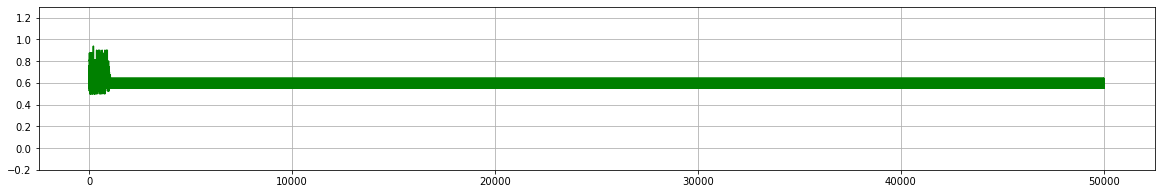

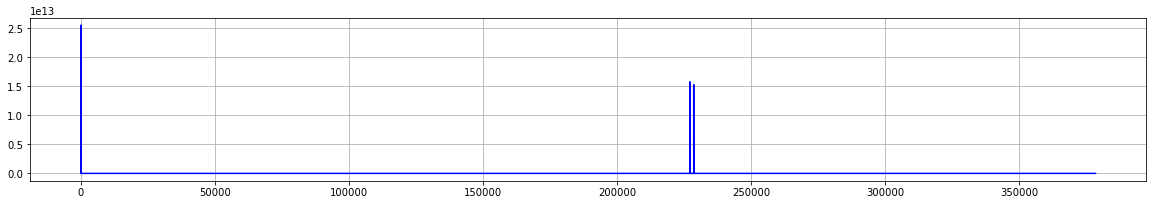

In [43]:
%matplotlib inline

plt.figure(figsize=(20,3))
plt.plot(box_avg,'g-')
plt.ylim(-0.2,1.3)
plt.grid()

plt.figure(figsize=(20,3))
plt.plot(avg_loss_l,'b-')
plt.grid()
plt.show()

In [ ]:
%matplotlib inline

plt.figure(figsize=(20,3))
plt.plot(box_avg[::2],'g-')
plt.ylim(-0.2,1.3)
plt.grid()

plt.figure(figsize=(20,3))
plt.plot(avg_loss_l,'b-')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


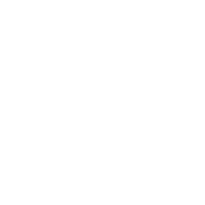

In [10]:
%matplotlib notebook
# %matplotlib inline
vis_box(used_boxes,pred_pos)

In [11]:
%matplotlib notebook
# %matplotlib inline
vis_box(np.array(boxes_multi)[0],np.array(gt_pos)[0])

NameError: name 'gt_pos' is not defined